In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.semi_supervised import LabelPropagation
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.semi_supervised import LabelSpreading

import joblib

from sklearn.multioutput import MultiOutputClassifier
import os

# Funciones generales

In [61]:
#Se seleccionan las columnas para x

class DataSetGenerator():
    def __init__(self, filename, outputname, outputfolder):
        self.filename = filename
        self.outputname = outputname
        self.outputfolder = outputfolder
    
    def save_data(self):
        self.X_m1 = self.df_nc_threshold_m1[self.columns_pp+self.columns_mp]
        self.Y_m1 = self.df_nc_threshold_m1[self.columns_predictors]
        
        self.X_m2 = self.df_nc_threshold_m2[self.columns_pp+self.columns_mp]
        self.Y_m2 = self.df_nc_threshold_m2[self.columns_predictors]

        self.X_m1.to_csv(f'{self.outputfolder}/dfx_{self.outputname}_m1.csv',index=False)
        self.Y_m1.to_csv(f'{self.outputfolder}/dfy_{self.outputname}_m1.csv',index=False)
        
        self.X_m2.to_csv(f'{self.outputfolder}/dfx_{self.outputname}_m2.csv',index=False)
        self.Y_m2.to_csv(f'{self.outputfolder}/dfy_{self.outputname}_m2.csv',index=False)
    
    def machine_separator(self):
        self.df_nc_threshold_m1 = self.df_nc_threshold.loc[self.df_nc_threshold["Maq"]==1].copy()
        self.df_nc_threshold_m2 = self.df_nc_threshold.loc[self.df_nc_threshold["Maq"]==2].copy()
    
    def apply_threshold(self):
        #Se umbralizan las variables de prediccion
        
        self.df_nc_threshold = self.df_nc.copy()
        
        for col in self.columns_predictors:
            self.df_nc_threshold[col] = np.where(self.df_nc_threshold[col] > 0, 1, 0)

    def columns_x(self):
        self.columns_pp = []
        self.columns_mp = []
        self.columns_predictors = []
        for name in self.df_nc.columns:
          if "PP_" == name[:3]:
            self.columns_pp.append(name)
          elif "Mp_" == name[:3]:
            self.columns_mp.append(name)
          elif name not in ["Unnamed: 0","Maq","Total_Nc","Fecha","Tipo_Producto"]: #"Tipo_Producto"
            self.columns_predictors.append(name)
    
    def run_process(self,delete_columns=None):

        #Read dataframe
        self.df_nc = pd.read_csv(self.filename, sep=',')

        if delete_columns is not None:
            self.df_nc.drop(delete_columns, axis=1, inplace=True)
        
        #Se extraen las clases predictoras
        self.columns_x()

        #Se umbralizan las clases de predicción
        self.apply_threshold()

        #Se separa el dataset por cada máquina
        self.machine_separator()

        #Se guardan los datos divididos entre X y Y
        self.save_data()

        return self.X_m1, self.Y_m1, self.X_m2, self.Y_m2

In [62]:
#Funcion para determinar el mejor modelo 

class GeneralClassifier():
    def __init__(self, dfx, dfy):
        self.dfx = dfx
        self.dfy = dfy

    def filter_output(self, ):
        self.X = np.array(self.dfx)
        self.Y = np.array(self.dfy[self.feature])
    
    def dont_filter(self):
        self.X = np.array(self.dfx)
        self.Y = np.array(self.dfy)
        
    def split_data(self, feature):
        self.feature =feature
        self.filter_output()
        
        scaler = MinMaxScaler()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        
    def train(self,feature=None):
        self.split_data(feature)
        
        self.models, self.predictions = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None).fit(self.X_train, self.X_test, self.y_train, self.y_test)
        
        

In [64]:
class BestModel():
    
    def __init__(self, dfx, dfy):
        self.dfx = dfx
        self.dfy = dfy
        
    def filter_output(self, ):

        #Se ordenan los dataframe
        self.dfx = self.dfx.sort_index(axis=1)
        self.dfy = self.dfy.sort_index(axis=1)
        
        #self.encoder = OneHotEncoder()
        
        #out = self.encoder.fit_transform(self.dfx[["Tipo_Producto"]])
        #df_encoded = pd.DataFrame(out.toarray(), columns=self.encoder.get_feature_names_out(['Tipo_Producto']))

        #del self.dfx["Tipo_Producto"]

        #self.dfx = pd.concat([self.dfx, df_encoded], axis=1)
        #self.dfx.append(df_encoded)
        
        #print("Producto luego del one-hot \n\n",self.dfx.head())

        #print("Tamaños: ",self.dfx.shape, " --- ", self.dfy.shape)
        
        self.X = np.array(self.dfx)
        self.Y = np.array(self.dfy).astype(int)
        
    def split_data(self):
        self.filter_output()
        
        self.scaler = StandardScaler()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
    
    def metrics(self):
        self.y_pred = self.best_model.predict(self.X_test)
        
        precision = precision_score(self.y_test_u, self.y_pred, average='weighted')
        recall = recall_score(self.y_test_u, self.y_pred, average='weighted')
        f1 = f1_score(self.y_test_u, self.y_pred, average='weighted')
        
        print("Presicion: ",precision,"Recall",f1,"f1",f1)
        
        cm = confusion_matrix(self.y_test_u, self.y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['0', '1'],
                    yticklabels=['0', '1'])

        plt.title('Matriz de Confusión')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.show()
    
    def grid_search_cv(self,feature, model, param_grid, name):
        self.feature = feature
        self.model = model

        self.dfy[feature]

        idx = self.dfy.columns.get_loc(feature)
        
        self.y_train_u = self.y_train[:,idx]
        self.y_test_u = self.y_test[:, idx]
        
        #self.split_data(self.feature)
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)

        # Ajustar GridSearchCV
        grid_search = grid_search.fit(self.X_train, self.y_train_u)

        print("Mejores hiperparámetros:", grid_search.best_params_)
        self.best_model = grid_search.best_estimator_

        joblib.dump(self.best_model, f'{name}.joblib')
        
        self.metrics()
        
        return self.best_model


# Generacion de dataset

Se dividen el conjunto de datos de entrada en dataframes divididos para los predictores y las variables predichas (X,Y). Además los conjuntos de datos se dividen por maquina. Quedando X_m1, X_m2, Y_m1, Y_m2

In [59]:
#Generacion de la base de datos aut

#data_generator = DataSetGenerator('aut_data_nc.csv', 'aut_nc', 'aut-data')

#Generacion de la base de datos aut sin algunas de las variables

data_generator = DataSetGenerator('aut_data_nc.csv', 'aut_nc', 'aut-data-without-variables')

data_generator.run_process(delete_columns=[
                                            'PP_Hidro_Bentonita_Kg',
                                            'PP_Hidro_CelulosaSR_SR°',
                                            'PP_Maq_CanalS_%',
                                            'Mp_CemPre_ARG_LOI_%',
                                            'Mp_CemCist_Bl_ARG_cm2/g', 
                                            'Mp_CemPre_ARG_Fi_min',
                                            'Mp_CemPre_ARG_Ff_min', 
                                            'Mp_CemPre_CEM_LOI_%',
                                            'Mp_CemCist_CEM_Bl_cm2/g', 
                                            'Mp_CemPre_CEM_Fi_min',
                                            'Mp_CemPre_CEM_Ff_min', 
                                            'Mp_FlocSAPP_SNF_Ret_%',
                                            'Mp_FlocSAPP_SNF_RetReal_%'
                                          ])

(      PP_Hidro_Cemento_Kg  PP_Hidro_Carbonato_Kg  PP_Hidro_Silice_Kg  \
 0                  465.00                  35.00              528.00   
 1                  465.00                  35.00              528.00   
 2                  465.00                  35.00              528.00   
 3                  465.00                  35.00              528.00   
 4                  465.00                  35.00              528.00   
 ...                   ...                    ...                 ...   
 7064               439.00                  30.00              527.00   
 7065               439.00                  30.00              527.00   
 7066               439.00                  30.00              527.00   
 7067               439.00                  30.00              527.00   
 7068               439.00                  30.00              527.00   
 
       PP_Hidro_Celulosa_Kg  PP_Hidro_Hidroxido_Kg  PP_Hidro_SolReales_%  \
 0                    79.00                  1

In [60]:
#Generacion de la base de datos nt

#data_generator = DataSetGenerator('nt_data_nc.csv', 'nt_nc', 'nt-data')
#data_generator.run_process()

#Generacion de la base de datos nt sin algunas variables

data_generator = DataSetGenerator('nt_data_nc.csv', 'nt_nc', 'nt-data-without-variables')
data_generator.run_process(delete_columns=[
                                            'PP_Hidro_Bentonita_Kg',
                                            'PP_Hidro_CelulosaSR_SR°',
                                            'PP_Maq_CanalS_%',
                                            'Mp_CemPre_ARG_LOI_%',
                                            'Mp_CemCist_Bl_ARG_cm2/g', 
                                            'Mp_CemPre_ARG_Fi_min',
                                            'Mp_CemPre_ARG_Ff_min', 
                                            'Mp_CemPre_CEM_LOI_%',
                                            'Mp_CemCist_CEM_Bl_cm2/g', 
                                            'Mp_CemPre_CEM_Fi_min',
                                            'Mp_CemPre_CEM_Ff_min', 
                                            'Mp_FlocSAPP_SNF_Ret_%',
                                            'Mp_FlocSAPP_SNF_RetReal_%'
                                          ])

(       PP_Hidro_Cemento_Kg  PP_Hidro_Carbonato_Kg  PP_Hidro_Celulosa_Kg  \
 60                  925.00                  50.00                 32.00   
 66                  925.00                  50.00                 32.00   
 67                  925.00                  50.00                 32.00   
 68                  925.00                  50.00                 32.00   
 69                  925.00                  50.00                 32.00   
 ...                    ...                    ...                   ...   
 16144               825.00                 150.00                 23.70   
 16145               825.00                 150.00                 23.70   
 16146               825.00                 150.00                 23.70   
 16147               825.00                 150.00                 23.70   
 16148               825.00                 150.00                 23.70   
 
        PP_Hidro_Pva_Kg  PP_Hidro_Agua_Kg  PP_Hidro_SolReales_%  \
 60               2

# Mejor modelo aut m1

In [73]:
#Carga de datos tanto de la maquina 1 como de la maquina 2

dfx_aut_nc_m1 = pd.read_csv('aut-data/dfx_aut_nc_m1.csv')
dfy_aut_nc_m1 = pd.read_csv('aut-data/dfy_aut_nc_m1.csv')

In [30]:
dfx_aut_nc_m1.columns

Index(['PP_Hidro_Cemento_Kg', 'PP_Hidro_Carbonato_Kg', 'PP_Hidro_Silice_Kg',
       'PP_Hidro_Celulosa_Kg', 'PP_Hidro_Hidroxido_Kg',
       'PP_Hidro_Bentonita_Kg', 'PP_Hidro_SolReales_%', 'PP_Hidro_CelulosaS_%',
       'PP_Hidro_CelulosaSR_SR°', 'PP_Refi_EE_AMP', 'PP_Refi_CelulosaH_%',
       'PP_Refi_CelulosaS_%', 'PP_Refi_CelulosaSR_SR°',
       'PP_Maq_FlujoFloc_L/min', 'PP_Maq_Resi_ml', 'PP_Maq_Vueltas_N',
       'PP_Maq_Vel_m/min', 'PP_Maq_FormatoP_PSI',
       'PP_Maq_FlujoFlocForm_L/Placa', 'PP_Maq_VacíoCP_PulgadasHg',
       'PP_Maq_VacioSF_PulgadasHg', 'PP_Maq_Recir_%', 'PP_Maq_Fieltro_Dias',
       'PP_PF_Humedad_%', 'PP_PF_Espesor_mm', 'PP_PF_Dens_g/cm3',
       'PP_Maq_FlocCanalS_%', 'PP_Maq_FlocTkS_%', 'PP_Maq_FlocFormS_%',
       'PP_MaqTCE_Densidad_g/cm3', 'PP_Maq_TCES_%', 'PP_Maq_CilinS_%',
       'PP_Maq_CanalS_%', 'PP_Maq_Cono1S_%', 'PP_Maq_MolinoS_%',
       'PP_Maq_P1H_%', 'PP_Maq_P3H_%', 'Mp_CemPre_ARG_LOI_%',
       'Mp_CemCist_Bl_ARG_cm2/g', 'Mp_CemPre_ARG_Fi_mi

In [21]:
dfx_aut_nc_m1.shape, dfy_aut_nc_m1.shape

((6686, 48), (6686, 57))

### Elección del mejor modelo según la caracteristica de interes

Utilizacion de lazypredict para determinar apriori el mejor clasificador para label

In [146]:
classifier = GeneralClassifier(dfx_aut_nc_m1, dfy_aut_nc_m1)

for caract in dfy_aut_nc_m1.columns:
    classifier.train(feature=caract)
    idx = classifier.predictions['Balanced Accuracy'].idxmax()
    
    print("\nMejor modelo de: ", caract,"\n")
    print("Modelo: ",idx)
    print(classifier.predictions[['Accuracy','Balanced Accuracy','ROC AUC','F1 Score']].loc[idx],"\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.78it/s]


[LightGBM] [Info] Number of positive: 3169, number of negative: 2179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592558 -> initscore=0.374550
[LightGBM] [Info] Start training from score 0.374550

Mejor modelo de:  Manipulación 

Modelo:  ExtraTreesClassifier
Accuracy            0.96
Balanced Accuracy   0.96
ROC AUC             0.96
F1 Score            0.96
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.55it/s]


[LightGBM] [Info] Number of positive: 4988, number of negative: 360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.932685 -> initscore=2.628686
[LightGBM] [Info] Start training from score 2.628686

Mejor modelo de:  Maquina 

Modelo:  LabelPropagation
Accuracy            0.96
Balanced Accuracy   0.87
ROC AUC             0.87
F1 Score            0.96
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  4.91it/s]


[LightGBM] [Info] Number of positive: 4574, number of negative: 774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.855273 -> initscore=1.776572
[LightGBM] [Info] Start training from score 1.776572

Mejor modelo de:  Material 

Modelo:  ExtraTreesClassifier
Accuracy            0.95
Balanced Accuracy   0.86
ROC AUC             0.86
F1 Score            0.95
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 10.61it/s]


[LightGBM] [Info] Number of positive: 7, number of negative: 5341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001309 -> initscore=-6.637258
[LightGBM] [Info] Start training from score -6.637258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


[LightGBM] [Info] Number of positive: 2765, number of negative: 2583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517016 -> initscore=0.068089
[LightGBM] [Info] Start training from score 0.068089

Mejor modelo de:  Basura 

Modelo:  ExtraTreesClassifier
Accuracy            0.93
Balanced Accuracy   0.93
ROC AUC             0.93
F1 Score            0.93
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


[LightGBM] [Info] Number of positive: 2894, number of negative: 2454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541137 -> initscore=0.164920
[LightGBM] [Info] Start training from score 0.164920

Mejor modelo de:  Nudo 

Modelo:  ExtraTreesClassifier
Accuracy            0.91
Balanced Accuracy   0.91
ROC AUC             0.91
F1 Score            0.91
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.08it/s]


[LightGBM] [Info] Number of positive: 919, number of negative: 4429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171840 -> initscore=-1.572643
[LightGBM] [Info] Start training from score -1.572643

Mejor modelo de:  Espesor 

Modelo:  ExtraTreesClassifier
Accuracy            0.96
Balanced Accuracy   0.88
ROC AUC             0.88
F1 Score            0.96
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.70it/s]


[LightGBM] [Info] Number of positive: 2303, number of negative: 3045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430628 -> initscore=-0.279288
[LightGBM] [Info] Start training from score -0.279288

Mejor modelo de:  Ondulación 

Modelo:  ExtraTreesClassifier
Accuracy            0.94
Balanced Accuracy   0.94
ROC AUC             0.94
F1 Score            0.94
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.57it/s]


[LightGBM] [Info] Number of positive: 3998, number of negative: 1350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.747569 -> initscore=1.085690
[LightGBM] [Info] Start training from score 1.085690

Mejor modelo de:  Fisura 

Modelo:  ExtraTreesClassifier
Accuracy            0.94
Balanced Accuracy   0.91
ROC AUC             0.91
F1 Score            0.94
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


[LightGBM] [Info] Number of positive: 2828, number of negative: 2520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528796 -> initscore=0.115311
[LightGBM] [Info] Start training from score 0.115311

Mejor modelo de:  Despunte 

Modelo:  ExtraTreesClassifier
Accuracy            0.96
Balanced Accuracy   0.96
ROC AUC             0.96
F1 Score            0.96
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.35it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.73it/s]


[LightGBM] [Info] Number of positive: 2221, number of negative: 3127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.415295 -> initscore=-0.342117
[LightGBM] [Info] Start training from score -0.342117

Mejor modelo de:  Desborde 

Modelo:  ExtraTreesClassifier
Accuracy            0.95
Balanced Accuracy   0.96
ROC AUC             0.96
F1 Score            0.95
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.50it/s]


[LightGBM] [Info] Number of positive: 136, number of negative: 5212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025430 -> initscore=-3.646064
[LightGBM] [Info] Start training from score -3.646064

Mejor modelo de:  Desplazada 

Modelo:  LabelPropagation
Accuracy            0.99
Balanced Accuracy   0.90
ROC AUC             0.90
F1 Score            0.99
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.29it/s]


[LightGBM] [Info] Number of positive: 214, number of negative: 5134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040015 -> initscore=-3.177664
[LightGBM] [Info] Start training from score -3.177664

Mejor modelo de:  Rajada 

Modelo:  LabelPropagation
Accuracy            0.98
Balanced Accuracy   0.89
ROC AUC             0.89
F1 Score            0.98
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.27it/s]


[LightGBM] [Info] Number of positive: 35, number of negative: 5313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006545 -> initscore=-5.022564
[LightGBM] [Info] Start training from score -5.022564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  4.87it/s]


[LightGBM] [Info] Number of positive: 2412, number of negative: 2936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451010 -> initscore=-0.196592
[LightGBM] [Info] Start training from score -0.196592

Mejor modelo de:  Tallon 

Modelo:  ExtraTreesClassifier
Accuracy            0.96
Balanced Accuracy   0.96
ROC AUC             0.96
F1 Score            0.96
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  7.12it/s]


[LightGBM] [Info] Number of positive: 65, number of negative: 5283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012154 -> initscore=-4.397862
[LightGBM] [Info] Start training from score -4.397862

Mejor modelo de:  Dimensiones 

Modelo:  LabelPropagation
Accuracy            1.00
Balanced Accuracy   0.97
ROC AUC             0.97
F1 Score            1.00
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.43it/s]


[LightGBM] [Info] Number of positive: 114, number of negative: 5234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021316 -> initscore=-3.826733
[LightGBM] [Info] Start training from score -3.826733

Mejor modelo de:  Desmoldeo 

Modelo:  LabelPropagation
Accuracy            0.99
Balanced Accuracy   0.92
ROC AUC             0.92
F1 Score            0.99
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.70it/s]


[LightGBM] [Info] Number of positive: 936, number of negative: 4412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175019 -> initscore=-1.550468
[LightGBM] [Info] Start training from score -1.550468

Mejor modelo de:  Roto 

Modelo:  ExtraTreesClassifier
Accuracy            0.95
Balanced Accuracy   0.89
ROC AUC             0.89
F1 Score            0.95
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


[LightGBM] [Info] Number of positive: 1864, number of negative: 3484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348542 -> initscore=-0.625456
[LightGBM] [Info] Start training from score -0.625456

Mejor modelo de:  Delaminada 

Modelo:  ExtraTreesClassifier
Accuracy            0.93
Balanced Accuracy   0.92
ROC AUC             0.92
F1 Score            0.93
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.41it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 11.05it/s]


[LightGBM] [Info] Number of positive: 5, number of negative: 5343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000935 -> initscore=-6.974105
[LightGBM] [Info] Start training from score -6.974105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Mejor modelo de:  Daño 

Modelo:  AdaBoostClassifier
Accuracy            1.00
Balanced Accuracy   0.50
ROC AUC             0.50
F1 Score            1.00
Name: AdaBoostClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.72it/s]


[LightGBM] [Info] Number of positive: 649, number of negative: 4699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121354 -> initscore=-1.979672
[LightGBM] [Info] Start training from score -1.979672

Mejor modelo de:  Descolgada 

Modelo:  LabelPropagation
Accuracy            0.94
Balanced Accuracy   0.86
ROC AUC             0.86
F1 Score            0.94
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.89it/s]


[LightGBM] [Info] Number of positive: 64, number of negative: 5284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011967 -> initscore=-4.413556
[LightGBM] [Info] Start training from score -4.413556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Mejor modelo de:  Mal Ondulada 

Modelo:  LabelPropagation
Accuracy            1.00
Balanced Accuracy   0.95
ROC AUC             0.95
F1 Score            1.00
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]


[LightGBM] [Info] Number of positive: 1828, number of negative: 3520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341810 -> initscore=-0.655239
[LightGBM] [Info] Start training from score -0.655239

Mejor modelo de:  Mancha 

Modelo:  ExtraTreesClassifier
Accuracy            0.93
Balanced Accuracy   0.93
ROC AUC             0.93
F1 Score            0.93
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.64it/s]


[LightGBM] [Info] Number of positive: 48, number of negative: 5300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008975 -> initscore=-4.704261
[LightGBM] [Info] Start training from score -4.704261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.46it/s]


[LightGBM] [Info] Number of positive: 312, number of negative: 5036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058340 -> initscore=-2.781364
[LightGBM] [Info] Start training from score -2.781364

Mejor modelo de:  Mal Corte 

Modelo:  LabelSpreading
Accuracy            0.97
Balanced Accuracy   0.84
ROC AUC             0.84
F1 Score            0.97
Name: LabelSpreading, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.75it/s]


[LightGBM] [Info] Number of positive: 1477, number of negative: 3871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276178 -> initscore=-0.963500
[LightGBM] [Info] Start training from score -0.963500

Mejor modelo de:  Burbuja 

Modelo:  ExtraTreesClassifier
Accuracy            0.93
Balanced Accuracy   0.91
ROC AUC             0.91
F1 Score            0.93
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.69it/s]


[LightGBM] [Info] Number of positive: 65, number of negative: 5283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012154 -> initscore=-4.397862
[LightGBM] [Info] Start training from score -4.397862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Mejor modelo de:  Desmoldeadora 

Modelo:  LabelPropagation
Accuracy            0.99
Balanced Accuracy   0.92
ROC AUC             0.92
F1 Score            0.99
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.71it/s]


[LightGBM] [Info] Number of positive: 295, number of negative: 5053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055161 -> initscore=-2.840762
[LightGBM] [Info] Start training from score -2.840762

Mejor modelo de:  Tallon_Montacargas 

Modelo:  LabelPropagation
Accuracy            0.99
Balanced Accuracy   0.94
ROC AUC             0.94
F1 Score            0.99
Name: LabelPropagation, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 13.81it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.12it/s]


[LightGBM] [Info] Number of positive: 28, number of negative: 5320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005236 -> initscore=-5.247024
[LightGBM] [Info] Start training from score -5.247024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.27it/s]


[LightGBM] [Info] Number of positive: 583, number of negative: 4765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109013 -> initscore=-2.100866
[LightGBM] [Info] Start training from score -2.100866

Mejor modelo de:  Daño Estiba 

Modelo:  ExtraTreesClassifier
Accuracy            0.99
Balanced Accuracy   0.96
ROC AUC             0.96
F1 Score            0.99
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  7.13it/s]


[LightGBM] [Info] Number of positive: 112, number of negative: 5236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020942 -> initscore=-3.844814
[LightGBM] [Info] Start training from score -3.844814

Mejor modelo de:  Pegada 

Modelo:  QuadraticDiscriminantAnalysis
Accuracy            0.96
Balanced Accuracy   0.94
ROC AUC             0.94
F1 Score            0.97
Name: QuadraticDiscriminantAnalysis, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.97it/s]


[LightGBM] [Info] Number of positive: 35, number of negative: 5313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006545 -> initscore=-5.022564
[LightGBM] [Info] Start training from score -5.022564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.80it/s]


[LightGBM] [Info] Number of positive: 69, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012902 -> initscore=-4.337385
[LightGBM] [Info] Start training from score -4.337385

Mejor modelo de:  Flexible 

Modelo:  QuadraticDiscriminantAnalysis
Accuracy            1.00
Balanced Accuracy   0.89
ROC AUC             0.89
F1 Score            1.00
Name: QuadraticDiscriminantAnalysis, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.70it/s]


[LightGBM] [Info] Number of positive: 1132, number of negative: 4216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211668 -> initscore=-1.314901
[LightGBM] [Info] Start training from score -1.314901

Mejor modelo de:  Separador 

Modelo:  ExtraTreesClassifier
Accuracy            0.98
Balanced Accuracy   0.97
ROC AUC             0.97
F1 Score            0.98
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 12.31it/s]


[LightGBM] [Info] Number of positive: 1, number of negative: 5347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000187 -> initscore=-8.584291
[LightGBM] [Info] Start training from score -8.584291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 10.40it/s]


[LightGBM] [Info] Number of positive: 8, number of negative: 5340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001496 -> initscore=-6.503539
[LightGBM] [Info] Start training from score -6.503539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.57it/s]


[LightGBM] [Info] Number of positive: 7, number of negative: 5341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001309 -> initscore=-6.637258
[LightGBM] [Info] Start training from score -6.637258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Mejor modelo de:  Esquinas Levantadas 

Modelo:  ExtraTreesClassifier
Accuracy            1.00
Balanced Accuracy   1.00
ROC AUC             1.00
F1 Score            1.00
Name: ExtraTreesClassifier, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 12.02it/s]


[LightGBM] [Info] Number of positive: 4, number of negative: 5344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000748 -> initscore=-7.197435
[LightGBM] [Info] Start training from score -7.197435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.44it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.22it/s]


[LightGBM] [Info] Number of positive: 389, number of negative: 4959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072737 -> initscore=-2.545380
[LightGBM] [Info] Start training from score -2.545380

Mejor modelo de:  Piel De Elefante 

Modelo:  QuadraticDiscriminantAnalysis
Accuracy            0.82
Balanced Accuracy   0.84
ROC AUC             0.84
F1 Score            0.86
Name: QuadraticDiscriminantAnalysis, dtype: float64 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 13.64it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 10.68it/s]


[LightGBM] [Info] Number of positive: 4, number of negative: 5344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000748 -> initscore=-7.197435
[LightGBM] [Info] Start training from score -7.197435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.07it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.54it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.21it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.24it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.97it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.72it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.99it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.00it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.40it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.99it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.91it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 5348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7378
[LightGBM] [Info] Number of data points in the train set: 5348, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

Entranamiento basico del mejor modelo para cada uno de los labels

In [ ]:
e_tree_c = ExtraTreesClassifier()

classifier.split_data('Material')

e_tree_c.fit(classifier.X_train, classifier.y_train)

In [ ]:
y_pred = e_tree_c.predict(classifier.X_test)

precision = precision_score(classifier.y_test, y_pred, average='weighted')
recall = recall_score(classifier.y_test, y_pred, average='weighted')
f1 = f1_score(classifier.y_test, y_pred, average='weighted')

precision, recall, f1, cm

(0.9526409714525007,
 0.952914798206278,
 0.9505654898902769,
 array([[ 159,   52],
        [   6, 1121]]))

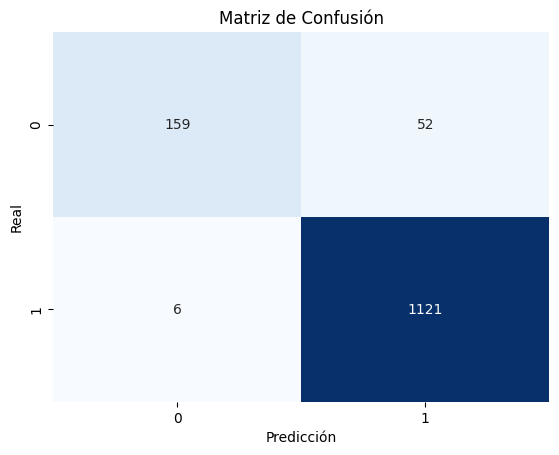

In [ ]:
cm = confusion_matrix(classifier.y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Tuneo del mejor modelo de ExtraTreeClassifier para cada labels

In [ ]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para las caracteristicas dadas

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

e_tree_columns = ['Manipulación','Material','Basura','Nudo','Espesor','Ondulación','Fisura','Despunte','Desborde','Caponeo','Tallon','Roto']

for col in e_tree_columns:
    b_model = BestModel(dfx_aut_nc_m1, dfy_aut_nc_m1)
    b_model.grid_search_cv(col, extra_trees, param_grid, f'{col}_aut_m1_best')

Entrenamiento del mejor modelo de ExtraTreeClassifier para todos los labels

Producto luego del one-hot 

    Mp_CemCist_Bl_ARG_cm2/g  Mp_CemCist_CEM_Bl_cm2/g  Mp_CemPre_ARG_Ff_min  \
0                  4180.00                  3402.00                255.00   
1                  4180.00                  3402.00                255.00   
2                  4180.00                  3402.00                255.00   
3                  4180.00                  3402.00                255.00   
4                  4180.00                  3402.00                255.00   

   Mp_CemPre_ARG_Fi_min  Mp_CemPre_ARG_LOI_%  Mp_CemPre_CEM_Ff_min  \
0                165.00                 2.52                225.00   
1                165.00                 2.52                225.00   
2                165.00                 2.52                225.00   
3                165.00                 2.52                225.00   
4                165.00                 2.52                225.00   

   Mp_CemPre_CEM_Fi_min  Mp_CemPre_CEM_LOI_%  Mp_FlocSAPP_SNF_RetReal_%  \
0          

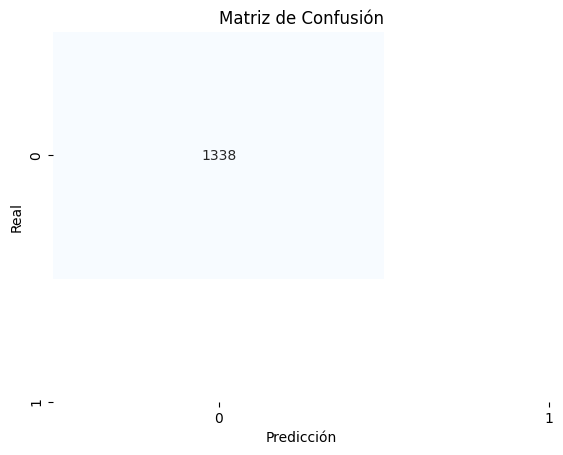

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9606941867103368 Recall 0.9604490236572695 f1 0.9604490236572695


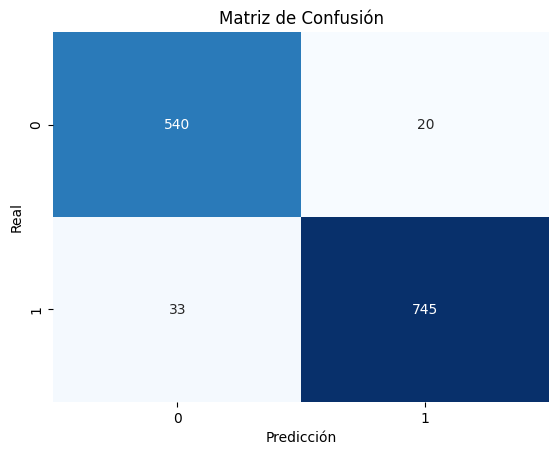

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9772136385211002 Recall 0.9760842178826602 f1 0.9760842178826602


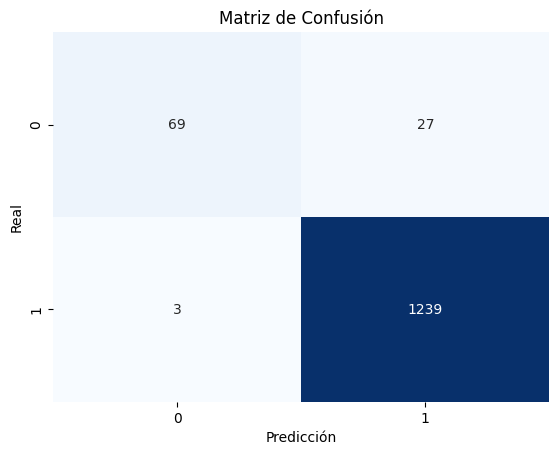

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9614693716025375 Recall 0.9593437410654494 f1 0.9593437410654494


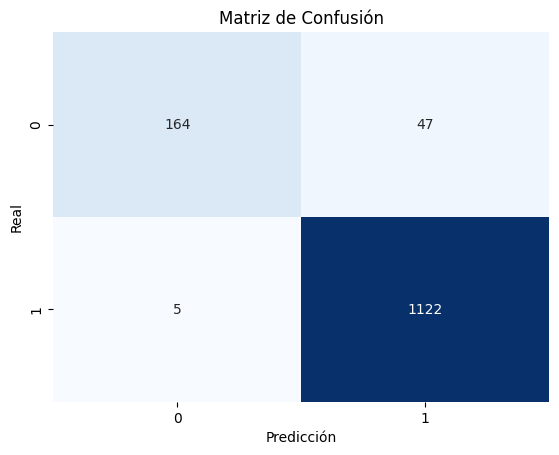

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9955207223149469 Recall 0.9966380295229325 f1 0.9966380295229325


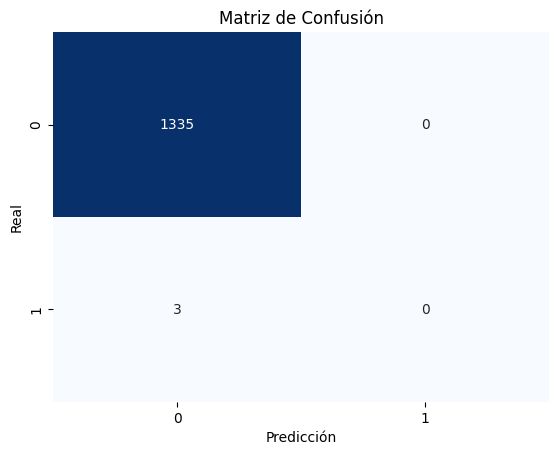

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9387881894597 Recall 0.9387177858891567 f1 0.9387177858891567


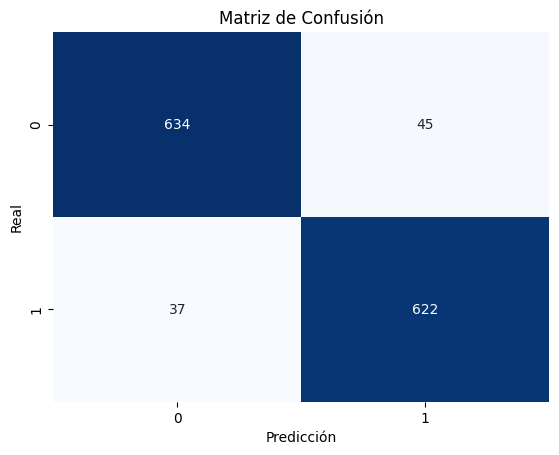

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.918771736598986 Recall 0.9185910735782241 f1 0.9185910735782241


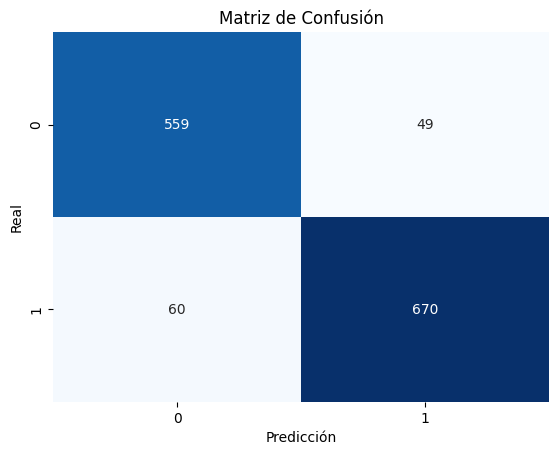

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9638905101528683 Recall 0.9626554087762149 f1 0.9626554087762149


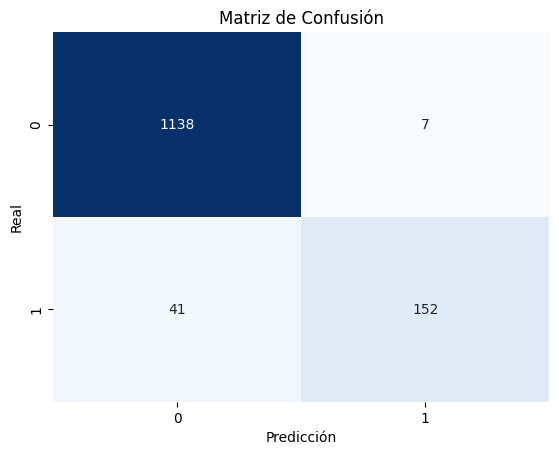

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9514915555074264 Recall 0.9504444579407932 f1 0.9504444579407932


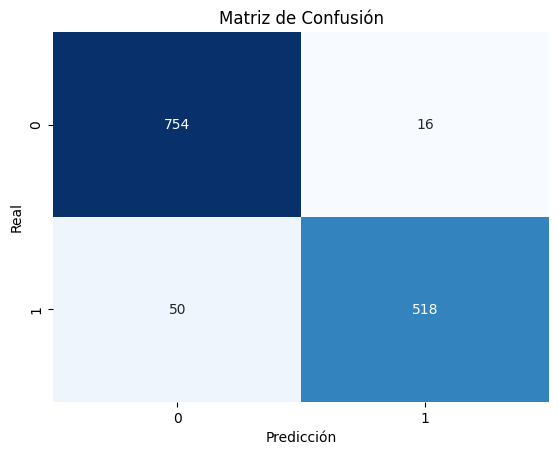

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9508260418908969 Recall 0.9498576352884148 f1 0.9498576352884148


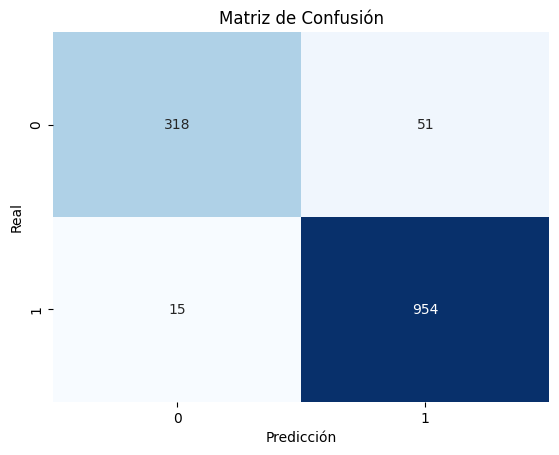

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9589210797263603 Recall 0.9588811294931638 f1 0.9588811294931638


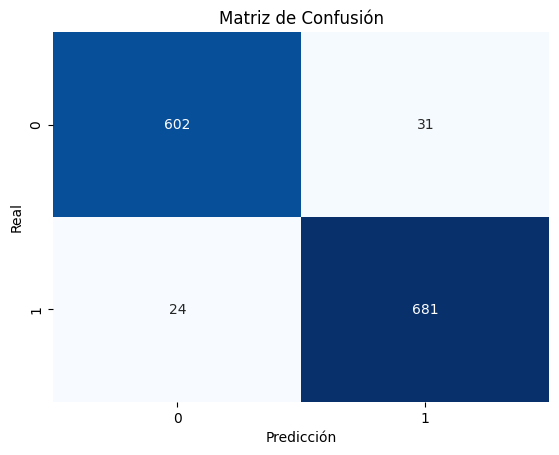

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


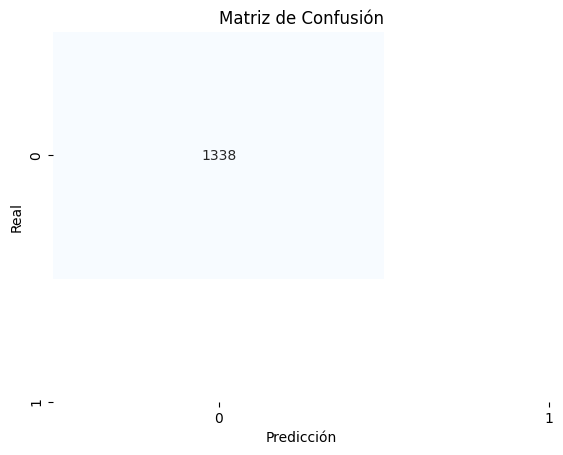

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9548627267544477 Recall 0.9531464990288038 f1 0.9531464990288038


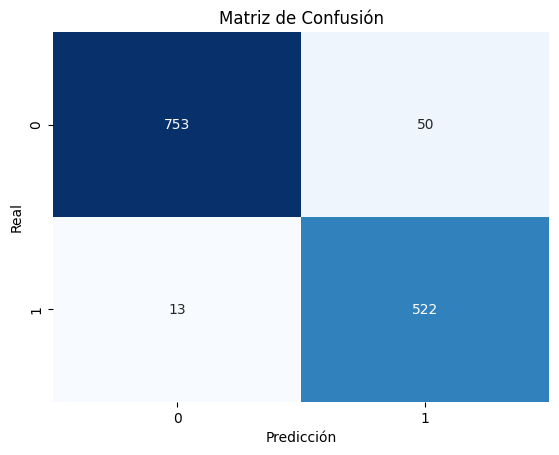

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9945517136693284 Recall 0.9944197745342016 f1 0.9944197745342016


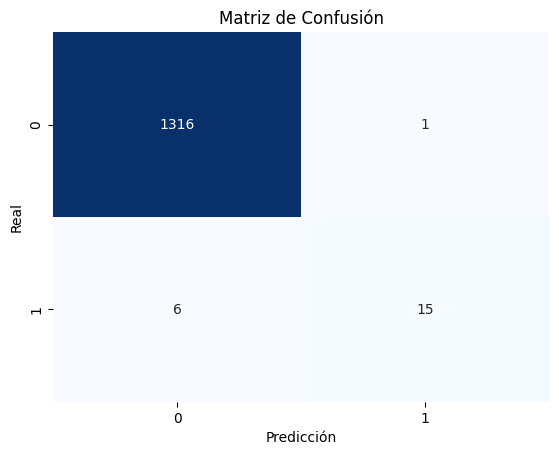

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9830016815403936 Recall 0.982455034889289 f1 0.982455034889289


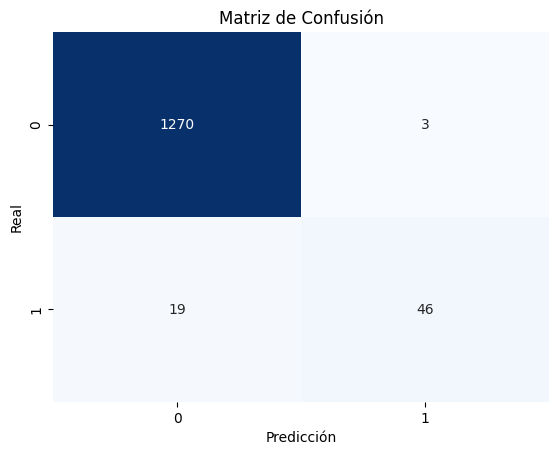

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9977629012206337 Recall 0.9975612753985038 f1 0.9975612753985038


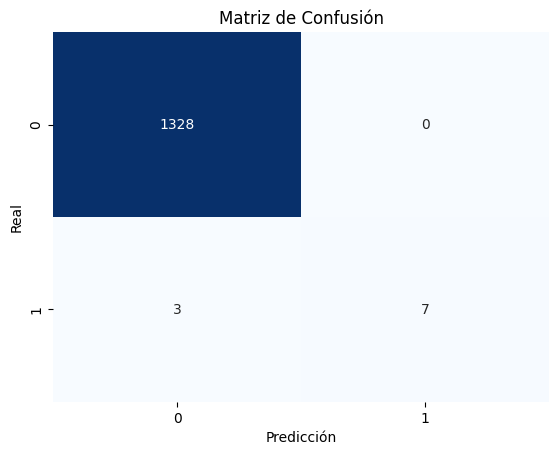

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9608034978817159 Recall 0.9604399417343199 f1 0.9604399417343199


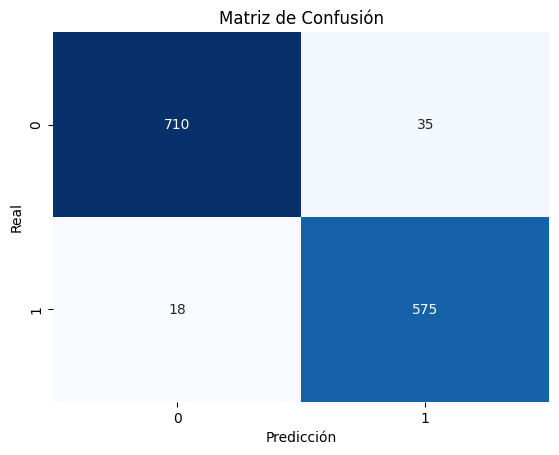

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9977629241052541 Recall 0.997643144711499 f1 0.997643144711499


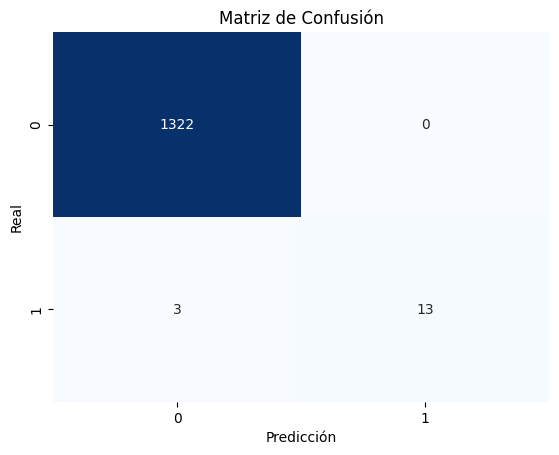

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9912919110276233 Recall 0.9913671477764555 f1 0.9913671477764555


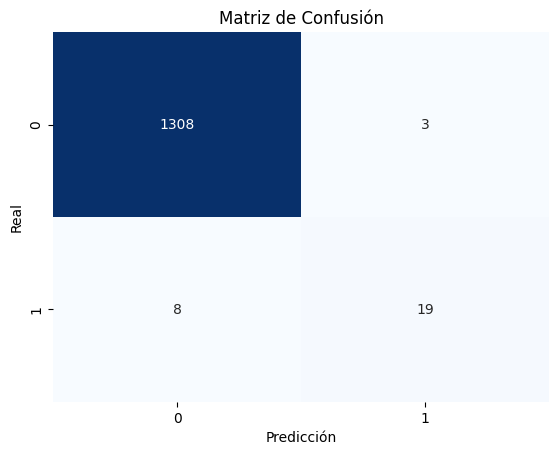

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9518966087936509 Recall 0.9517087928221308 f1 0.9517087928221308


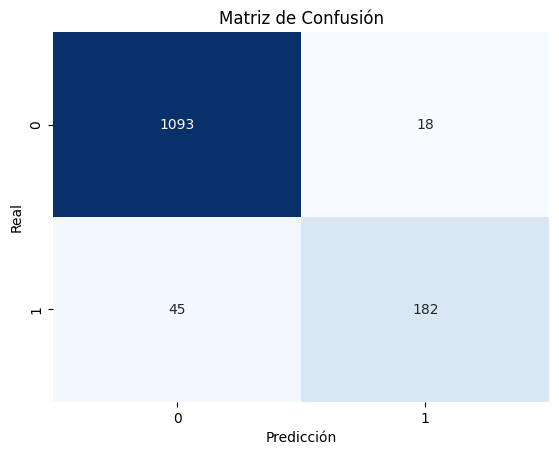

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9347974445331064 Recall 0.9348594681327291 f1 0.9348594681327291


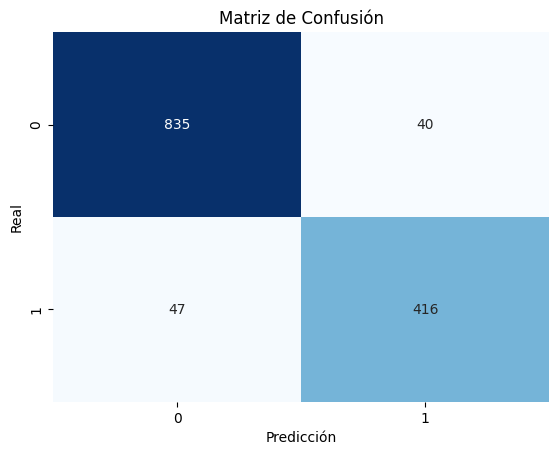

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


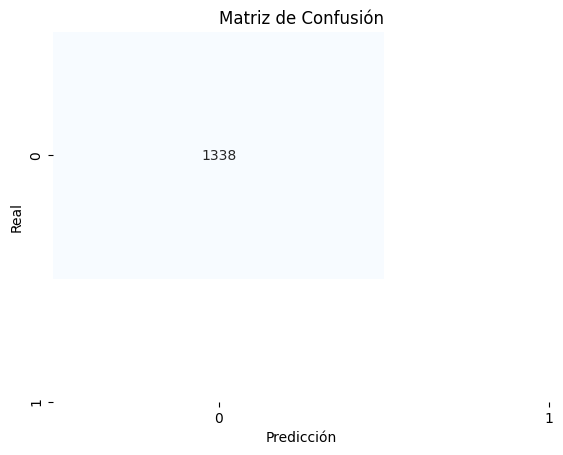

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9970126977104797 Recall 0.9977584065344964 f1 0.9977584065344964


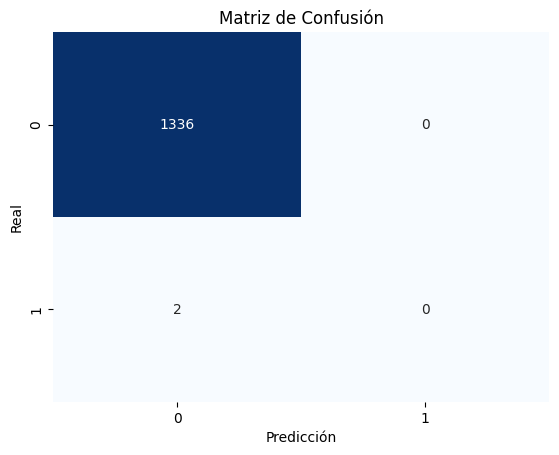

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9685377861609346 Recall 0.9679891685626777 f1 0.9679891685626777


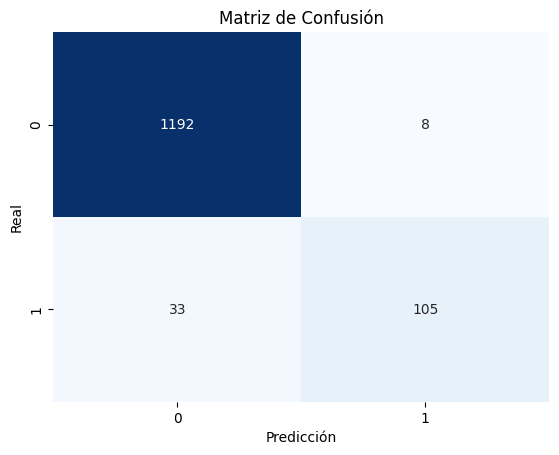

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9955358794855665 Recall 0.9946799453791431 f1 0.9946799453791431


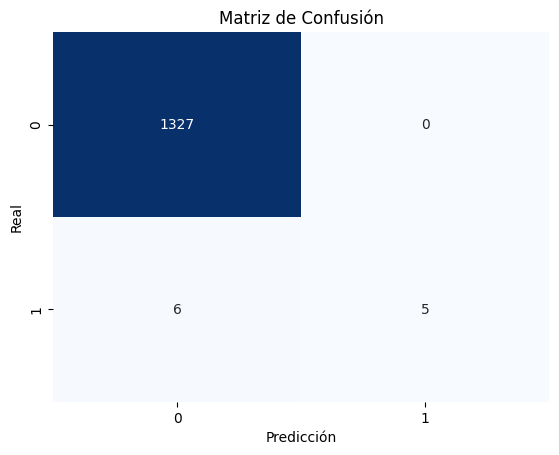

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9334260711128595 Recall 0.9329706480815589 f1 0.9329706480815589


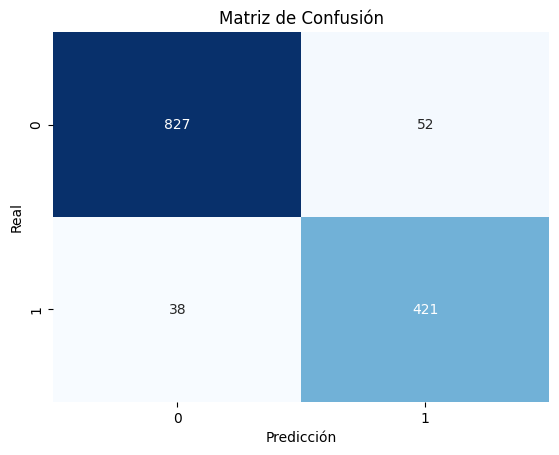

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9977629088258815 Recall 0.9975989605388405 f1 0.9975989605388405


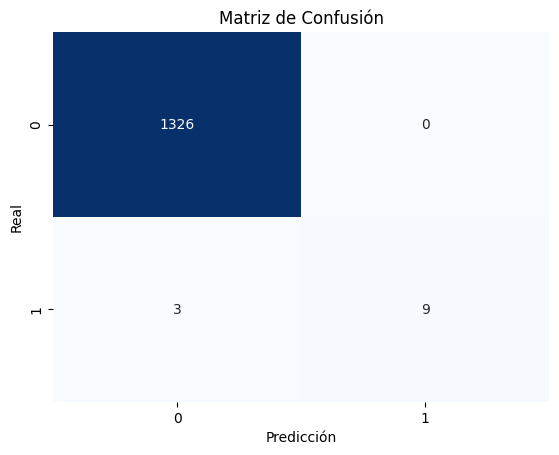

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9819430721289049 Recall 0.980205029004818 f1 0.980205029004818


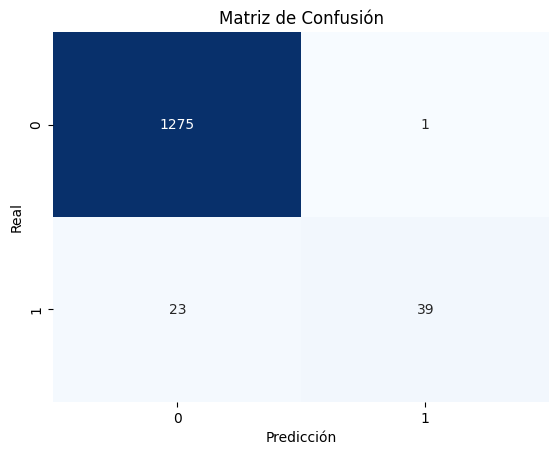

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9306456514624848 Recall 0.9308485354369063 f1 0.9308485354369063


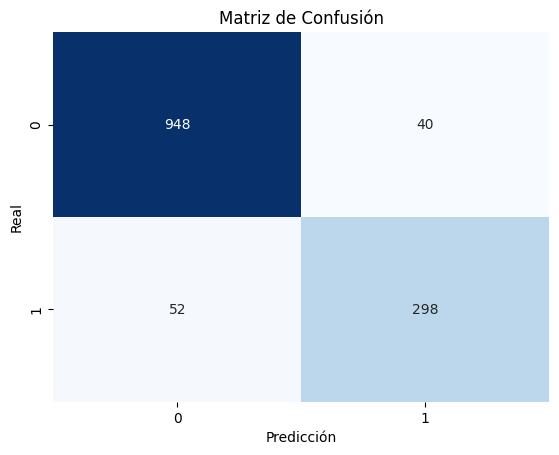

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9934038956386361 Recall 0.9931308192410898 f1 0.9931308192410898


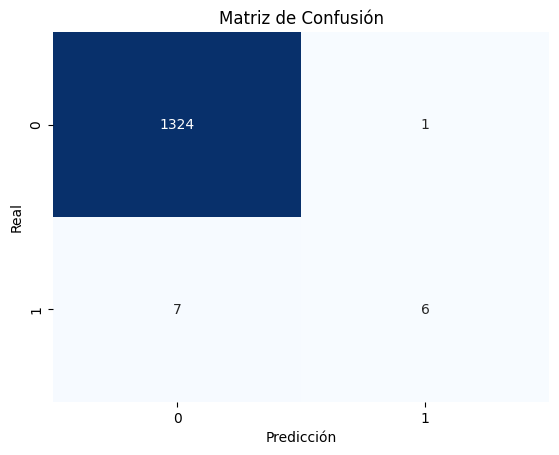

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9900877579671501 Recall 0.9899208871355906 f1 0.9899208871355906


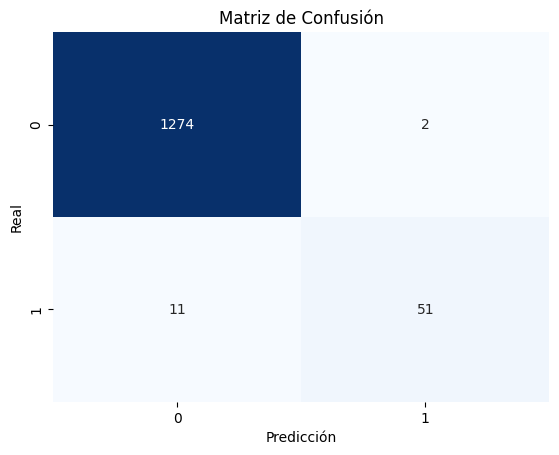

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


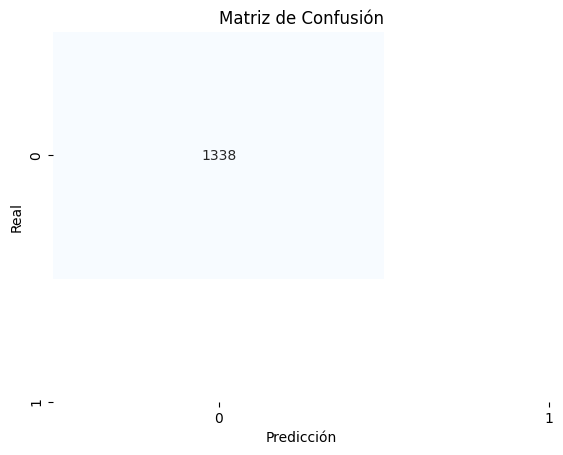

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9977628860785005 Recall 0.9973854165090349 f1 0.9973854165090349


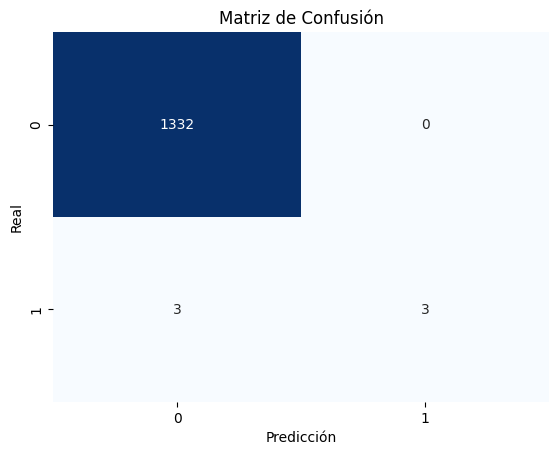

In [ ]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para las caracteristicas dadas

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

b_model = BestModel(dfx_aut_nc_m1, dfy_aut_nc_m1)
b_model.split_data()
joblib.dump(b_model.scaler, 'scaler-aut-m1/scaler.joblib')
joblib.dump(b_model.encoder, 'scaler-aut-m1/oneHotEncoder.joblib')

for col in dfy_aut_nc_m1.columns:
    b_model.grid_search_cv(col, extra_trees, param_grid, f'best-aut-m1-2/{col}_aut_m1_best_extra_tree_classifier')

Vairbale:  Separador
Presicion:  0.9781178472745926 Recall 0.977738700742001 f1 0.977738700742001
[1024   21]


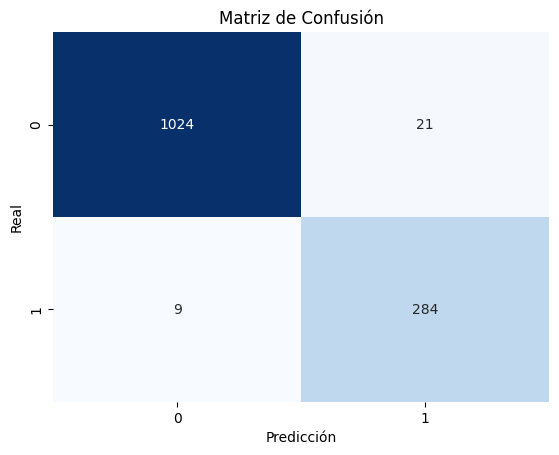

Vairbale:  Nudo
Presicion:  0.9066639658758613 Recall 0.9066077437396377 f1 0.9066077437396377
[548  60]


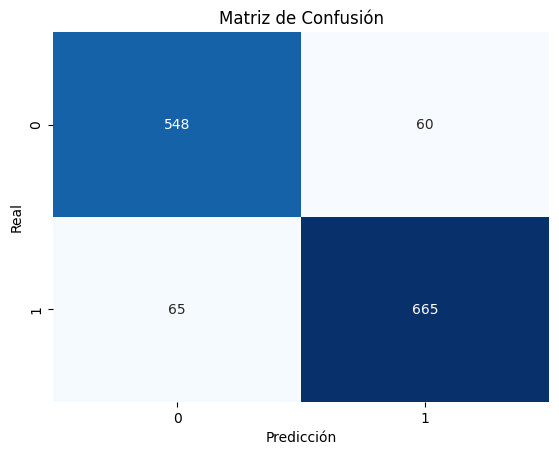

Vairbale:  Descolgada
Presicion:  0.9604015331013113 Recall 0.9598733326970708 f1 0.9598733326970708
[1189   11]


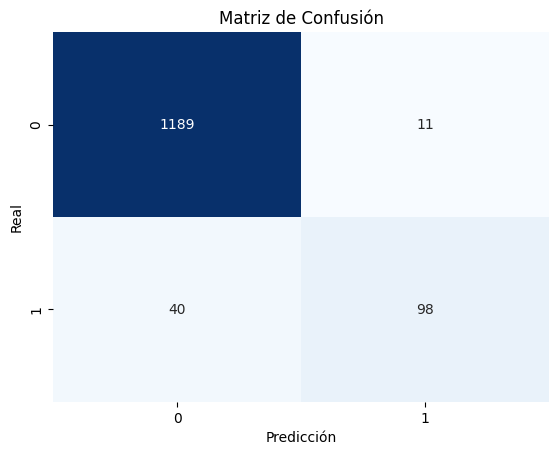

Vairbale:  Fisura
Presicion:  0.9417075612713992 Recall 0.9395220523933784 f1 0.9395220523933784
[304  65]


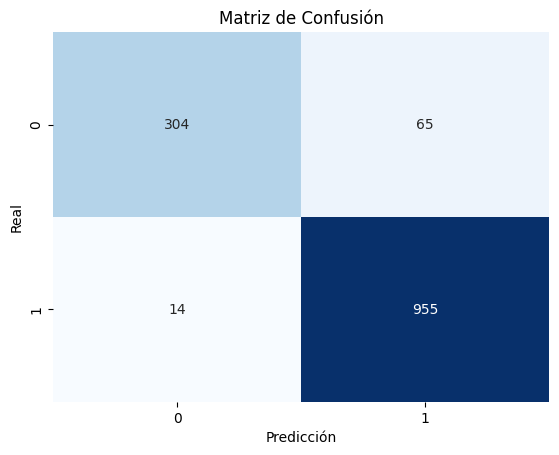

Vairbale:  Mal Ondulada
Presicion:  0.9977629050203984 Recall 0.9975821012960985 f1 0.9975821012960985
[1327    0]


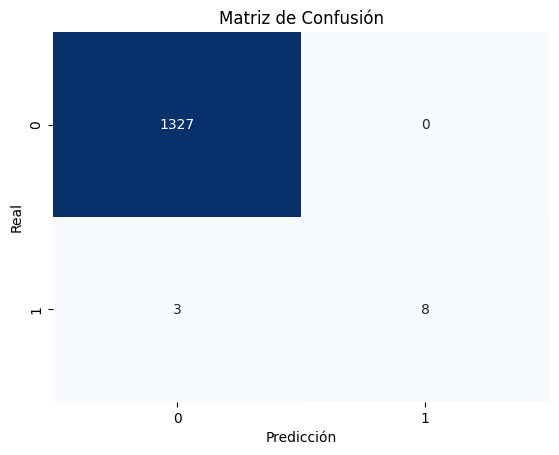

Vairbale:  Perdida De Grados
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


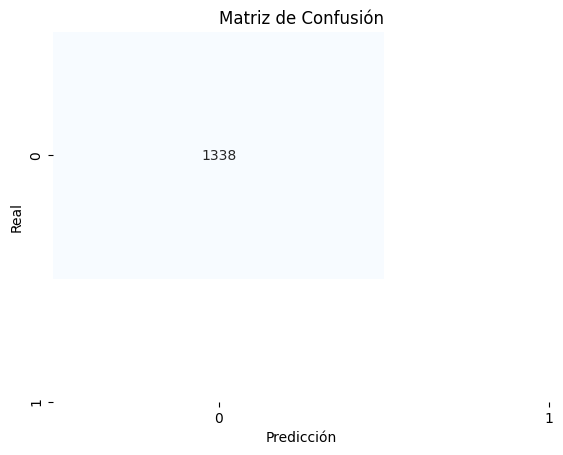

Vairbale:  Incrustaciones
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


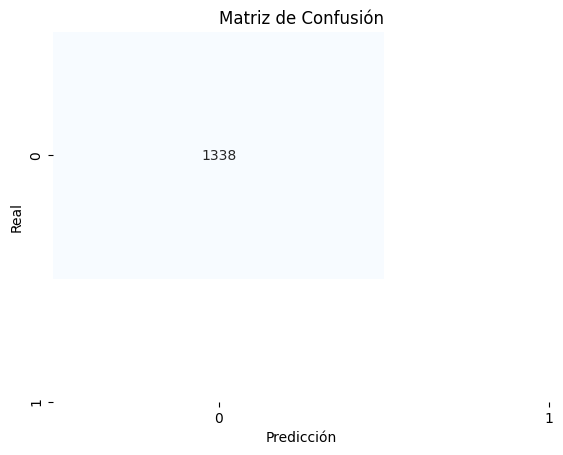

Vairbale:  Quebrada
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


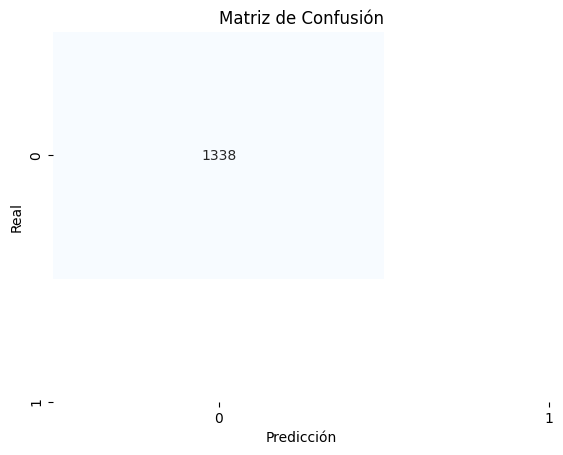

Vairbale:  Muestra
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


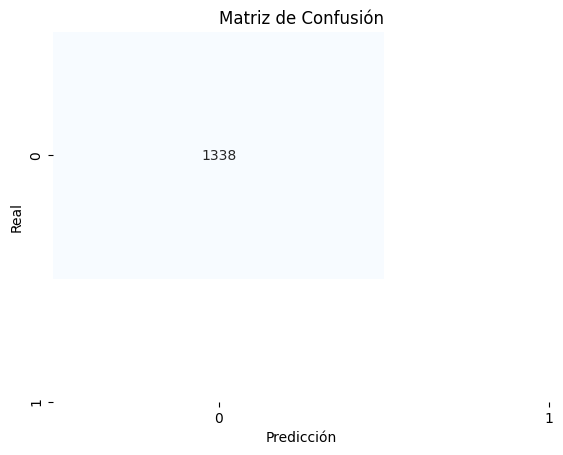

Vairbale:  Desmoldeadora
Presicion:  0.9934038956386361 Recall 0.9931308192410898 f1 0.9931308192410898
[1324    1]


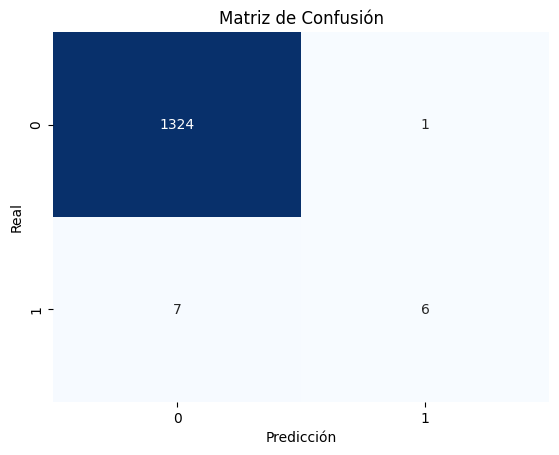

Vairbale:  Espesor
Presicion:  0.9604052829845573 Recall 0.9597497725415519 f1 0.9597497725415519
[1134   11]


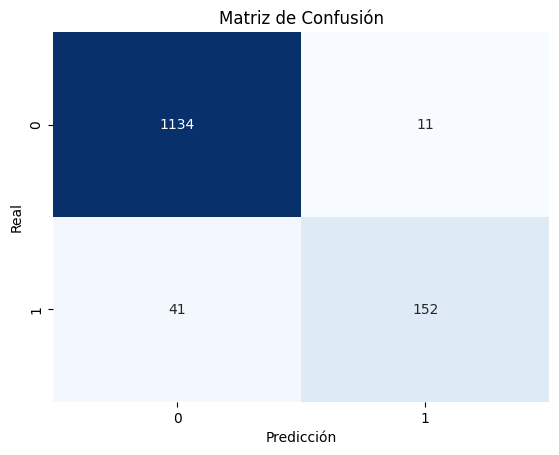

Vairbale:  Exceso
Fallo 'Exceso'
Vairbale:  Sello Litografico
Presicion:  0.9985057902721639 Recall 0.998879063464789 f1 0.998879063464789
[1337    0]


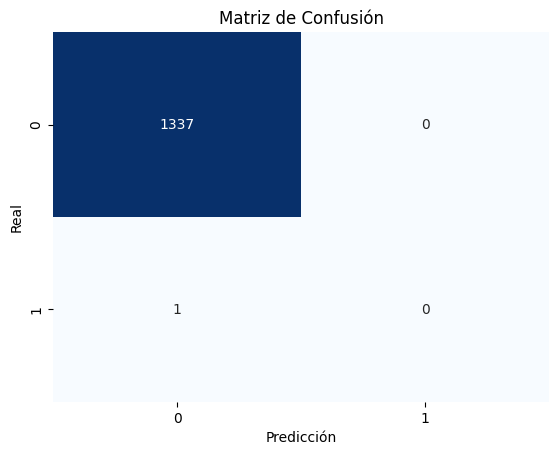

Vairbale:  Daño Molde
Presicion:  0.9992531752638221 Recall 0.9991780173361785 f1 0.9991780173361785
[1335    0]


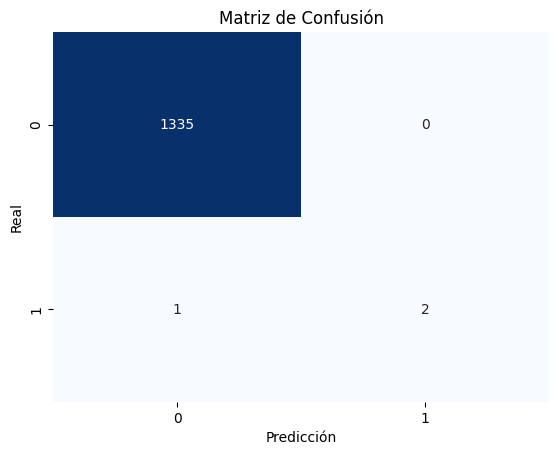

Vairbale:  Sin
Fallo 'Sin'
Vairbale:  Manipulación
Presicion:  0.9576421036317928 Recall 0.957454615625974 f1 0.957454615625974
[537  23]


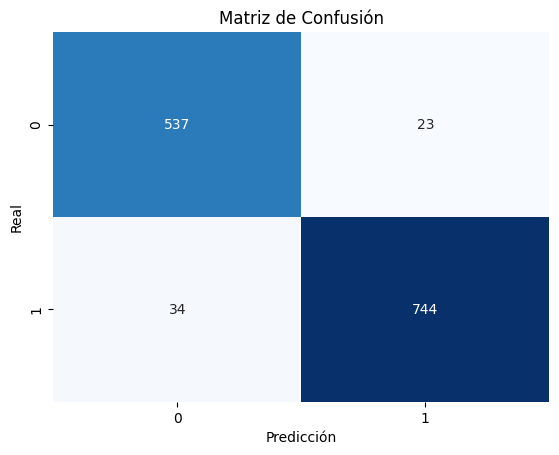

Vairbale:  Mal Pintada
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


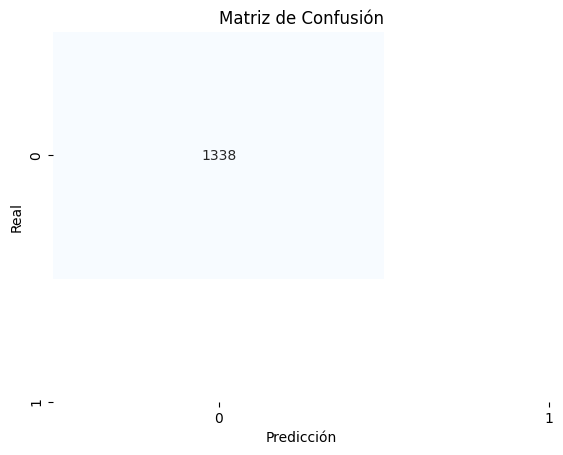

Vairbale:  Sin Textura
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


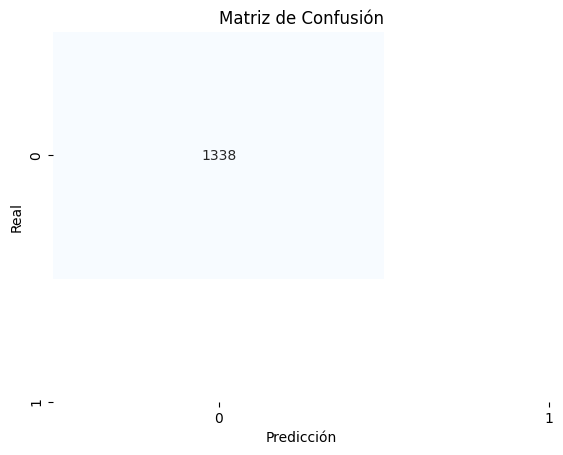

Vairbale:  Caponeo
Presicion:  0.9970194409656293 Recall 0.9966390190723445 f1 0.9966390190723445
[1328    0]


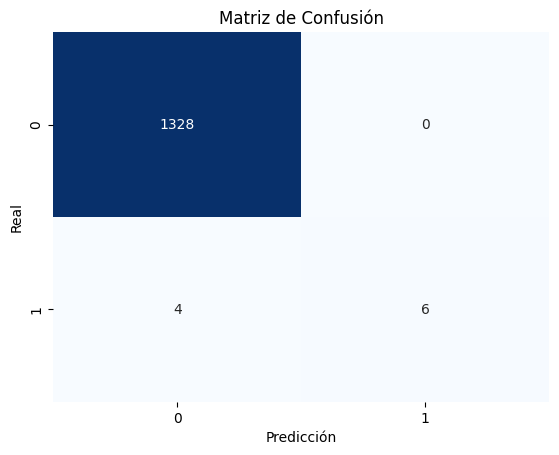

Vairbale:  Machete
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


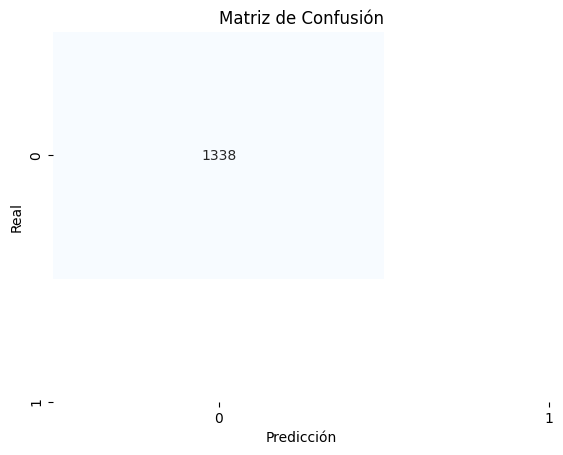

Vairbale:  Mal Asentada
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


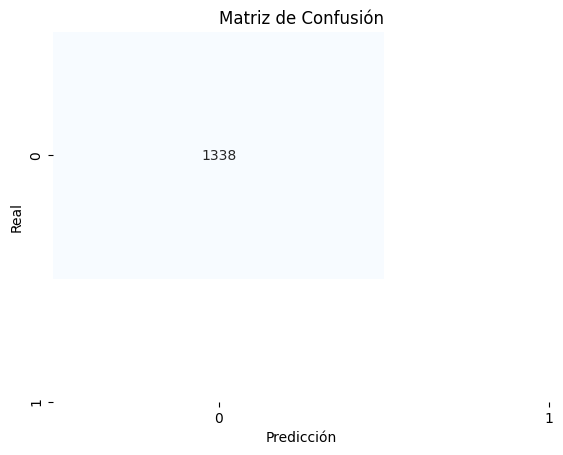

Vairbale:  Material
Presicion:  0.9513865821476682 Recall 0.9487459285234554 f1 0.9487459285234554
[154  57]


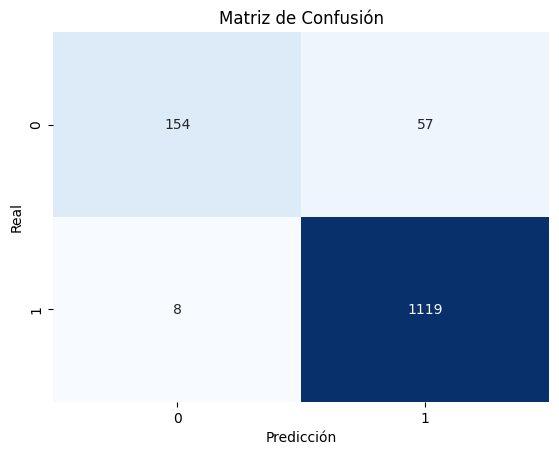

Vairbale:  Daño Tren
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


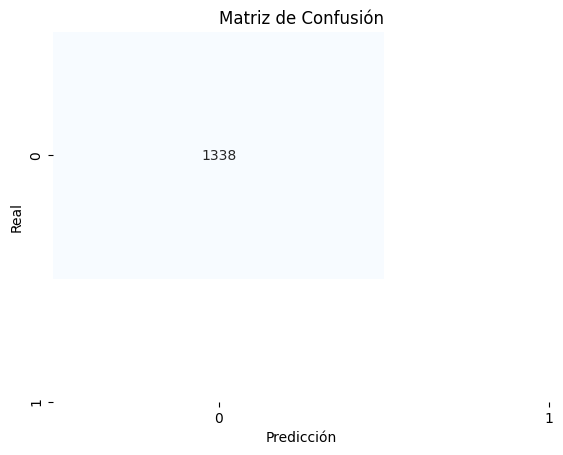

Vairbale:  Roto
Presicion:  0.94647256878249 Recall 0.9467110000039143 f1 0.9467110000039143
[1086   25]


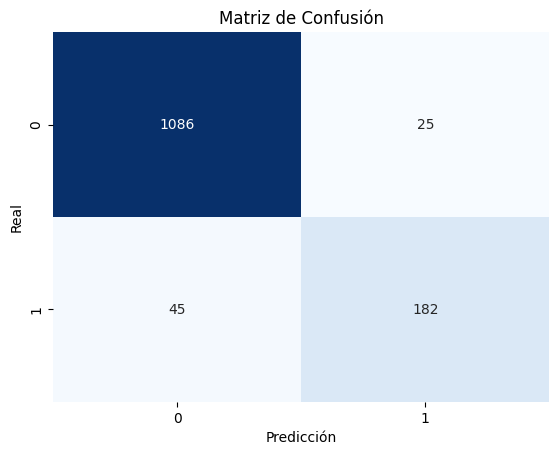

Vairbale:  Delaminada
Presicion:  0.9231458769567371 Recall 0.9230776311934153 f1 0.9230776311934153
[822  53]


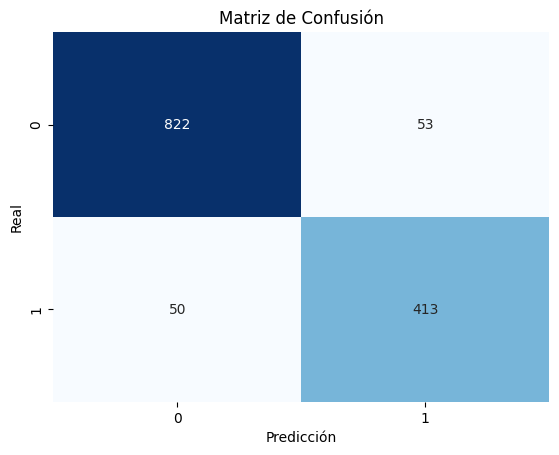

Vairbale:  Dimensiones
Presicion:  0.9962771595572241 Recall 0.9959205947674394 f1 0.9959205947674394
[1322    0]


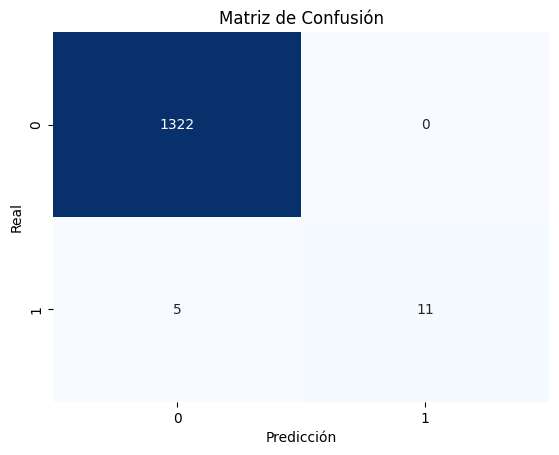

Vairbale:  Desborde
Presicion:  0.9522717029761754 Recall 0.9494859886113718 f1 0.9494859886113718
[745  58]


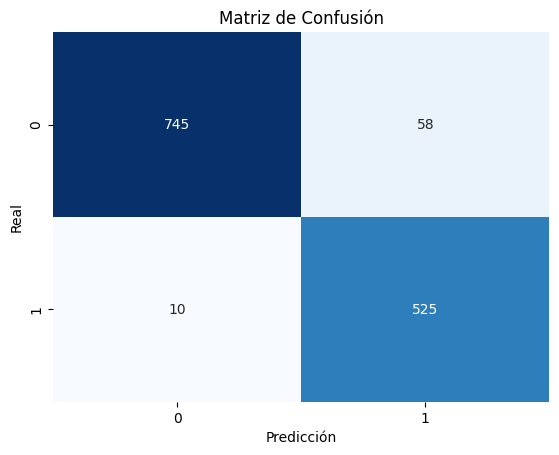

Vairbale:  Ondulación
Presicion:  0.9431265057001557 Recall 0.9421941956204405 f1 0.9421941956204405
[748  22]


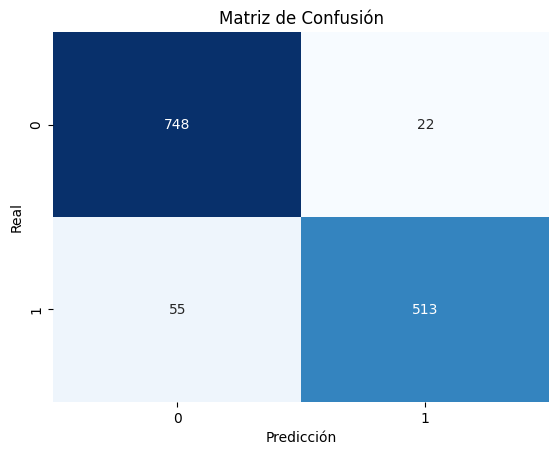

Vairbale:  Burbuja
Presicion:  0.9345321183755625 Recall 0.9347015388871528 f1 0.9347015388871528
[949  39]


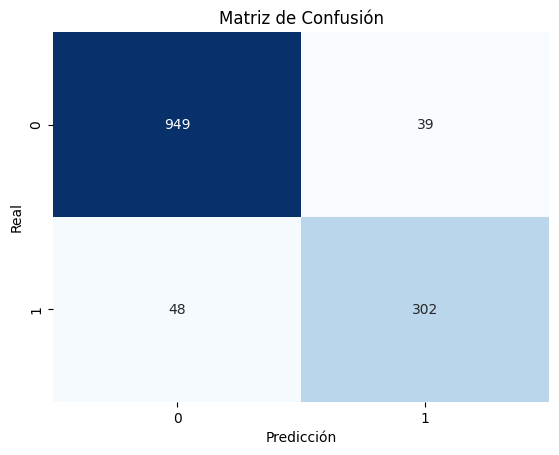

Vairbale:  Trasparente
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


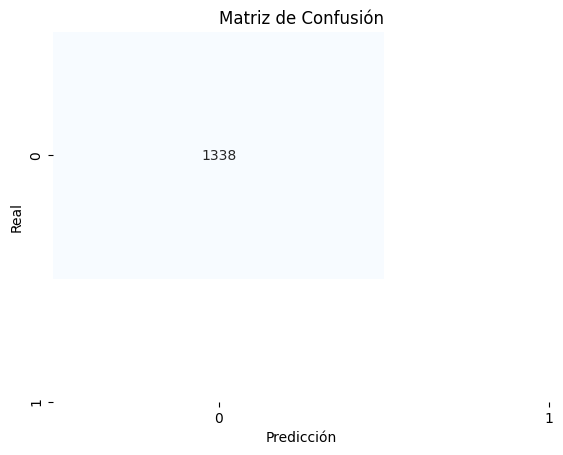

Vairbale:  Maquina
Presicion:  0.9727246324325667 Recall 0.9723449804034445 f1 0.9723449804034445
[68 28]


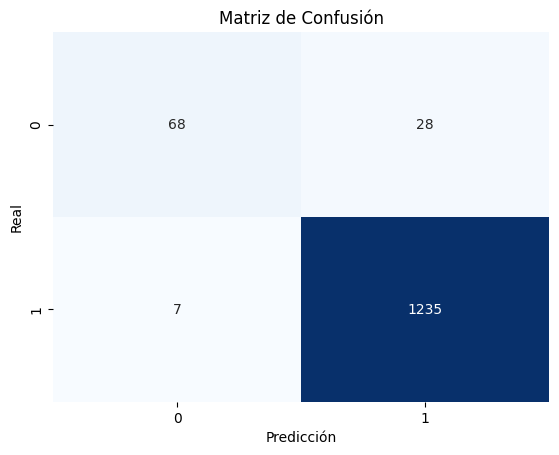

Vairbale:  Quemado
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


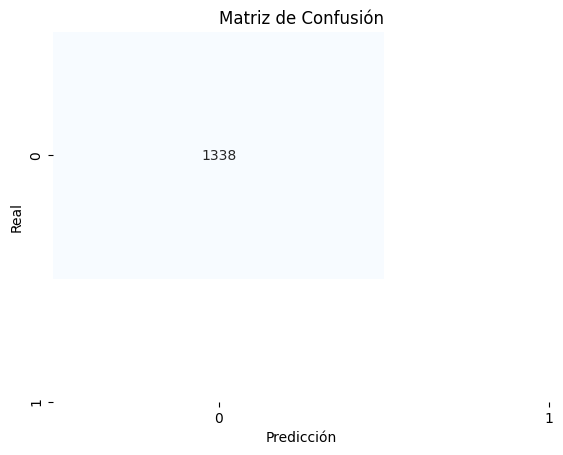

Vairbale:  Pandeo
Presicion:  0.997019414086625 Recall 0.996265320254671 f1 0.996265320254671
[1332    0]


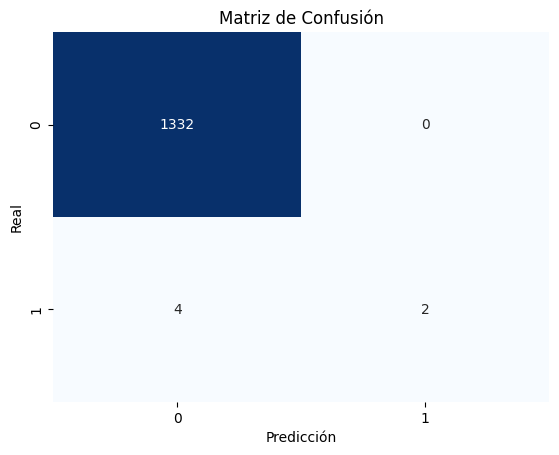

Vairbale:  Carpas
Presicion:  1.0 Recall 1.0 f1 1.0
[1337    0]


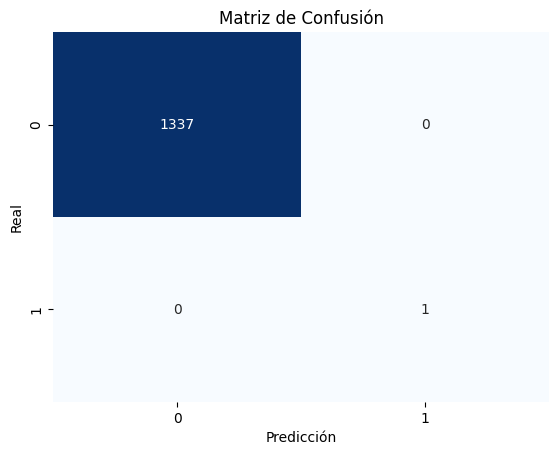

Vairbale:  Arruga
Presicion:  0.9977629088258815 Recall 0.9975989605388405 f1 0.9975989605388405
[1326    0]


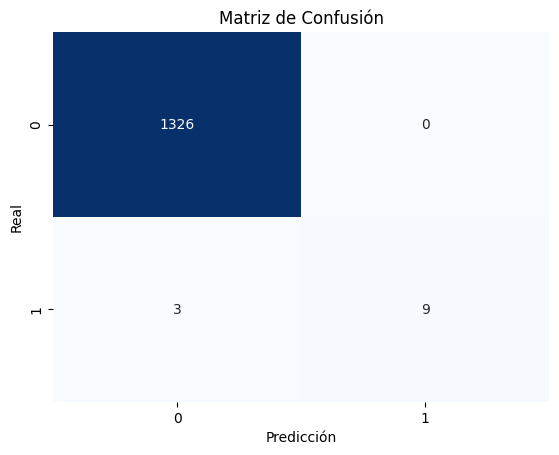

Vairbale:  Rajada
Presicion:  0.9842160494535113 Recall 0.98301979109154 f1 0.98301979109154
[1272    1]


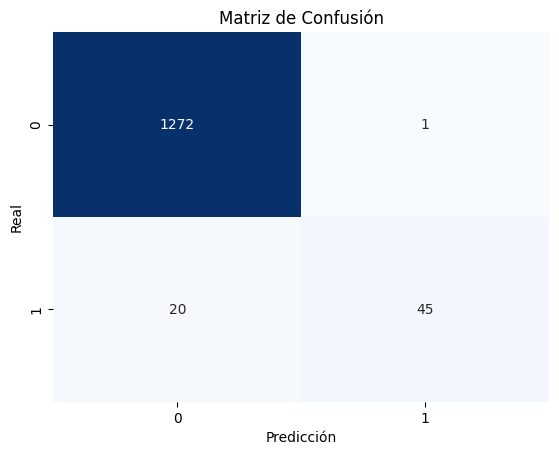

Vairbale:  Tallon
Presicion:  0.6636073362963105 Recall 0.4517531893780509 f1 0.4517531893780509
[735  10]


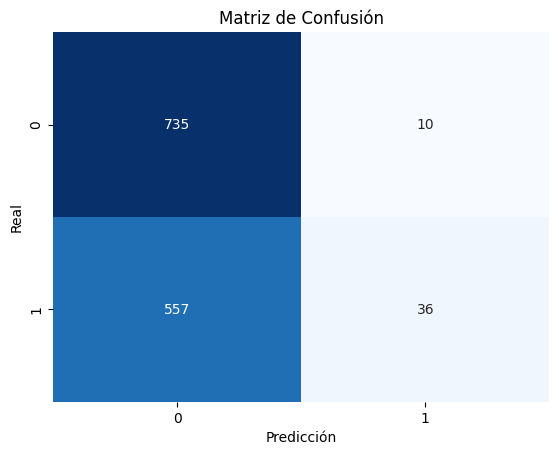

Vairbale:  Crudo
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


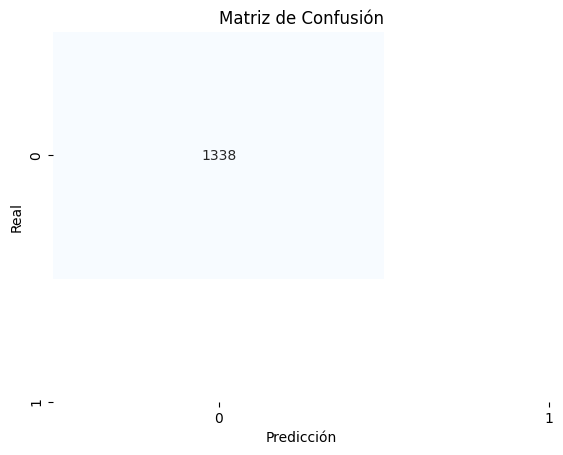

Vairbale:  Daño
Presicion:  0.9970126977104797 Recall 0.9977584065344964 f1 0.9977584065344964
[1336    0]


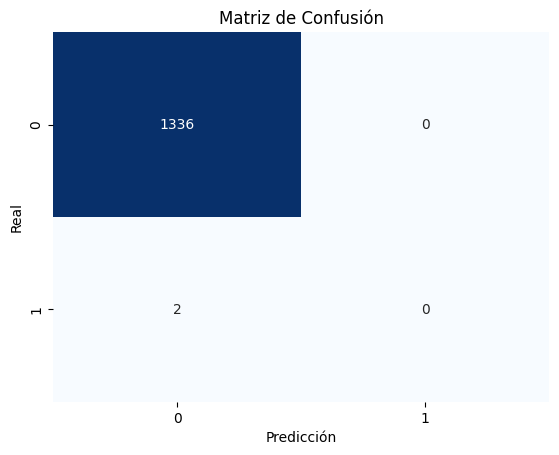

Vairbale:  Cuarteamineto
Fallo 'Cuarteamineto'
Vairbale:  Despunte
Presicion:  0.9590248701832204 Recall 0.9588683965267484 f1 0.9588683965267484
[599  34]


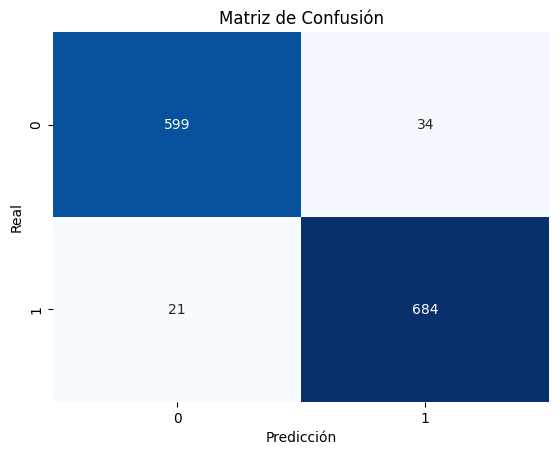

Vairbale:  Piel De Elefante
Presicion:  0.9587621977371544 Recall 0.95187327797252 f1 0.95187327797252
[1240    2]


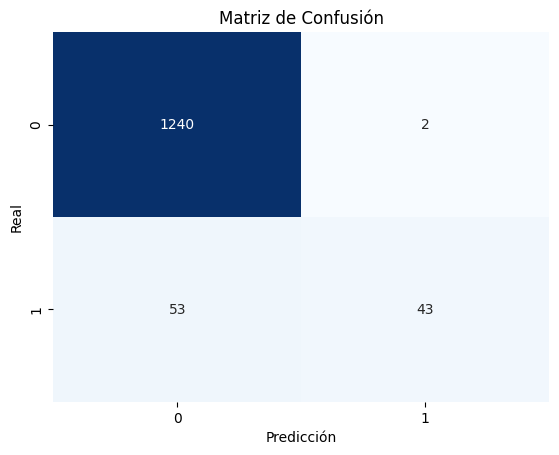

Vairbale:  Pegada
Presicion:  0.9918470775247359 Recall 0.9906365177030476 f1 0.9906365177030476
[1313    0]


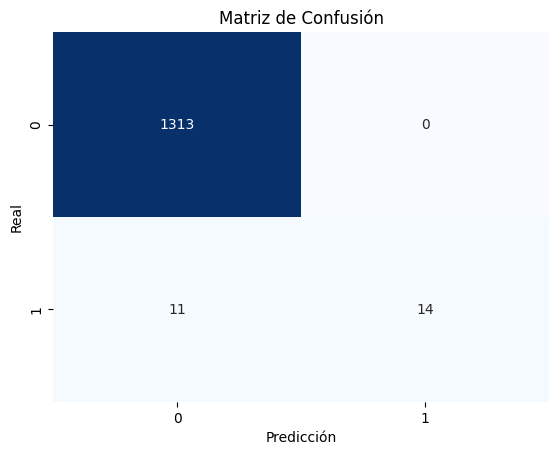

Vairbale:  Mal Corte
Presicion:  0.9804409263932511 Recall 0.9783266950765489 f1 0.9783266950765489
[1275    1]


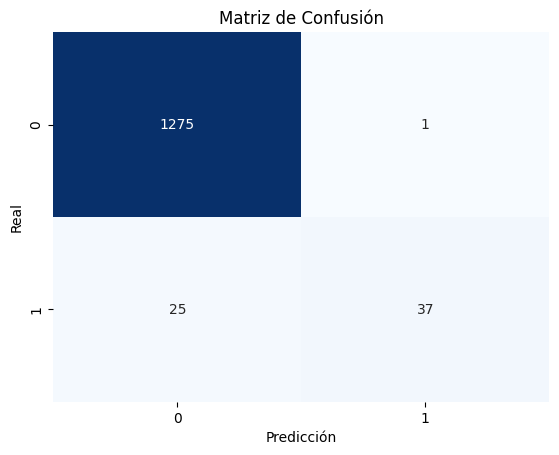

Vairbale:  Basura
Presicion:  0.9306760215532638 Recall 0.9304968067398826 f1 0.9304968067398826
[626  53]


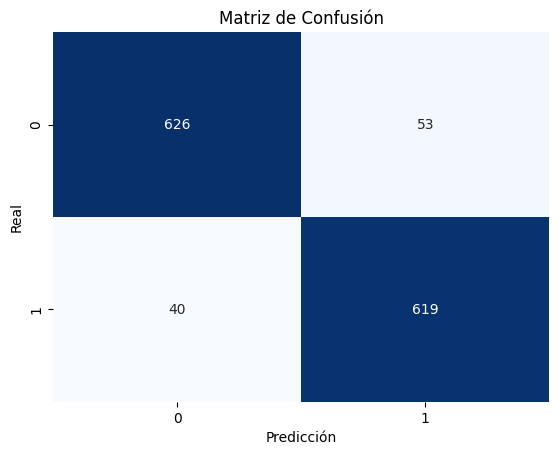

Vairbale:  Otros
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


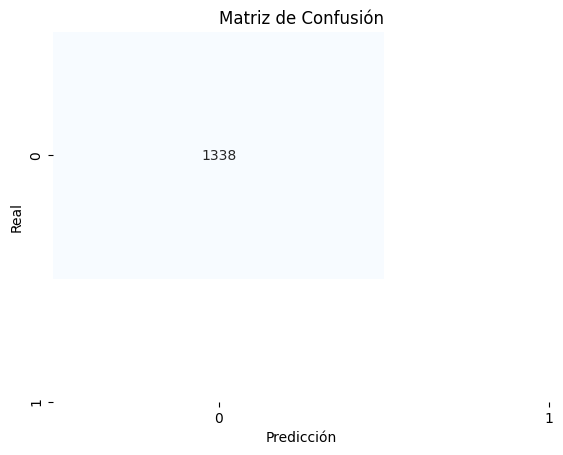

Vairbale:  Flexible
Presicion:  0.9962770856724105 Recall 0.9955479487986908 f1 0.9955479487986908
[1329    0]


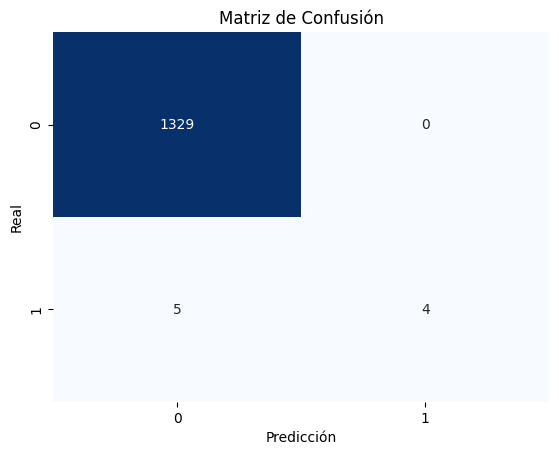

Vairbale:  Desplazada
Presicion:  0.9937456995752959 Recall 0.9935294650541286 f1 0.9935294650541286
[1316    1]


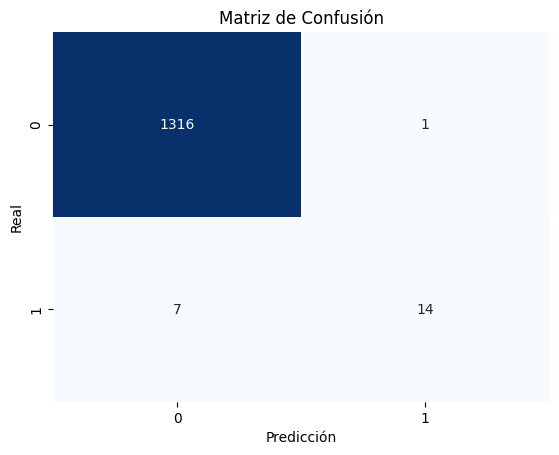

Vairbale:  Desmoldeo
Presicion:  0.9921521327692306 Recall 0.9922328969702765 f1 0.9922328969702765
[1308    3]


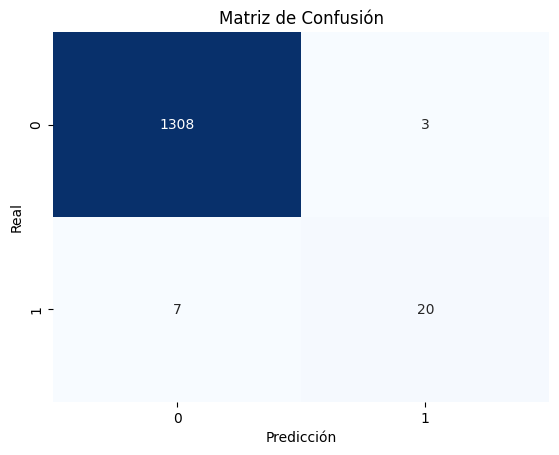

Vairbale:  Golpe
Presicion:  0.9977628936382077 Recall 0.9975004005809818 f1 0.9975004005809818
[1330    0]


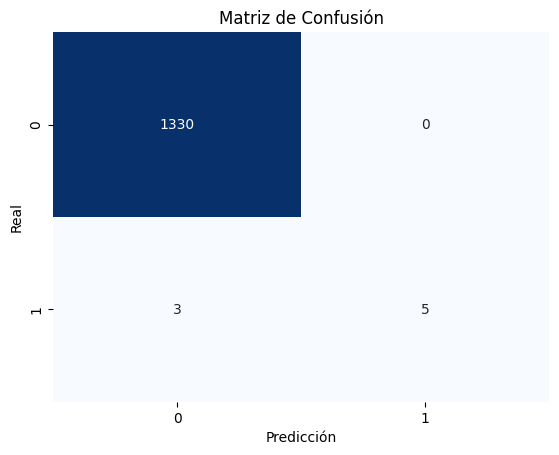

Vairbale:  Esquinas Levantadas
Presicion:  0.9992531748454083 Recall 0.9991281916211331 f1 0.9991281916211331
[1336    0]


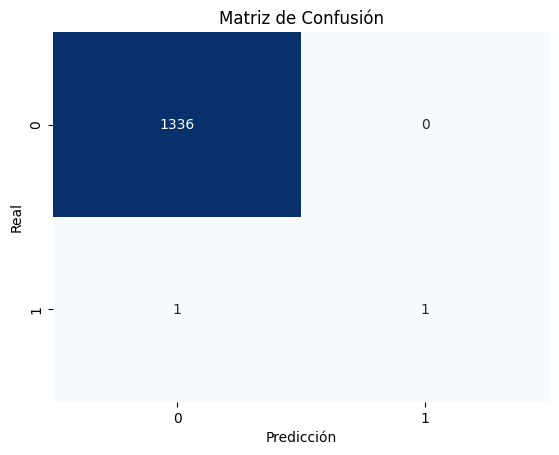

Vairbale:  Daño Estiba
Presicion:  0.9865470852017937 Recall 0.9865470852017937 f1 0.9865470852017937
[1194    9]


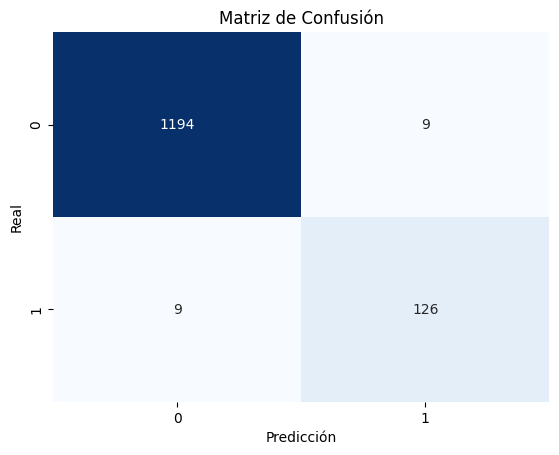

Vairbale:  Ensayos
Fallo 'Ensayos'
Vairbale:  Mal Perforado
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


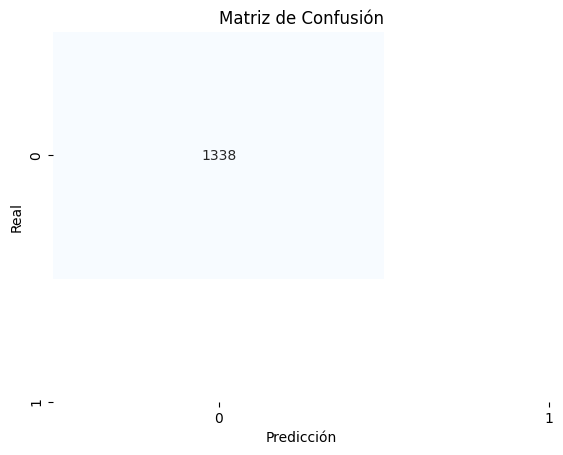

Vairbale:  Tallon
Presicion:  0.9561762386265826 Recall 0.9559493288041049 f1 0.9559493288041049
[709  36]


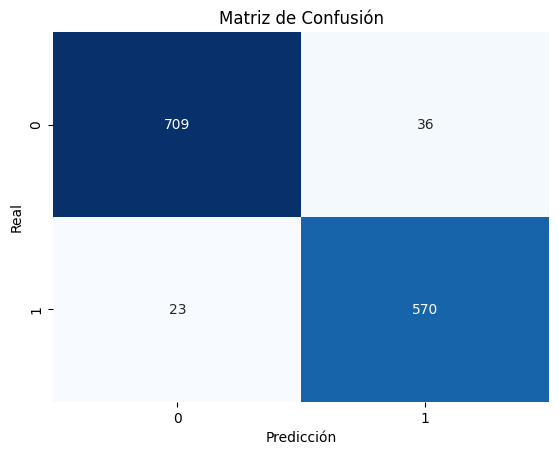

Vairbale:  Mancha
Presicion:  0.9293070877514398 Recall 0.9291252376449047 f1 0.9291252376449047
[828  51]


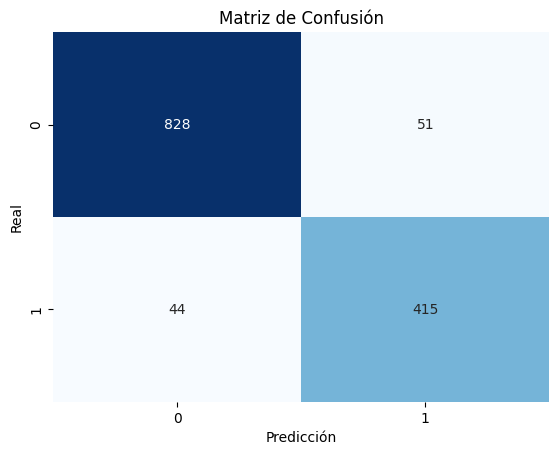

Vairbale:  Placa Fresca
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


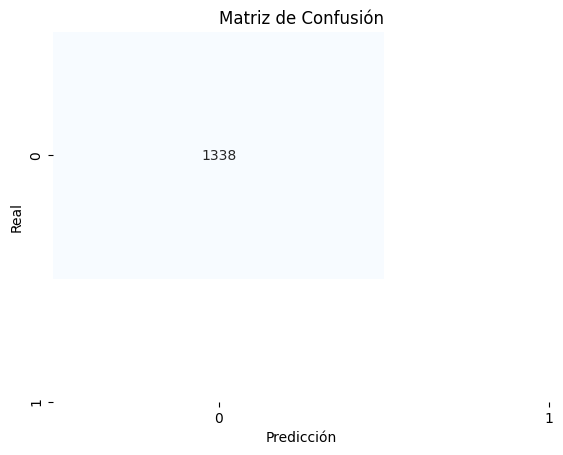

Vairbale:  Sin Pulir
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


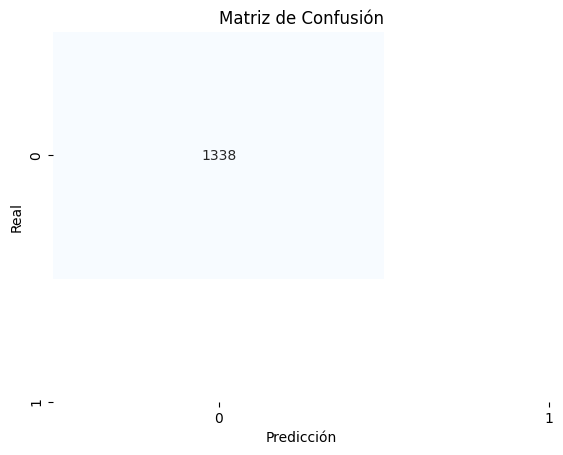

In [74]:
split = BestModel(dfx_aut_nc_m1, dfy_aut_nc_m1)
split.split_data()
dict_choose_labels = {'column':[],'precision':[],
                      'recall':[],'FPR':[],'FNR':[],'f1':[],'TP':[],'TN':[],'FP':[],'FN':[]}

for file in os.listdir('best-aut-m1-2'):
    if '.joblib' in file:
        print("Vairbale: ",file.split("_")[0])
        try:

            idx = split.dfy.columns.get_loc(file.split("_")[0])
        
            y_test = split.y_test[:,idx]
            
            
            model = joblib.load('best-aut-m1-2/'+file)
            y_pred = model.predict(split.X_test)
    
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            print("Presicion: ",precision,"Recall",f1,"f1",f1)
            
            cm = confusion_matrix(y_test, y_pred)
            print(cm[0,])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['0', '1'],
                        yticklabels=['0', '1'])
    
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.show()

            dict_choose_labels['column'].append(file.split("_")[0])
            dict_choose_labels['precision'].append(precision)
            dict_choose_labels['recall'].append(recall)
            dict_choose_labels['f1'].append(f1)

            try:
                fpr = cm[0,1]/(cm[0,1]+cm[0,0])
                fnr = cm[1,0]/(cm[1,1]+cm[1,0])
                dict_choose_labels['FPR'].append(fpr)
                dict_choose_labels['FNR'].append(fnr)
                dict_choose_labels['TP'].append(cm[1,1])
                dict_choose_labels['TN'].append(cm[0,0])
                dict_choose_labels['FP'].append(cm[0,1])
                dict_choose_labels['FN'].append(cm[1,0])

            except:
                dict_choose_labels['FPR'].append(1)
                dict_choose_labels['FNR'].append(1)
                dict_choose_labels['TP'].append(0)
                dict_choose_labels['TN'].append(0)
                dict_choose_labels['FP'].append(0)
                dict_choose_labels['FN'].append(0)
        
        except Exception as err:
            print("Fallo", err)

In [44]:
len(dfy_aut_nc_m1.columns)

57

In [39]:
for key in dict_choose_labels:
    print("key: ",key,len(dict_choose_labels[key]))

key:  column 26
key:  precision 26
key:  recall 26
key:  FPR 26
key:  FNR 26
key:  f1 26
key:  TP 26
key:  TN 26
key:  FP 26
key:  FN 26


In [49]:
df_choose_labels_aut = pd.DataFrame(dict_choose_labels)
df_choose_labels_aut

column  precision  recall  FPR  FNR   f1    TP    TN  FP  FN
0    Mal Ondulada       1.00    1.00 0.00 0.00 1.00    11  1327   0   0
1       Daño Tren       1.00    1.00 1.00 1.00 1.00     0     0   0   0
2            Daño       1.00    1.00 0.00 1.00 1.00     0  1336   0   2
3         Espesor       0.96    0.96 0.01 0.22 0.96   151  1136   9  42
4          Rajada       0.99    0.99 0.01 0.11 0.99    58  1265   8   7
5          Tallon       0.96    0.96 0.05 0.03 0.96   575   707  38  18
6            Roto       0.95    0.95 0.02 0.20 0.95   182  1087  24  45
7      Descolgada       0.96    0.96 0.03 0.17 0.96   114  1168  32  24
8       Desmoldeo       1.00    1.00 0.00 0.15 1.00    23  1309   2   4
9       Mal Corte       0.98    0.98 0.01 0.26 0.98    46  1261  15  16
10       Desborde       0.95    0.95 0.07 0.02 0.95   524   749  54  11
11       Material       0.95    0.95 0.25 0.01 0.95  1118   158  53   9
12  Desmoldeadora       1.00    1.00 0.00 0.15 1.00    11  1321   4   2
13   Manipulación       0.96    0.96 0.04 0.04 0.96   746   539  21  32
14         Fisura       0.94    0.94 0.17 0.02 0.94   954   308  61  15
15     Ondulación       0.94    0.94 0.03 0.10 0.94   511   748  22  57
16        Caponeo       1.00    1.00 0.00 0.30 1.00     7  1328   0   3
17        Maquina       0.96    0.96 0.21 0.02 0.96  1212    76  20  30
18          Otros       1.00    1.00 1.00 1.00 1.00     0     0   0   0
19         Basura       0.93    0.93 0.08 0.06 0.93   618   626  53  41
20     Desplazada       0.99    0.99 0.01 0.14 0.99    18  1310   7   3
21    Dimensiones       1.00    1.00 0.00 0.00 1.00    16  1321   1   0
22       Despunte       0.96    0.96 0.06 0.03 0.96   684   597  36  21
23           Nudo       0.90    0.90 0.10 0.10 0.90   657   549  59  73
24         Arruga       0.99    0.99 0.00 0.25 0.99     9  1322   4   3
25     Daño Molde       1.00    0.97 0.03 0.33 0.98     2  1291  44   1

In [48]:
df_choose_labels_aut_filter = df_choose_labels.loc[(df_choose_labels['TP']>100) | (df_choose_labels['FNR']<0.03)]
df_choose_labels_aut_filter.reset_index()

index        column  precision  recall  FPR  FNR   f1    TP    TN  FP  FN
0       0  Mal Ondulada       1.00    1.00 0.00 0.00 1.00    11  1327   0   0
1       3       Espesor       0.96    0.96 0.01 0.22 0.96   151  1136   9  42
2       5        Tallon       0.96    0.96 0.05 0.03 0.96   575   707  38  18
3       6          Roto       0.95    0.95 0.02 0.20 0.95   182  1087  24  45
4       7    Descolgada       0.96    0.96 0.03 0.17 0.96   114  1168  32  24
5      10      Desborde       0.95    0.95 0.07 0.02 0.95   524   749  54  11
6      11      Material       0.95    0.95 0.25 0.01 0.95  1118   158  53   9
7      13  Manipulación       0.96    0.96 0.04 0.04 0.96   746   539  21  32
8      14        Fisura       0.94    0.94 0.17 0.02 0.94   954   308  61  15
9      15    Ondulación       0.94    0.94 0.03 0.10 0.94   511   748  22  57
10     17       Maquina       0.96    0.96 0.21 0.02 0.96  1212    76  20  30
11     19        Basura       0.93    0.93 0.08 0.06 0.93   618   626  53  41
12     21   Dimensiones       1.00    1.00 0.00 0.00 1.00    16  1321   1   0
13     22      Despunte       0.96    0.96 0.06 0.03 0.96   684   597  36  21
14     23          Nudo       0.90    0.90 0.10 0.10 0.90   657   549  59  73

# Mejor modelo aut m1 sin algunos predictores

In [134]:
#Carga de datos tanto de la maquina 1

dfx_aut_nc_m1 = pd.read_csv('aut-data-without-variables/dfx_aut_nc_m1.csv')
dfy_aut_nc_m1 = pd.read_csv('aut-data-without-variables/dfy_aut_nc_m1.csv')

In [135]:
dfx_aut_nc_m1.columns

Index(['PP_Hidro_Cemento_Kg', 'PP_Hidro_Carbonato_Kg', 'PP_Hidro_Silice_Kg',
       'PP_Hidro_Celulosa_Kg', 'PP_Hidro_Hidroxido_Kg', 'PP_Hidro_SolReales_%',
       'PP_Hidro_CelulosaS_%', 'PP_Refi_EE_AMP', 'PP_Refi_CelulosaH_%',
       'PP_Refi_CelulosaS_%', 'PP_Refi_CelulosaSR_SR°',
       'PP_Maq_FlujoFloc_L/min', 'PP_Maq_Resi_ml', 'PP_Maq_Vueltas_N',
       'PP_Maq_Vel_m/min', 'PP_Maq_FormatoP_PSI',
       'PP_Maq_FlujoFlocForm_L/Placa', 'PP_Maq_VacíoCP_PulgadasHg',
       'PP_Maq_VacioSF_PulgadasHg', 'PP_Maq_Recir_%', 'PP_Maq_Fieltro_Dias',
       'PP_PF_Humedad_%', 'PP_PF_Espesor_mm', 'PP_PF_Dens_g/cm3',
       'PP_Maq_FlocCanalS_%', 'PP_Maq_FlocTkS_%', 'PP_Maq_FlocFormS_%',
       'PP_MaqTCE_Densidad_g/cm3', 'PP_Maq_TCES_%', 'PP_Maq_CilinS_%',
       'PP_Maq_Cono1S_%', 'PP_Maq_MolinoS_%', 'PP_Maq_P1H_%', 'PP_Maq_P3H_%'],
      dtype='object')

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


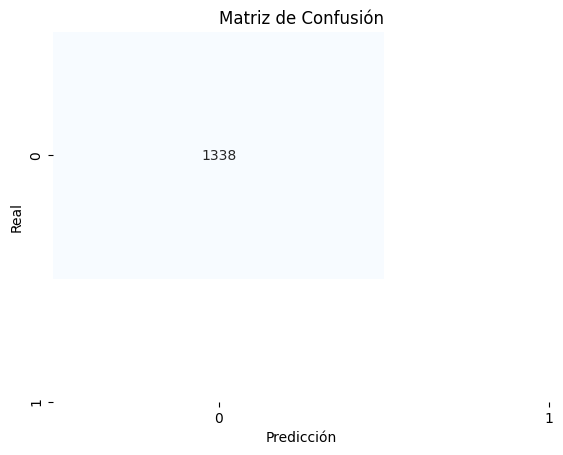

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9468281722185914 Recall 0.9456211442430024 f1 0.9456211442430024


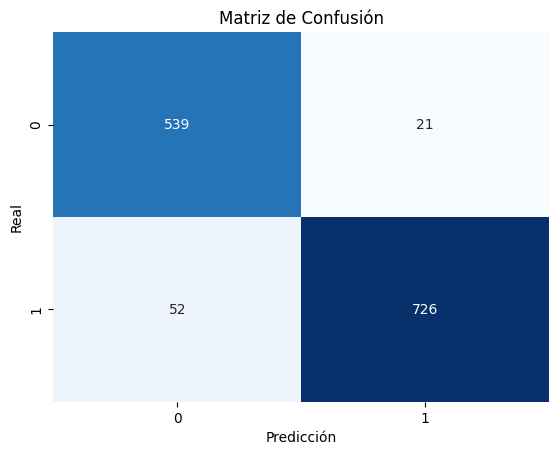

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9658424883924567 Recall 0.9637988669241112 f1 0.9637988669241112


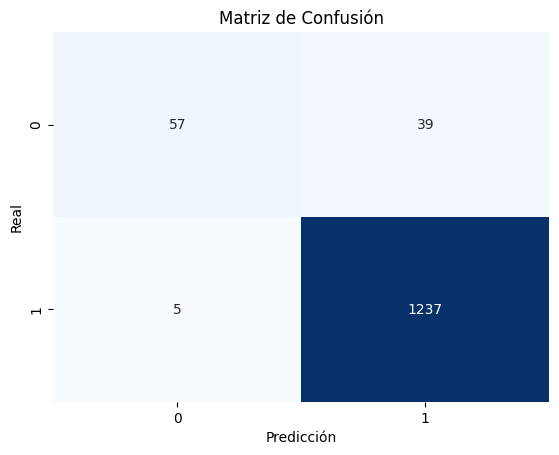

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.934392272862801 Recall 0.9314103672432998 f1 0.9314103672432998


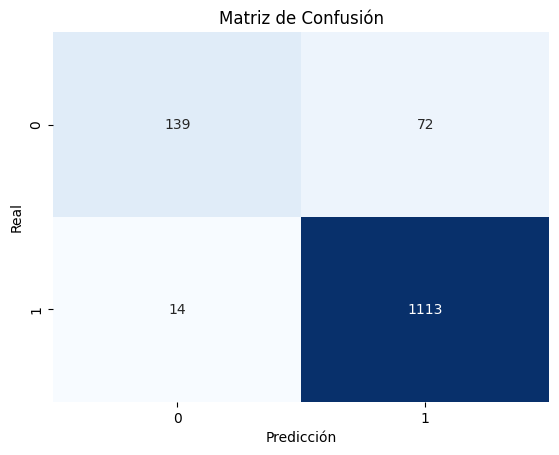

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9955207223149469 Recall 0.9966380295229325 f1 0.9966380295229325


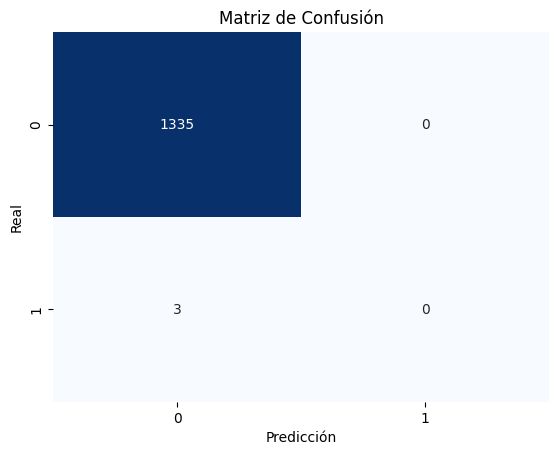

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9110635908395432 Recall 0.9110578565909488 f1 0.9110578565909488


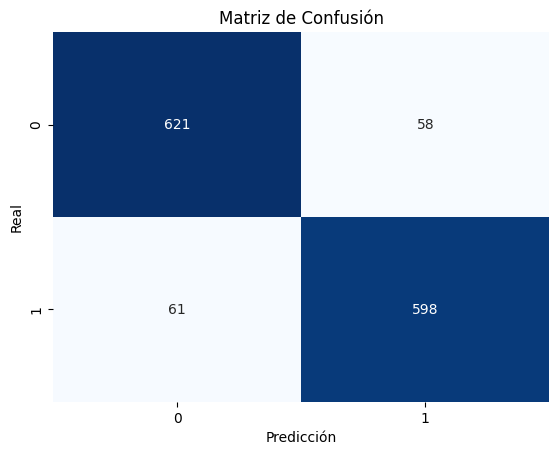

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.88152223589599 Recall 0.8812606063021897 f1 0.8812606063021897


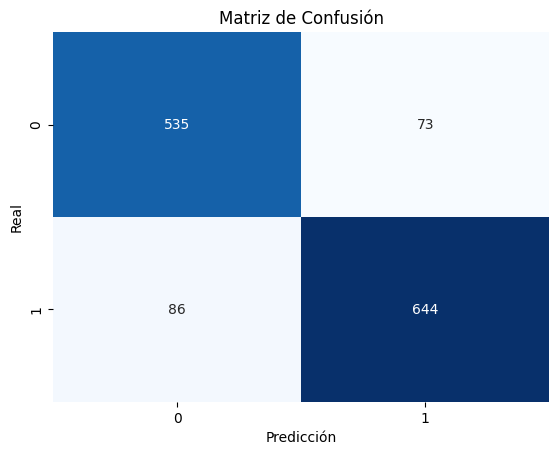

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9469431515441215 Recall 0.9393880830309963 f1 0.9393880830309963


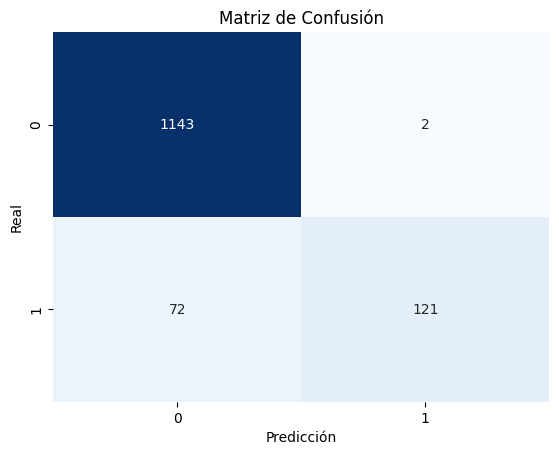

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9236963570897105 Recall 0.9208523352960457 f1 0.9208523352960457


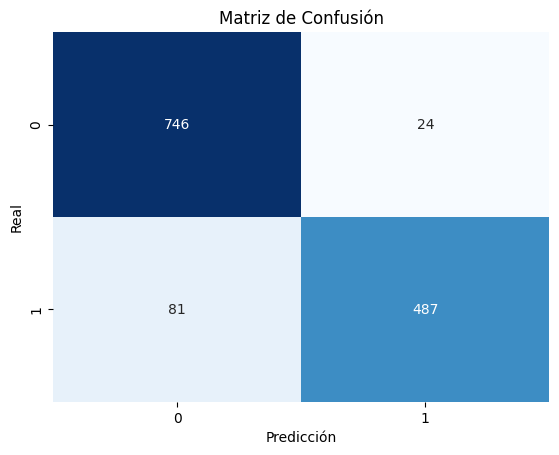

In [ ]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para las caracteristicas dadas

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

b_model = BestModel(dfx_aut_nc_m1, dfy_aut_nc_m1)
b_model.split_data()
joblib.dump(b_model.scaler, 'scaler-aut-m1-without-variables/scaler.joblib')

for col in dfy_aut_nc_m1.columns:
    b_model.grid_search_cv(col, extra_trees, param_grid, f'best-aut-m1-without-variables/{col}_aut_m1_best_extra_tree_classifier')

Vairbale:  Separador aut
Presicion:  0.960801038410011 Recall 0.9608911962891785 f1 0.9608911962891785
[1024   21]


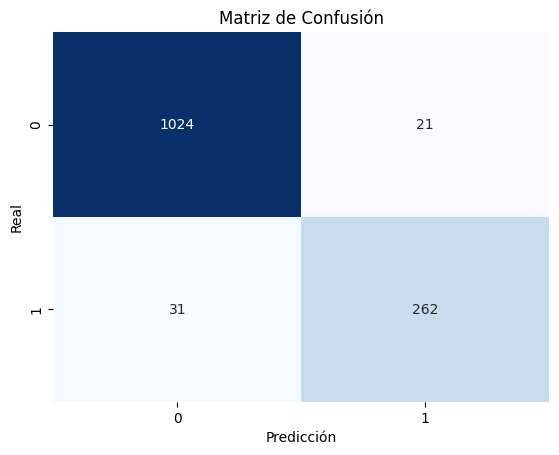

Vairbale:  Nudo aut
Presicion:  0.88152223589599 Recall 0.8812606063021897 f1 0.8812606063021897
[535  73]


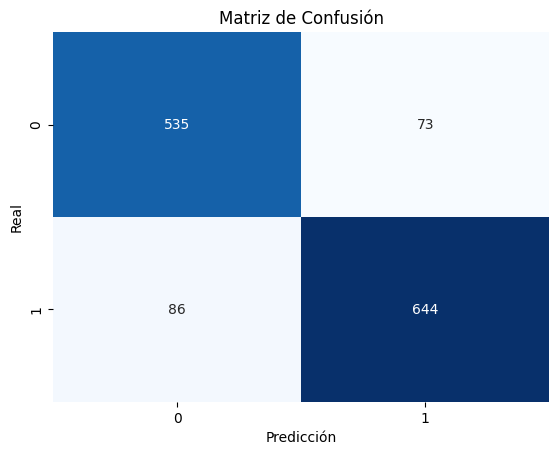

Vairbale:  Descolgada aut
Presicion:  0.9481814426267425 Recall 0.9432890125897824 f1 0.9432890125897824
[1194    6]


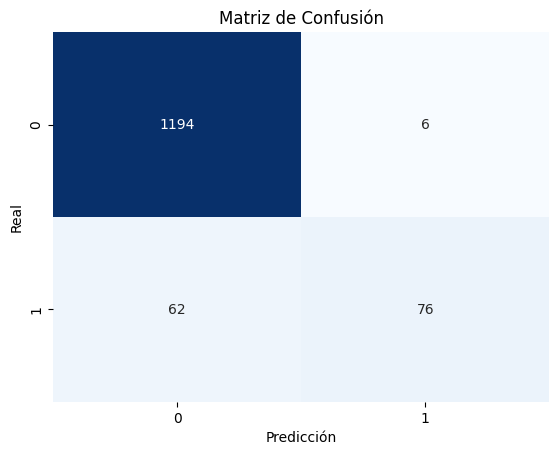

Vairbale:  Fisura aut
Presicion:  0.9343292067507313 Recall 0.9316492966875218 f1 0.9316492966875218
[296  73]


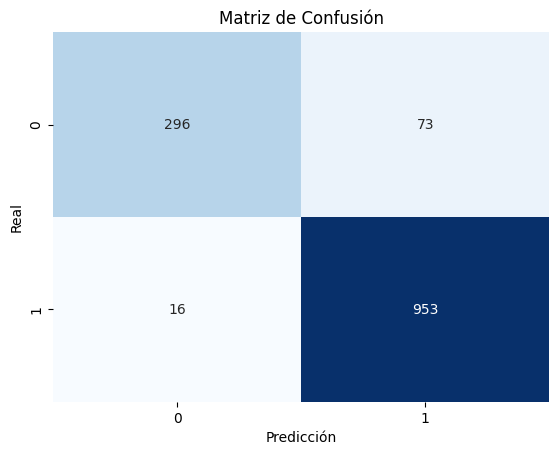

Vairbale:  Mal Ondulada aut
Presicion:  0.9947957635532009 Recall 0.9935544646724064 f1 0.9935544646724064
[1327    0]


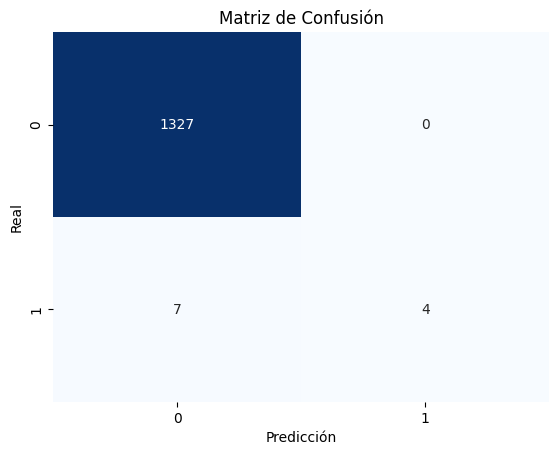

Vairbale:  Perdida De Grados aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


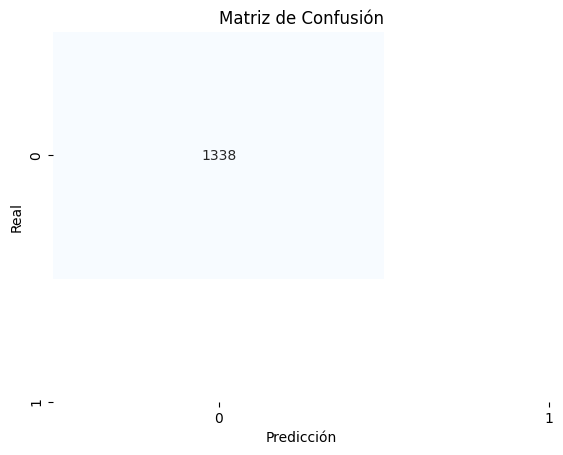

Vairbale:  Incrustaciones aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


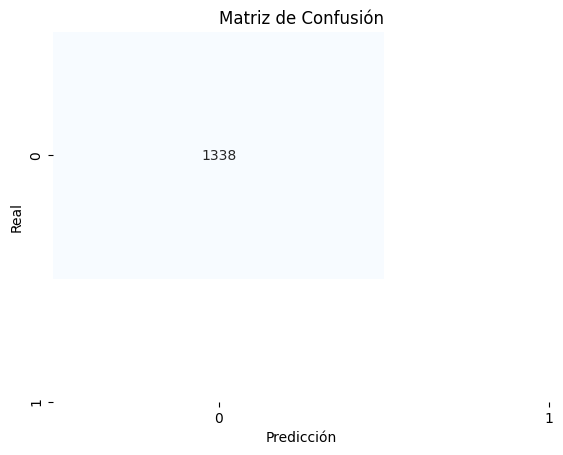

Vairbale:  Quebrada aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


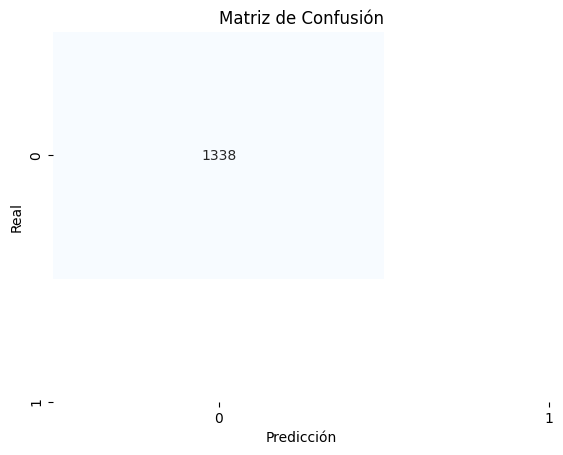

Vairbale:  Muestra aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


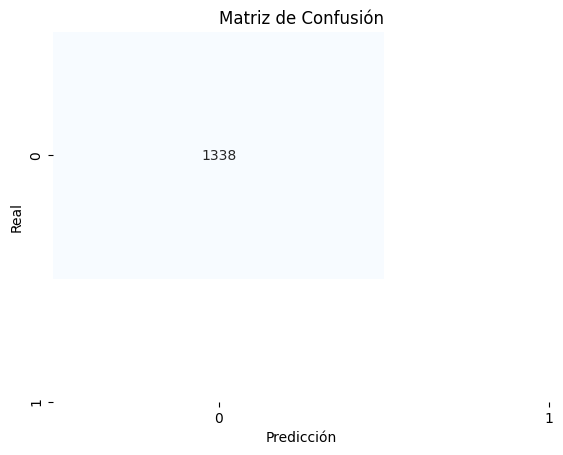

Vairbale:  Desmoldeadora aut
Presicion:  0.9901475831590931 Recall 0.9896164808035711 f1 0.9896164808035711
[1324    1]


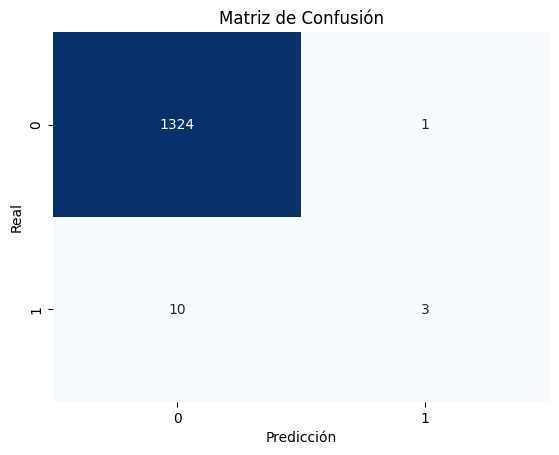

Vairbale:  Espesor aut
Presicion:  0.9469431515441215 Recall 0.9393880830309963 f1 0.9393880830309963
[1143    2]


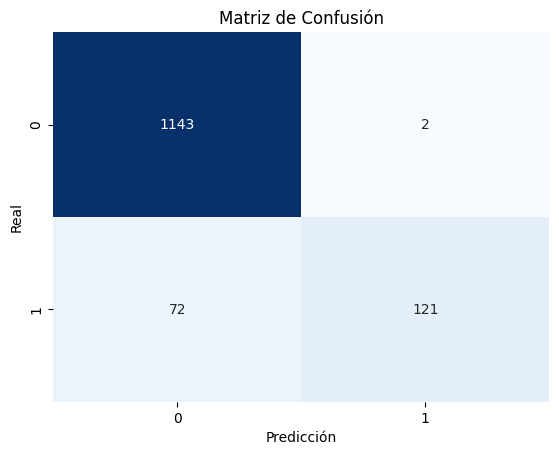

Vairbale:  Exceso Pecas
Fallo 'Exceso'
Vairbale:  Sello Litografico aut
Presicion:  0.9985057902721639 Recall 0.998879063464789 f1 0.998879063464789
[1337    0]


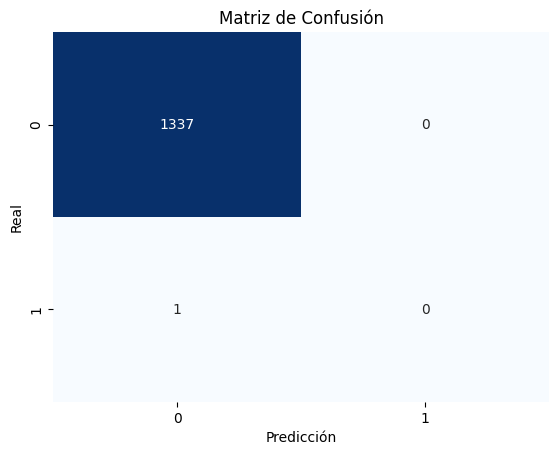

Vairbale:  Daño Molde aut
Presicion:  0.9955207223149469 Recall 0.9966380295229325 f1 0.9966380295229325
[1335    0]


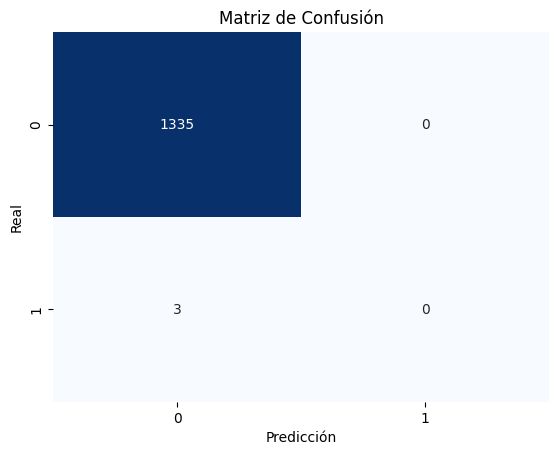

Vairbale:  Sin Texturizar
Fallo 'Sin'
Vairbale:  Manipulación aut
Presicion:  0.9468281722185914 Recall 0.9456211442430024 f1 0.9456211442430024
[539  21]


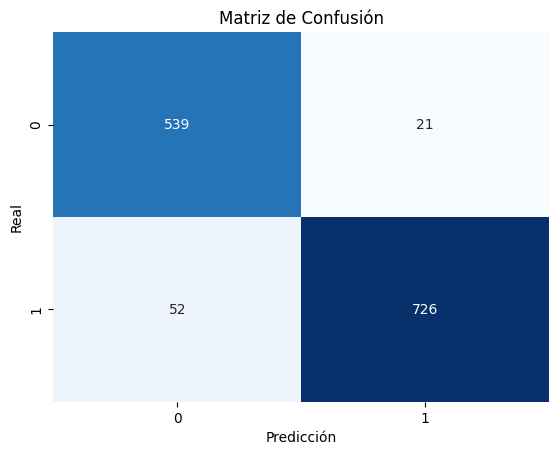

Vairbale:  Mal Pintada aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


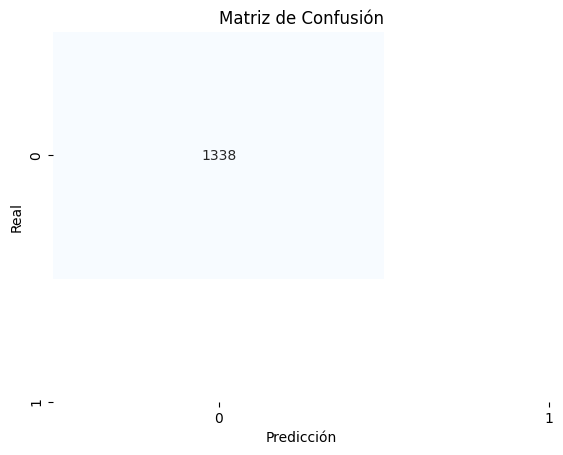

Vairbale:  Sin Textura aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


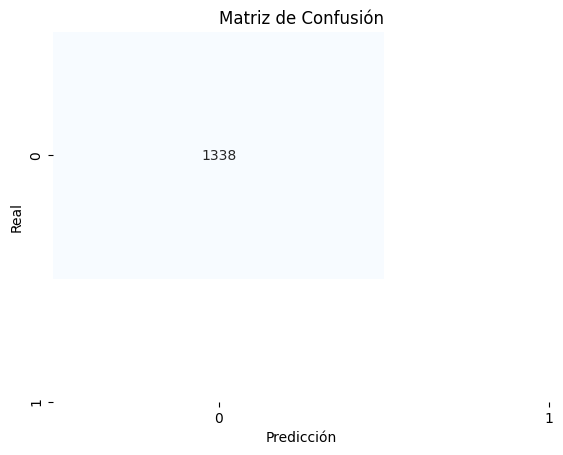

Vairbale:  Caponeo aut
Presicion:  0.9962770961798747 Recall 0.9956437699169031 f1 0.9956437699169031
[1328    0]


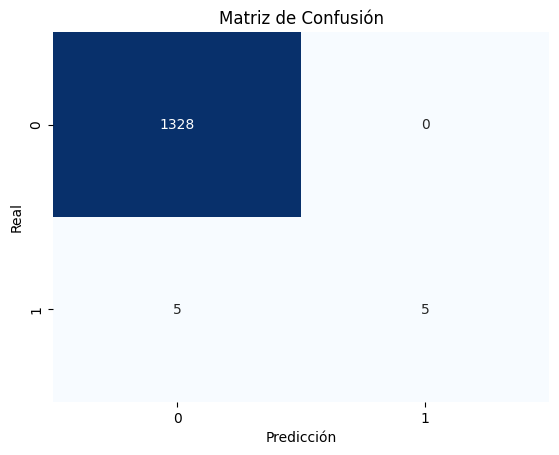

Vairbale:  Machete aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


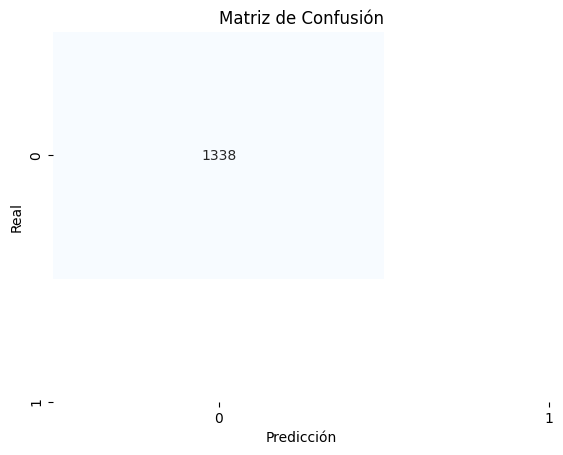

Vairbale:  Mal Asentada aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


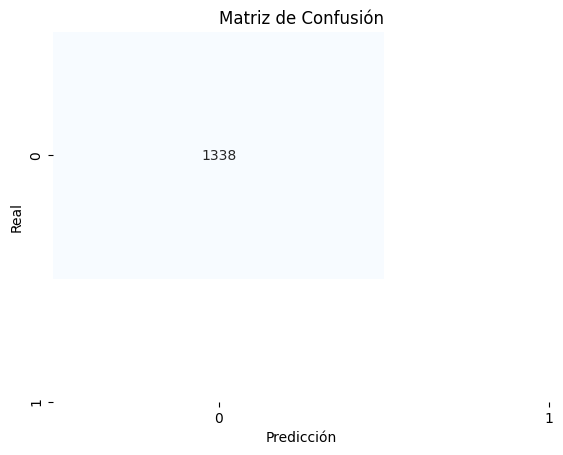

Vairbale:  Material aut
Presicion:  0.934392272862801 Recall 0.9314103672432998 f1 0.9314103672432998
[139  72]


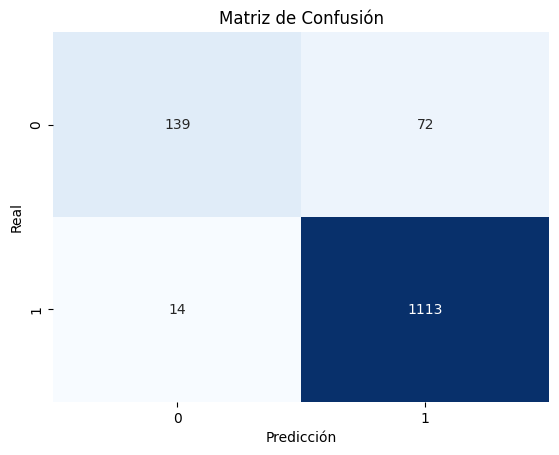

Vairbale:  Daño Tren aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


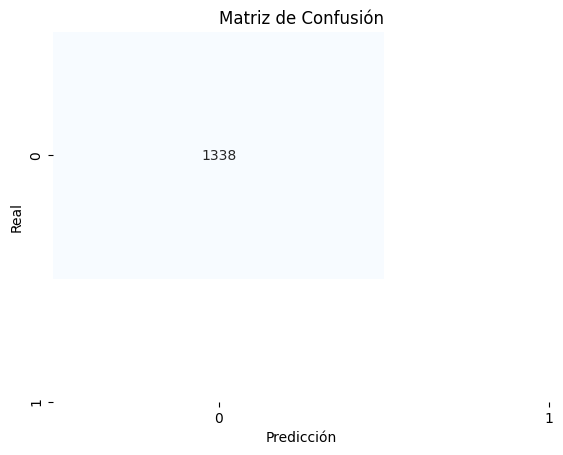

Vairbale:  Roto aut
Presicion:  0.9287976319019583 Recall 0.9288278549287005 f1 0.9288278549287005
[1083   28]


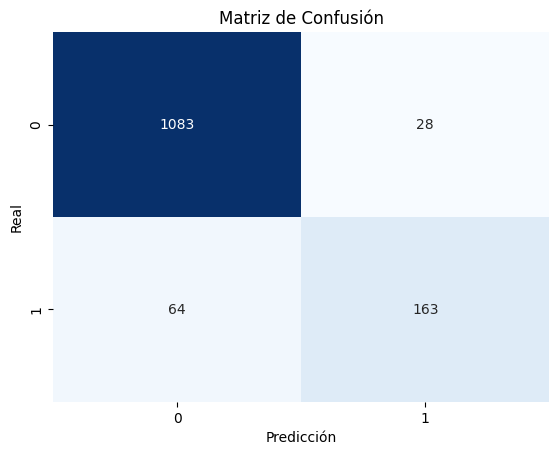

Vairbale:  Delaminada aut
Presicion:  0.8985778471522414 Recall 0.8979847707262989 f1 0.8979847707262989
[827  48]


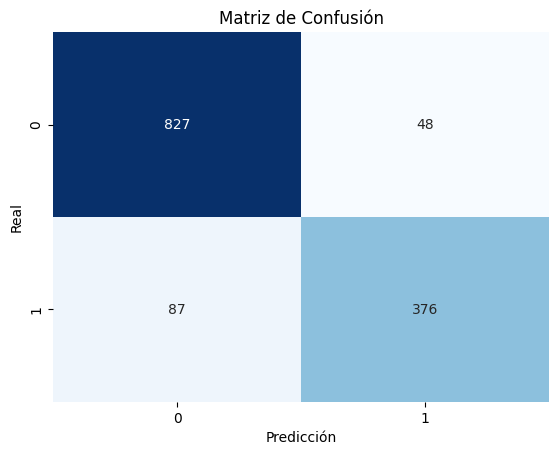

Vairbale:  Dimensiones aut
Presicion:  0.9947958668362761 Recall 0.994042781611023 f1 0.994042781611023
[1322    0]


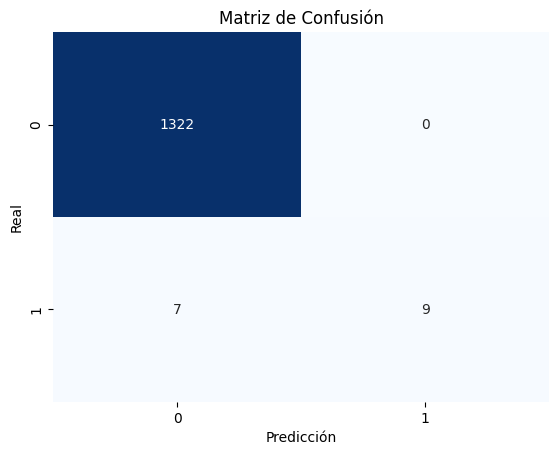

Vairbale:  Desborde aut
Presicion:  0.9397995620846459 Recall 0.936863623775484 f1 0.936863623775484
[736  67]


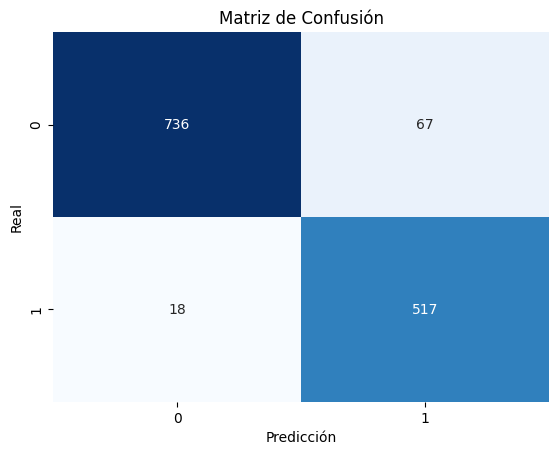

Vairbale:  Ondulación aut
Presicion:  0.9236963570897105 Recall 0.9208523352960457 f1 0.9208523352960457
[746  24]


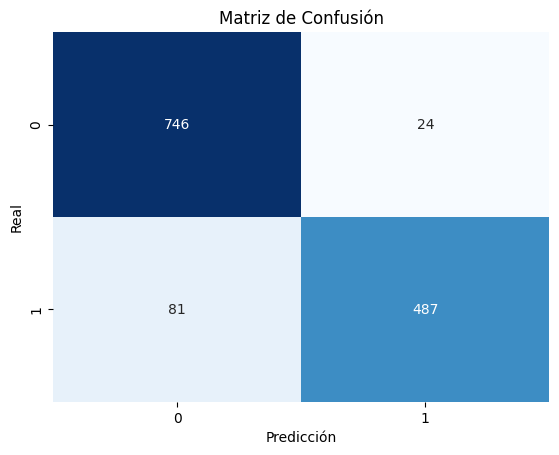

Vairbale:  Burbuja aut
Presicion:  0.9088940134032312 Recall 0.9091664280417592 f1 0.9091664280417592
[941  47]


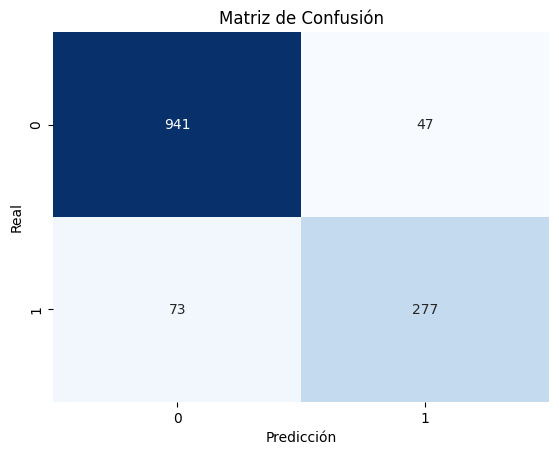

Vairbale:  Trasparente aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


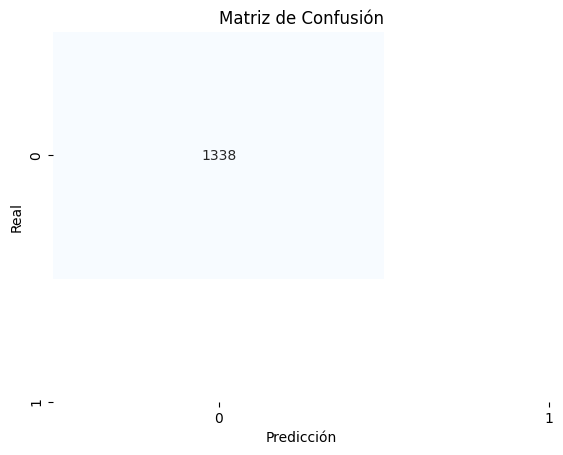

Vairbale:  Maquina aut
Presicion:  0.9658424883924567 Recall 0.9637988669241112 f1 0.9637988669241112
[57 39]


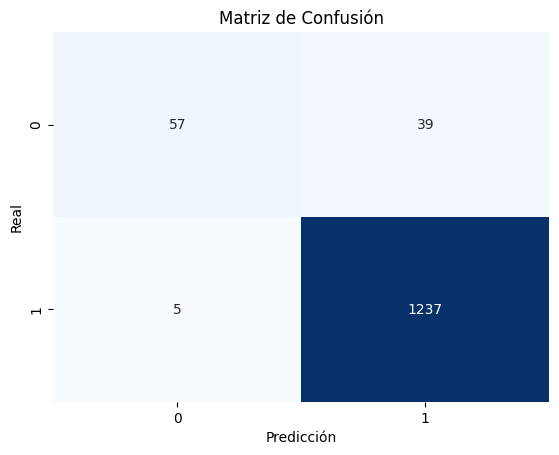

Vairbale:  Quemado aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


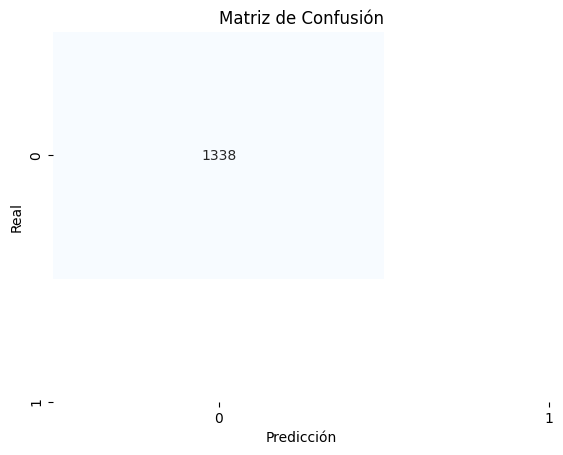

Vairbale:  Pandeo aut
Presicion:  0.997019414086625 Recall 0.996265320254671 f1 0.996265320254671
[1332    0]


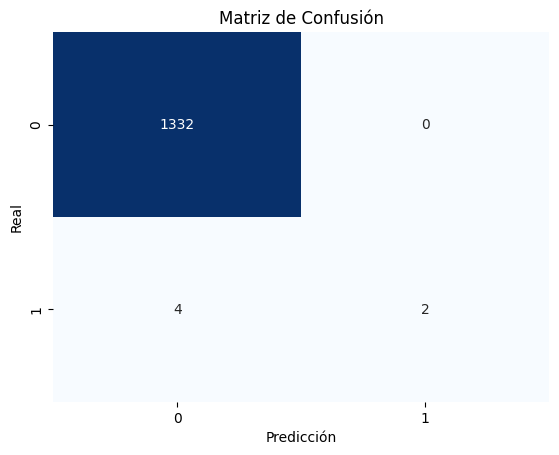

Vairbale:  Carpas aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1337    0]


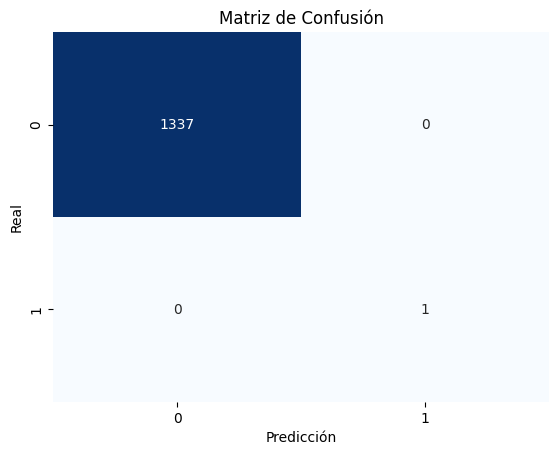

Vairbale:  Arruga aut
Presicion:  0.9970194544657609 Recall 0.9967137608730886 f1 0.9967137608730886
[1326    0]


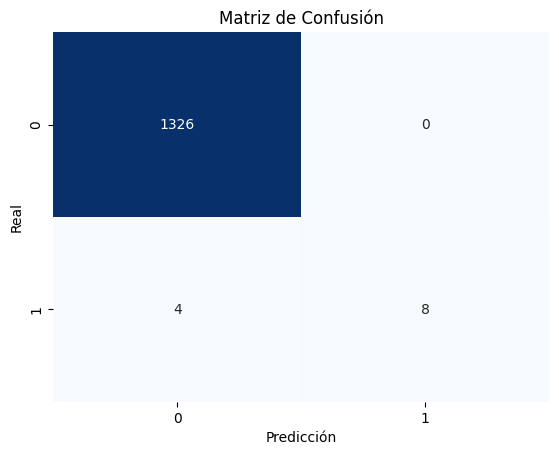

Vairbale:  Rajada aut
Presicion:  0.9745415129615155 Recall 0.9692002561275549 f1 0.9692002561275549
[1273    0]


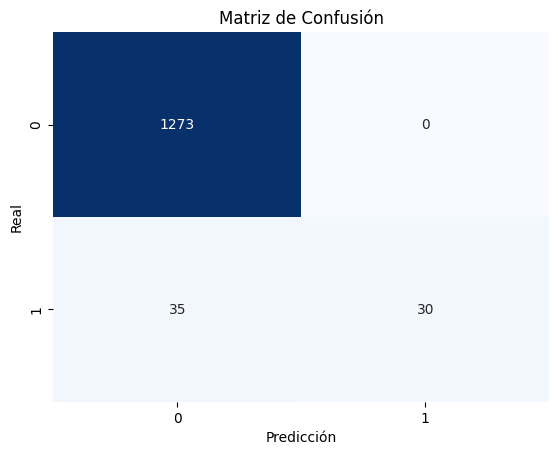

Vairbale:  Tallon Montacargas
Presicion:  0.6427977435000894 Recall 0.43263513880007476 f1 0.43263513880007476
[737   8]


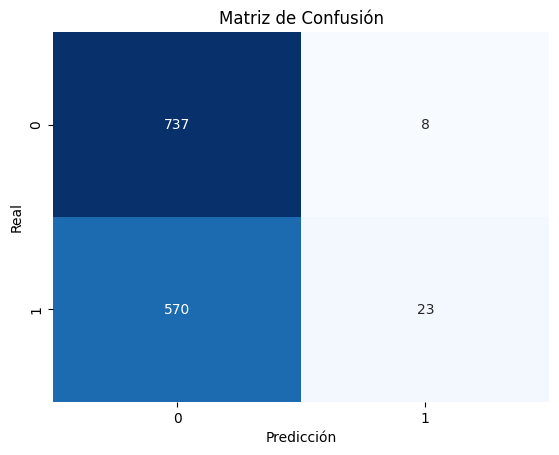

Vairbale:  Crudo aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


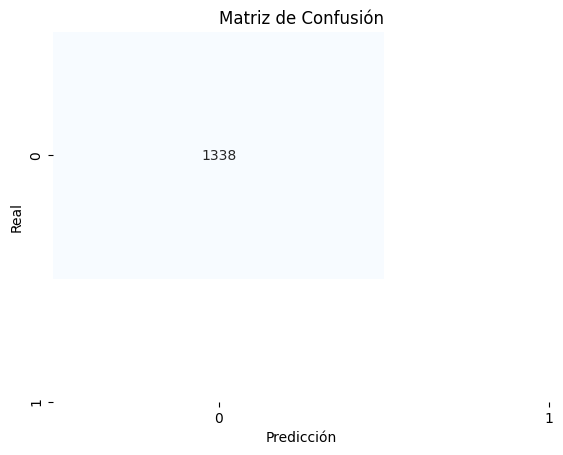

Vairbale:  Daño aut
Presicion:  0.9970126977104797 Recall 0.9977584065344964 f1 0.9977584065344964
[1336    0]


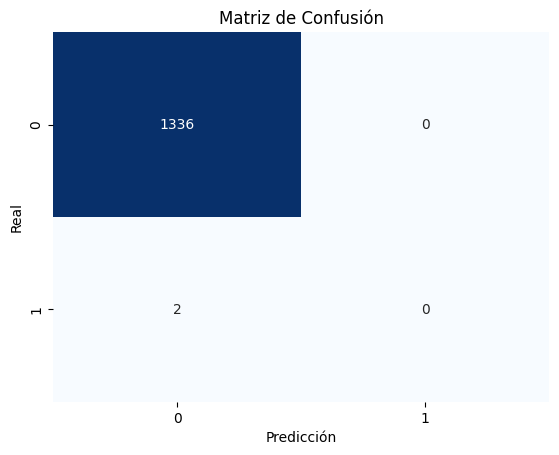

Vairbale:  Cuarteamineto Pintura
Fallo 'Cuarteamineto'
Vairbale:  Despunte aut
Presicion:  0.9439415737413003 Recall 0.9439391212258526 f1 0.9439391212258526
[594  39]


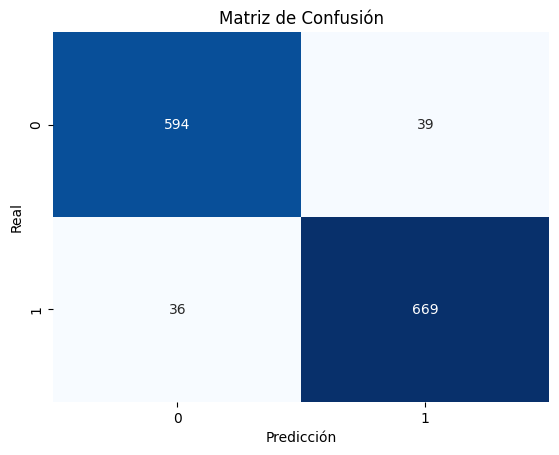

Vairbale:  Piel De Elefante aut
Presicion:  0.9500603392712661 Recall 0.936525019574347 f1 0.936525019574347
[1241    1]


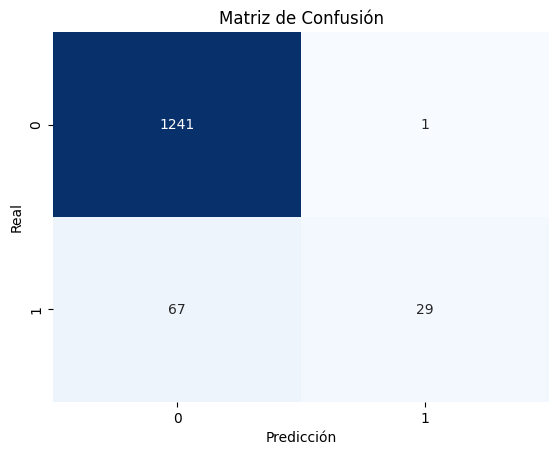

Vairbale:  Pegada aut
Presicion:  0.9874568708767435 Recall 0.984062694201499 f1 0.984062694201499
[1313    0]


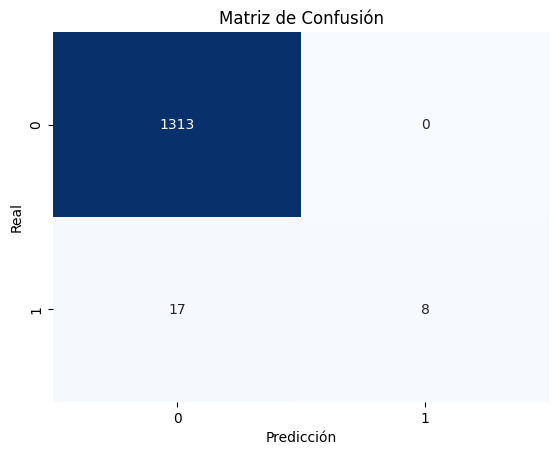

Vairbale:  Mal Corte aut
Presicion:  0.9720962646501292 Recall 0.9670964192916424 f1 0.9670964192916424
[1275    1]


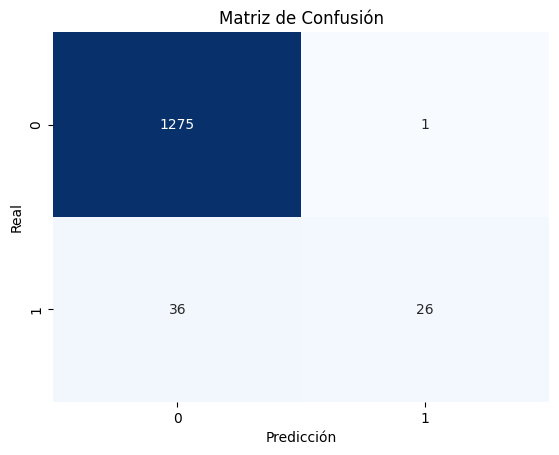

Vairbale:  Basura aut
Presicion:  0.9110635908395432 Recall 0.9110578565909488 f1 0.9110578565909488
[621  58]


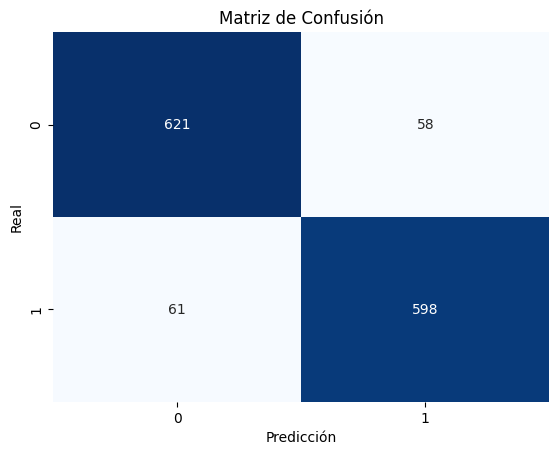

Vairbale:  Otros aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


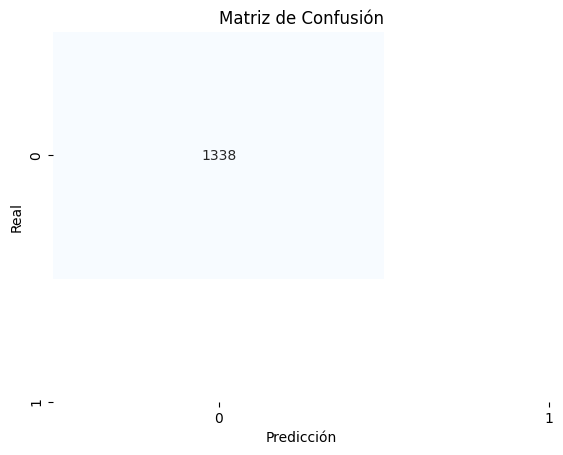

Vairbale:  Flexible aut
Presicion:  0.9962770856724105 Recall 0.9955479487986908 f1 0.9955479487986908
[1329    0]


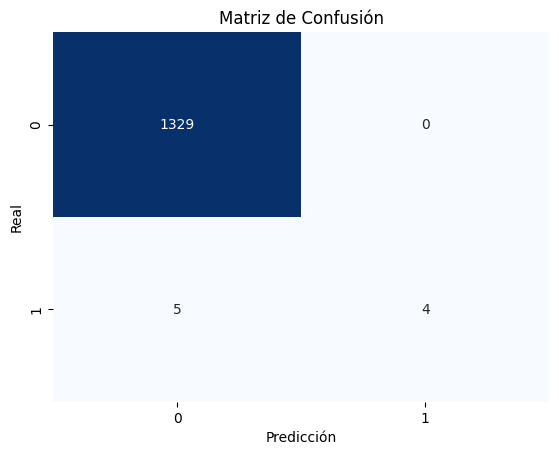

Vairbale:  Desplazada aut
Presicion:  0.991268963604759 Recall 0.9906716956034131 f1 0.9906716956034131
[1316    1]


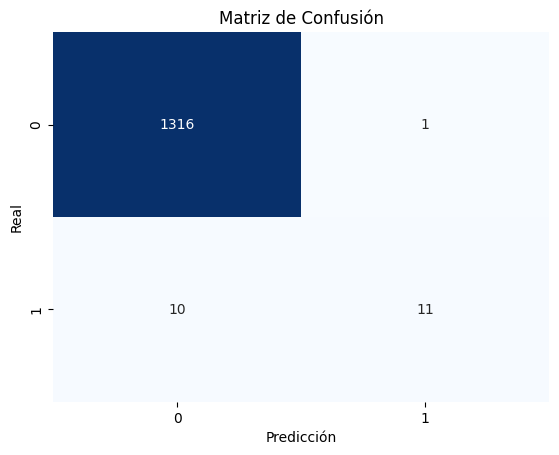

Vairbale:  Desmoldeo aut
Presicion:  0.9911127380698168 Recall 0.9897705897889765 f1 0.9897705897889765
[1311    0]


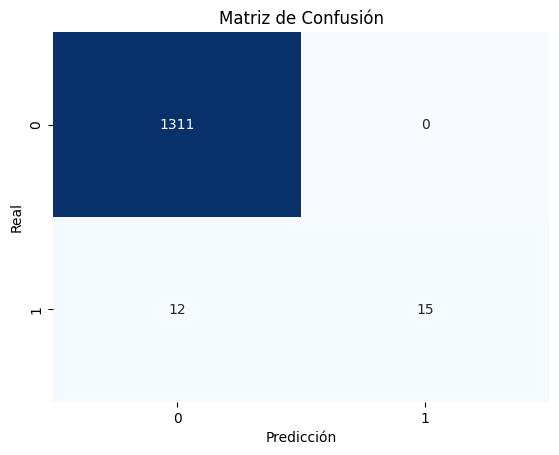

Vairbale:  Golpe aut
Presicion:  0.9947957019541552 Recall 0.9927406308890014 f1 0.9927406308890014
[1330    0]


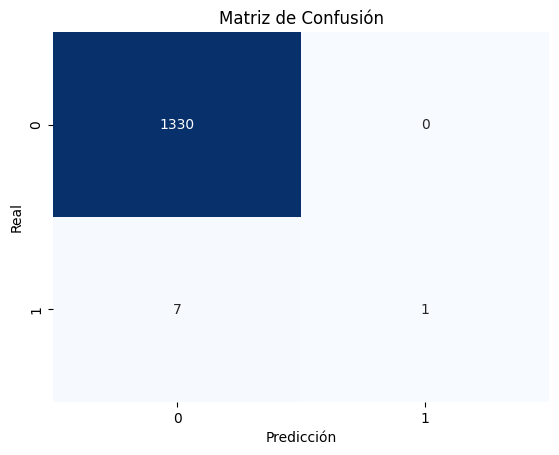

Vairbale:  Esquinas Levantadas aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1336    0]


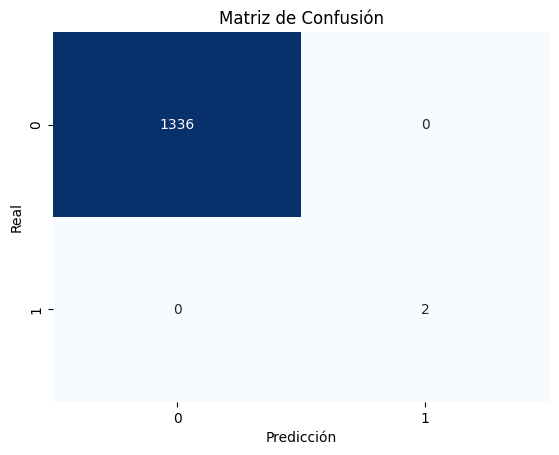

Vairbale:  Daño Estiba aut
Presicion:  0.9803541346504181 Recall 0.9804380329160544 f1 0.9804380329160544
[1192   11]


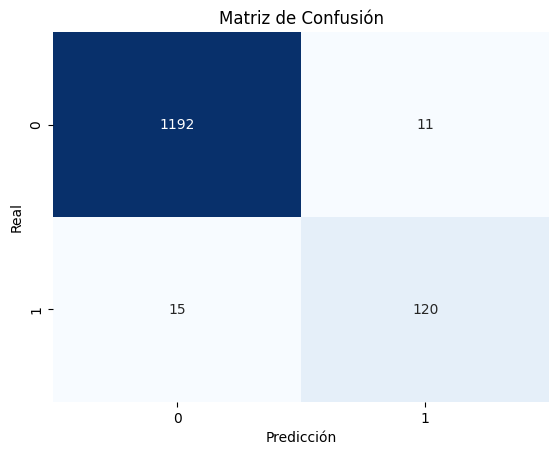

Vairbale:  Ensayos Calidad
Fallo 'Ensayos'
Vairbale:  Mal Perforado aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


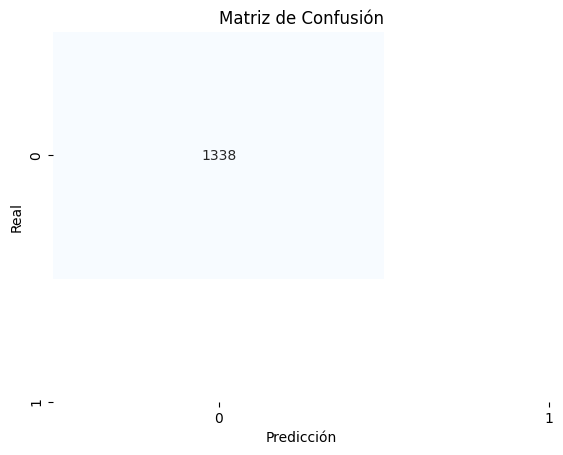

Vairbale:  Tallon aut
Presicion:  0.9422057524248597 Recall 0.9417833739196504 f1 0.9417833739196504
[697  48]


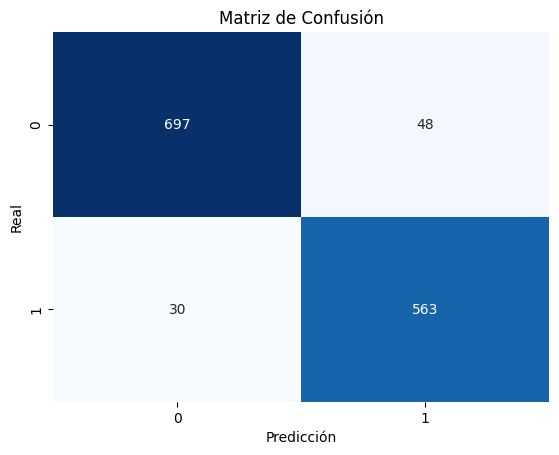

Vairbale:  Mancha aut
Presicion:  0.903057424284981 Recall 0.9029400321752099 f1 0.9029400321752099
[812  67]


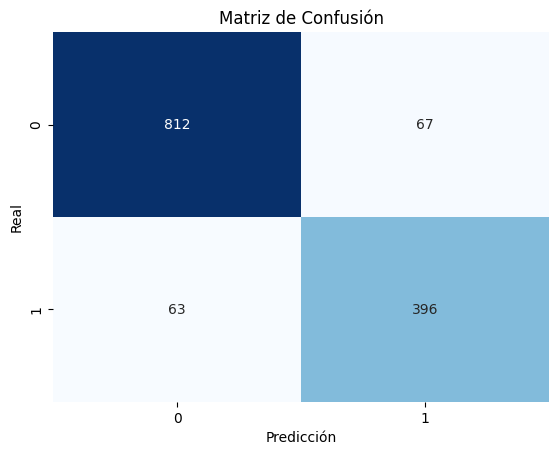

Vairbale:  Placa Fresca aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


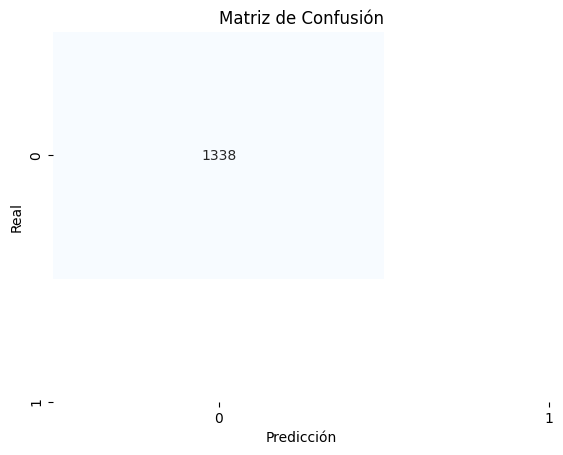

Vairbale:  Sin Pulir aut
Presicion:  1.0 Recall 1.0 f1 1.0
[1338]


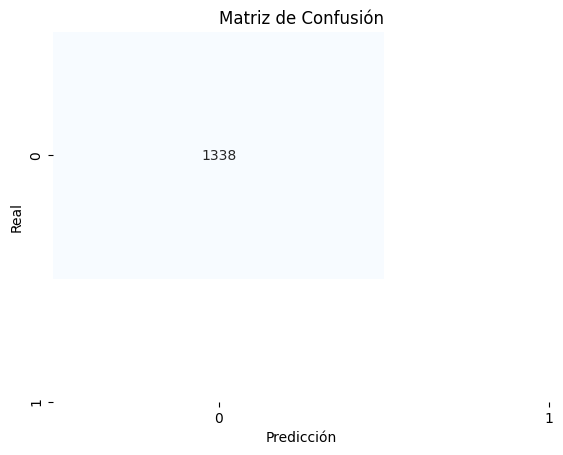

In [106]:
# Determinacion de matrices de confusion y métricas de los mejores modelos para las diferentes variables

split = BestModel(dfx_aut_nc_m1, dfy_aut_nc_m1)
split.split_data()
dict_choose_labels = {'column':[],'precision':[],
                      'recall':[],'FPR':[],'FNR':[],'f1':[],'TP':[],'TN':[],'FP':[],'FN':[]}

for file in os.listdir('best-aut-m1-without-variables'):
    if '.joblib' in file:
        print("Vairbale: ",' '.join(file.split("_")[:2]))
        try:

            idx = split.dfy.columns.get_loc(file.split("_")[0])
        
            y_test = split.y_test[:,idx]
            
            
            model = joblib.load('best-aut-m1-without-variables/'+file)
            y_pred = model.predict(split.X_test)
    
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            print("Presicion: ",precision,"Recall",f1,"f1",f1)
            
            cm = confusion_matrix(y_test, y_pred)
            print(cm[0,])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['0', '1'],
                        yticklabels=['0', '1'])
    
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.show()

            dict_choose_labels['column'].append(file.split("_")[0])
            dict_choose_labels['precision'].append(precision)
            dict_choose_labels['recall'].append(recall)
            dict_choose_labels['f1'].append(f1)

            try:
                fpr = cm[0,1]/(cm[0,1]+cm[0,0])
                fnr = cm[1,0]/(cm[1,1]+cm[1,0])
                dict_choose_labels['FPR'].append(fpr)
                dict_choose_labels['FNR'].append(fnr)
                dict_choose_labels['TP'].append(cm[1,1])
                dict_choose_labels['TN'].append(cm[0,0])
                dict_choose_labels['FP'].append(cm[0,1])
                dict_choose_labels['FN'].append(cm[1,0])

            except:
                dict_choose_labels['FPR'].append(1)
                dict_choose_labels['FNR'].append(1)
                dict_choose_labels['TP'].append(0)
                dict_choose_labels['TN'].append(0)
                dict_choose_labels['FP'].append(0)
                dict_choose_labels['FN'].append(0)
        
        except Exception as err:
            print("Fallo", err)

# Carga de datos y mejor modelo nt m1

In [91]:
dfx_nt_nc_m1 = pd.read_csv('nt-data/dfx_nt_nc_m1.csv')
dfy_nt_nc_m1 = pd.read_csv('nt-data/dfy_nt_nc_m1.csv')

In [94]:
dfx_nt_nc_m1.columns

Index(['PP_Hidro_Cemento_Kg', 'PP_Hidro_Carbonato_Kg', 'PP_Hidro_Celulosa_Kg',
       'PP_Hidro_Pva_Kg', 'PP_Hidro_Bentonita_Kg', 'PP_Hidro_Agua_Kg',
       'PP_Hidro_SolReales_%', 'PP_Hidro_CelulosaS_%',
       'PP_Hidro_CelulosaSR_SR°', 'PP_Maq_Resi_ml', 'PP_Refi_EE_AMP',
       'PP_Refi_CelulosaH_%', 'PP_Refi_CelulosaS_%', 'PP_Refi_CelulosaSR_SR°',
       'PP_Maq_FlujoFloc_L/min', 'PP_Maq_Vueltas_N', 'PP_Maq_Vel_m/min',
       'PP_Maq_FormatoP_PSI', 'PP_Maq_FlujoFlocForm_L/Placa',
       'PP_Maq_VacíoCP_PulgadasHg', 'PP_Maq_VacioSF_PulgadasHg',
       'PP_Maq_Recir_%', 'PP_Maq_Fieltro_Dias', 'PP_PF_Humedad_%',
       'PP_PF_Espesor_mm', 'PP_PF_Dens_g/cm3', 'PP_Maq_FlocCanalS_%',
       'PP_Maq_FlocTkS_%', 'PP_Maq_FlocFormS_%', 'PP_MaqTCE_Densidad_g/cm3',
       'PP_Maq_TCES_%', 'PP_Maq_CilinS_%', 'PP_Maq_CanalS_%',
       'PP_Maq_Cono1S_%', 'PP_Maq_MolinoS_%', 'PP_Maq_P1H_%', 'PP_Maq_P3H_%',
       'Tipo_Producto', 'Mp_CemPre_ARG_LOI_%', 'Mp_CemCist_Bl_ARG_cm2/g',
       'Mp_CemPre_

## Elección del mejor modelo según la caracteristica de interes

In [ ]:
classifier = GeneralClassifier(dfx_aut_nc_m1, dfy_aut_nc_m1)

for caract in dfy_nt_nc_m1.columns:
    classifier.train(feature=caract)
    idx = classifier.predictions['Balanced Accuracy'].idxmax()
    
    print("\nMejor modelo de: ", caract,"\n")
    print("Modelo: ",idx)
    print(classifier.predictions[['Accuracy','Balanced Accuracy','ROC AUC','F1 Score']].loc[idx],"\n")

## Tuneo del mejor modelo para cada variable

[0 1 1 ... 1 0 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9320446444401518 Recall 0.9310211317638285 f1 0.9310211317638285


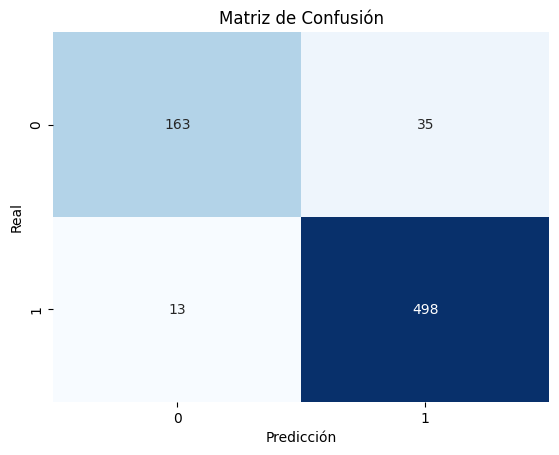

[1 1 1 ... 1 1 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9730223585806445 Recall 0.972892879115544 f1 0.972892879115544


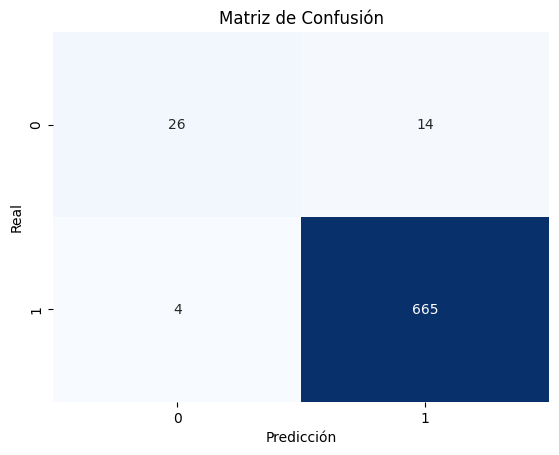

[1 1 1 ... 0 0 1]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9168074412339243 Recall 0.9160765221307515 f1 0.9160765221307515


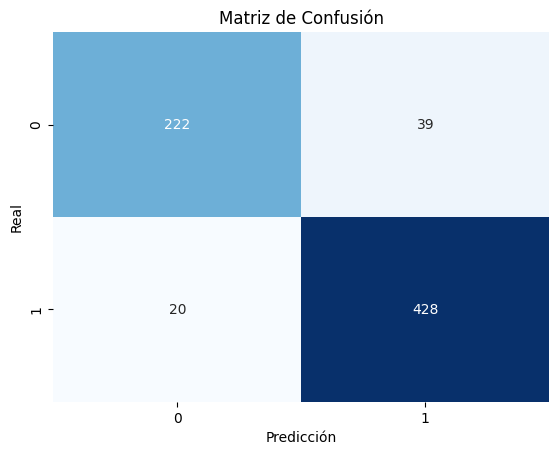

[0 0 0 ... 1 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9971871166747244 Recall 0.9968285168402204 f1 0.9968285168402204


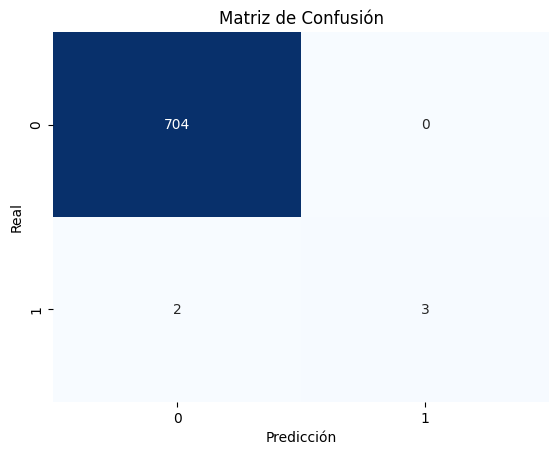

[1 1 1 ... 0 1 1]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9427295050658777 Recall 0.9421331377958589 f1 0.9421331377958589


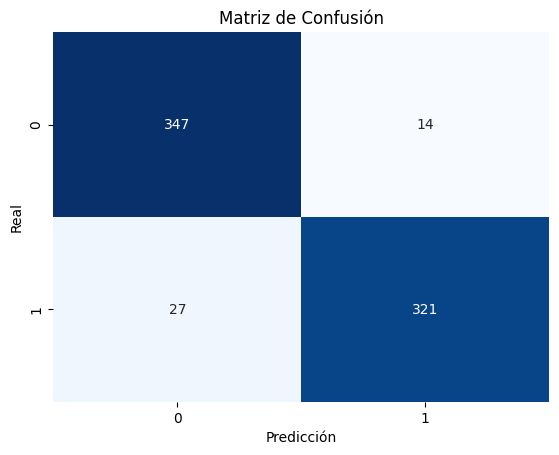

[1 1 1 ... 0 1 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9269423420964387 Recall 0.9266817970021806 f1 0.9266817970021806


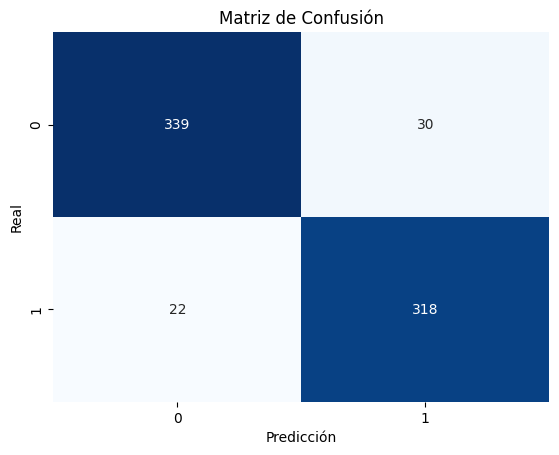

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9793339335503126 Recall 0.9778259616717225 f1 0.9778259616717225


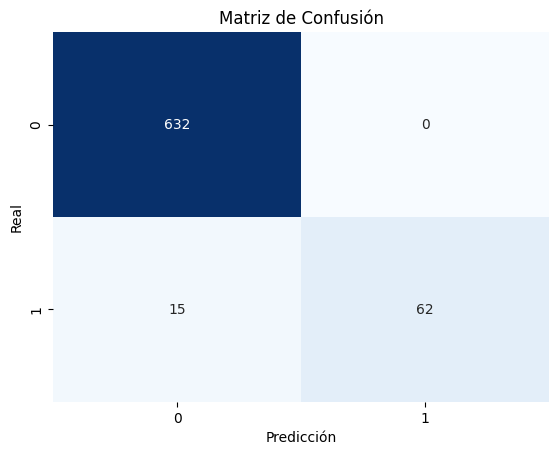

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9957867708220318 Recall 0.9953998675727528 f1 0.9953998675727528


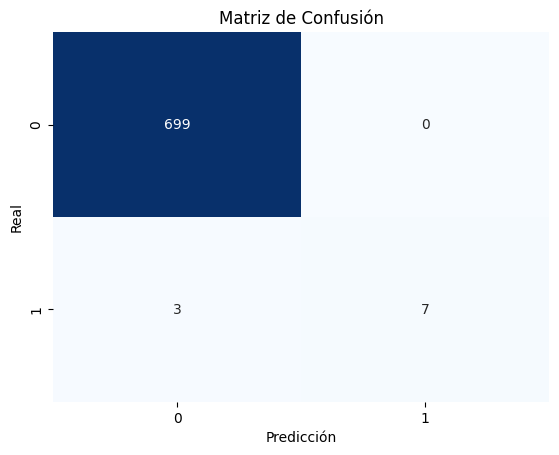

[0 0 0 ... 0 1 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9766264430862456 Recall 0.9737777180543372 f1 0.9737777180543372


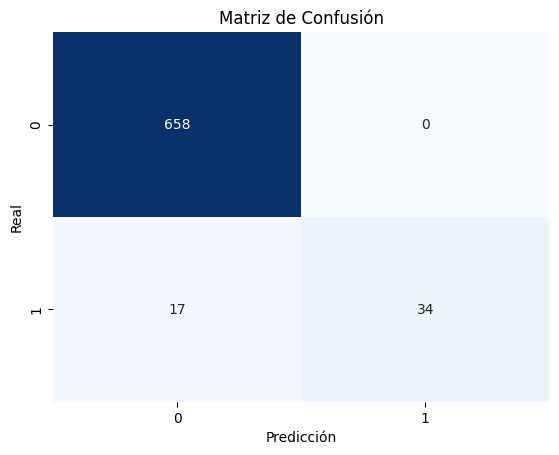

[1 1 1 ... 0 1 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9354013541534574 Recall 0.934754759569158 f1 0.934754759569158


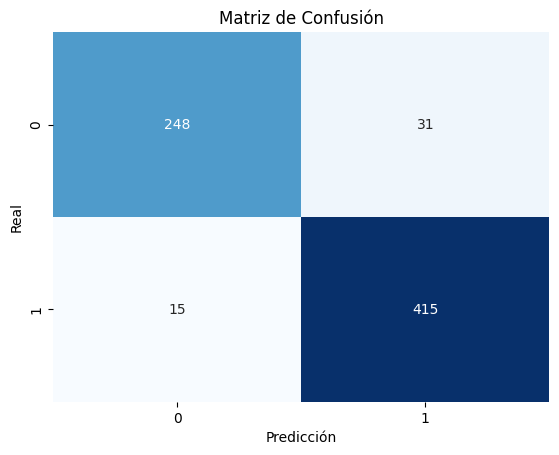

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


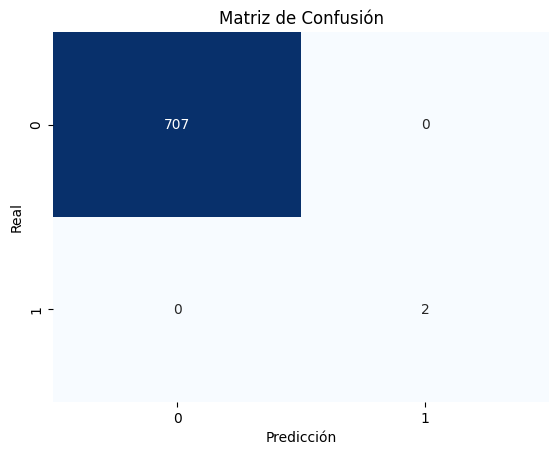

[0 1 1 ... 0 1 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9520966217974174 Recall 0.9520631887027252 f1 0.9520631887027252


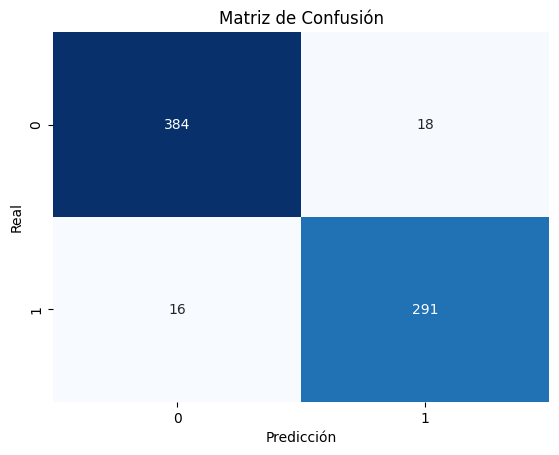

[0 1 1 ... 0 1 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9508816397547608 Recall 0.9496249075389332 f1 0.9496249075389332


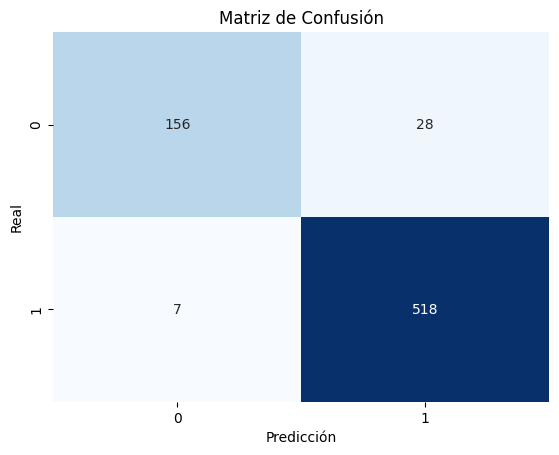

[1 1 1 ... 0 1 1]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9351198871650211 Recall 0.9351198871650211 f1 0.9351198871650211


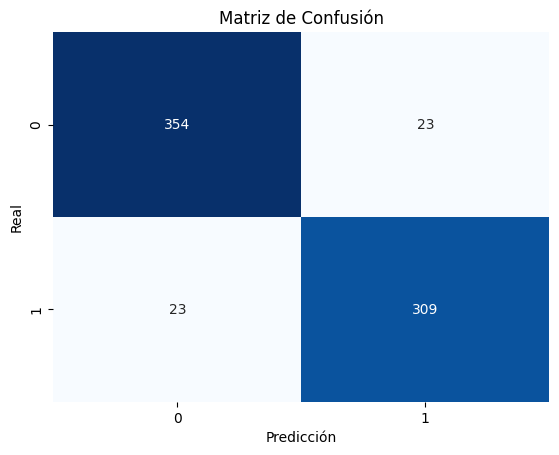

[0 1 1 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9739874453673232 Recall 0.9715954937416661 f1 0.9715954937416661


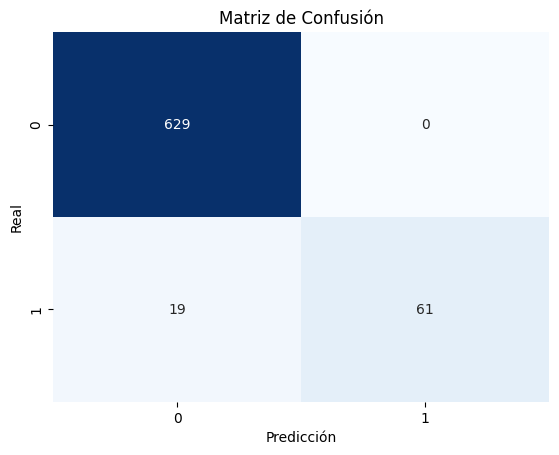

[0 1 1 ... 0 0 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9411056561501471 Recall 0.9407463111252901 f1 0.9407463111252901


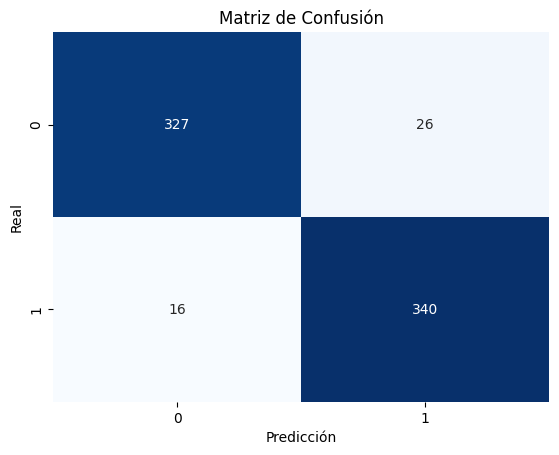

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9943903977754471 Recall 0.9937394497055994 f1 0.9937394497055994


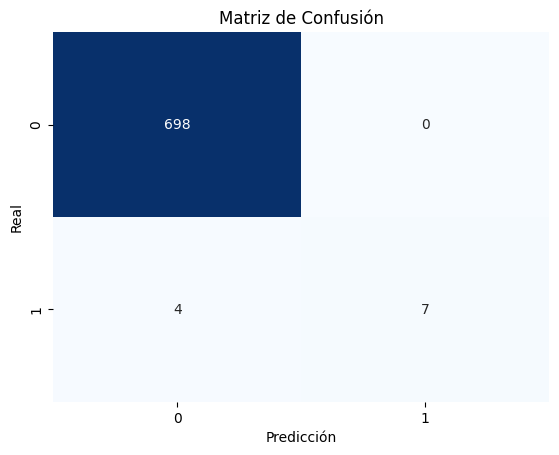

[1 0 0 ... 0 0 1]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9694539754326144 Recall 0.968600742532253 f1 0.968600742532253


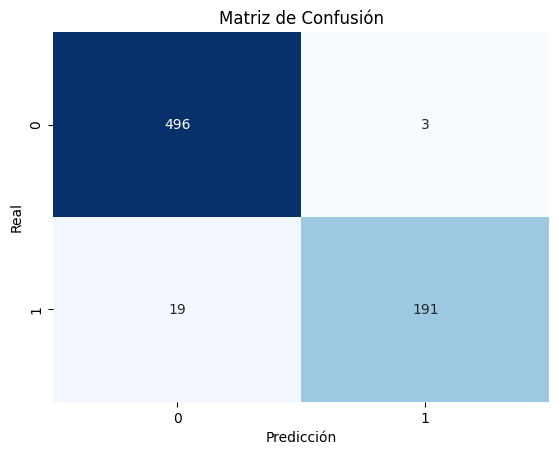

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9607901133361494 Recall 0.9600506075582618 f1 0.9600506075582618


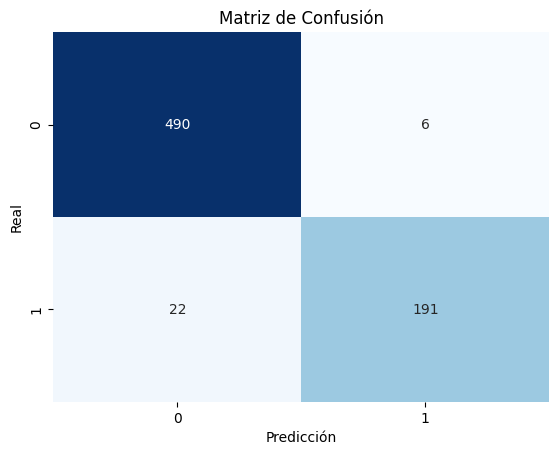

[1 1 1 ... 0 1 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9550449715000494 Recall 0.9547599640168142 f1 0.9547599640168142


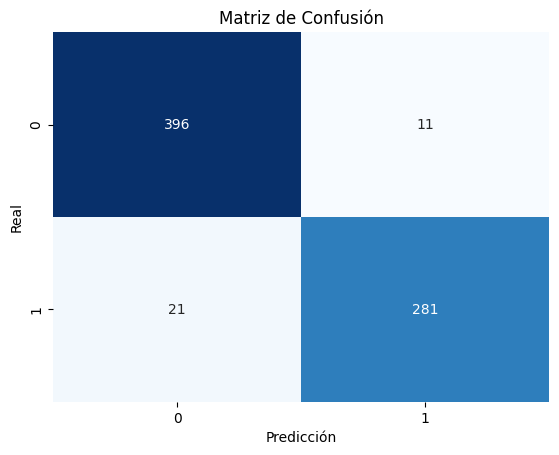

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


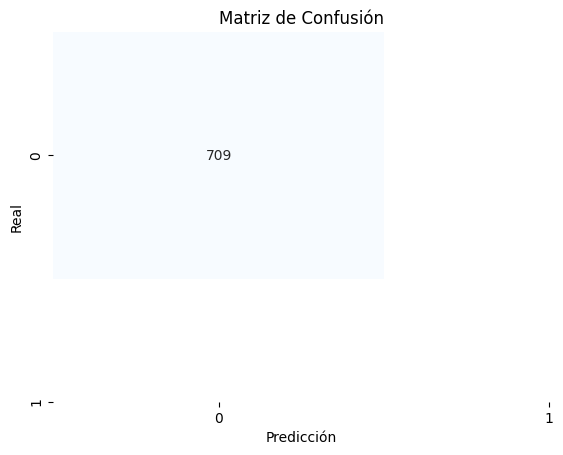

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


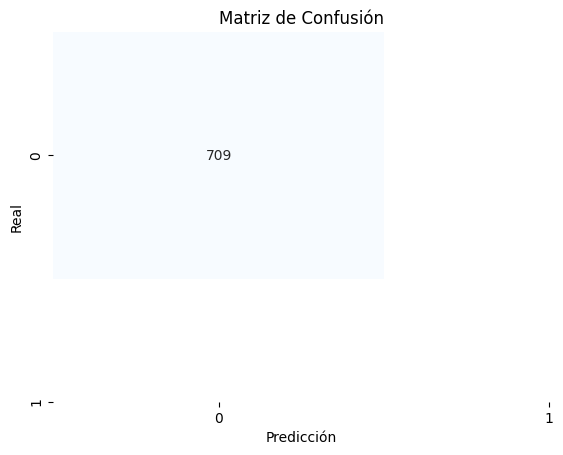

[0 1 1 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.980096485790076 Recall 0.979645746042079 f1 0.979645746042079


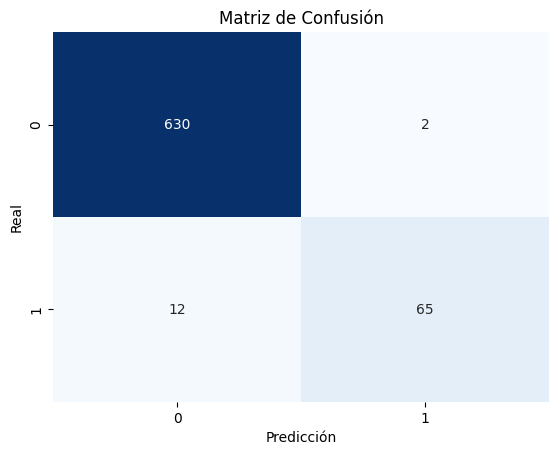

[0 0 0 ... 0 1 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9664124486288986 Recall 0.9655990556283494 f1 0.9655990556283494


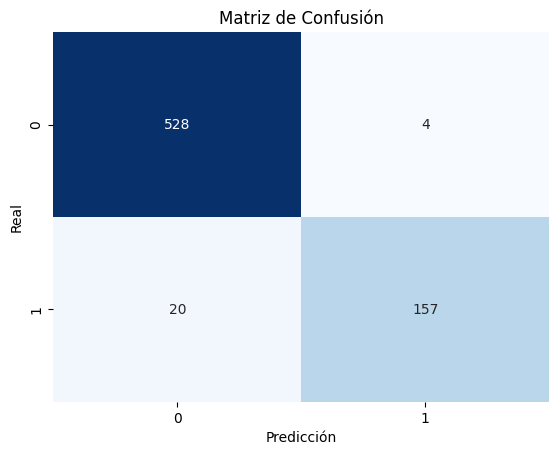

[0 0 1 ... 0 0 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9484418283516658 Recall 0.9471589177261609 f1 0.9471589177261609


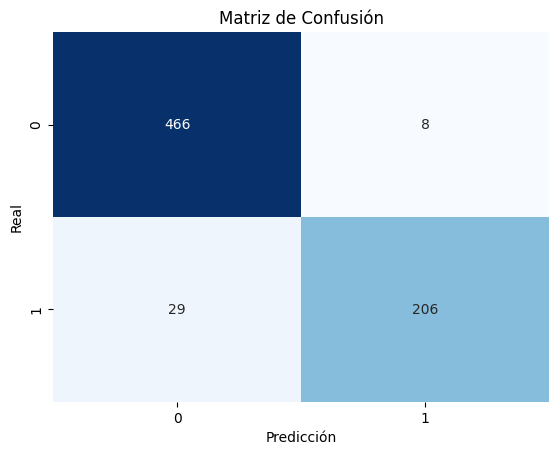

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.991610435206137 Recall 0.9908090183577445 f1 0.9908090183577445


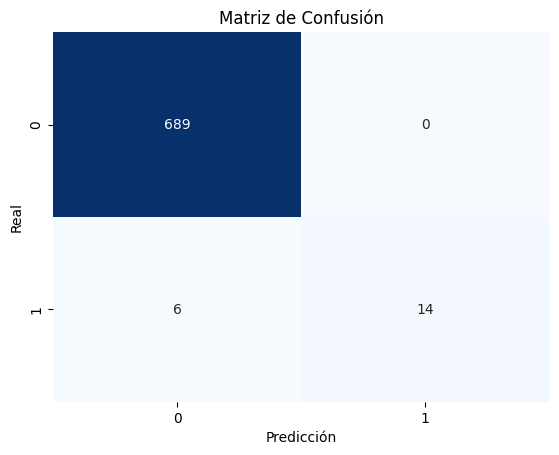

[0 0 1 ... 0 0 1]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9564881956016731 Recall 0.9556933564318364 f1 0.9556933564318364


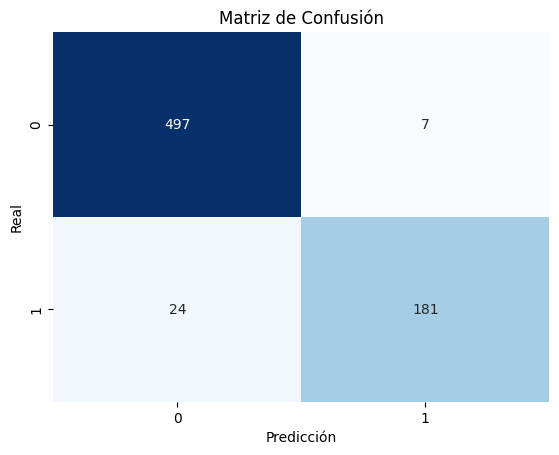

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9916106460535232 Recall 0.9908876717457468 f1 0.9908876717457468


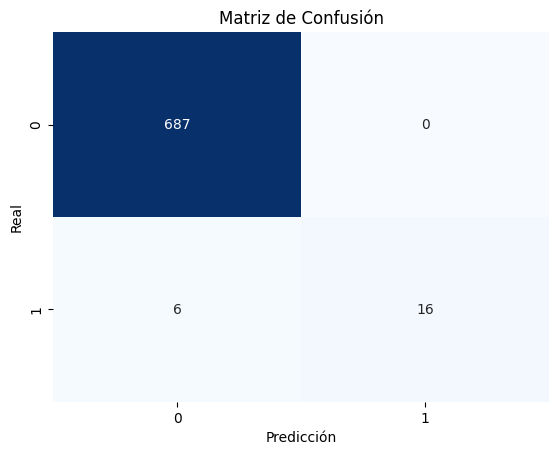

[0 0 0 ... 0 0 1]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9748668688201843 Recall 0.97413837374093 f1 0.97413837374093


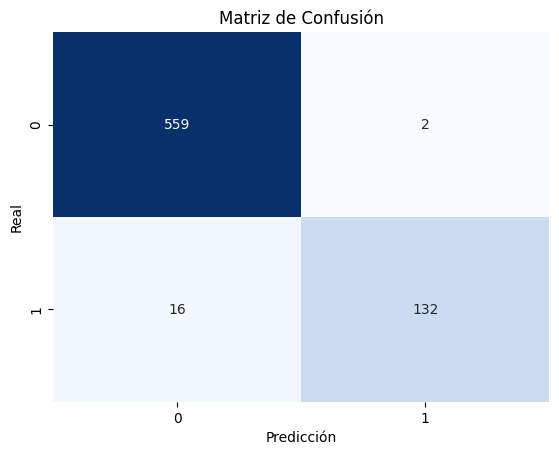

[0 1 1 ... 0 1 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9735404615017393 Recall 0.971950004427939 f1 0.971950004427939


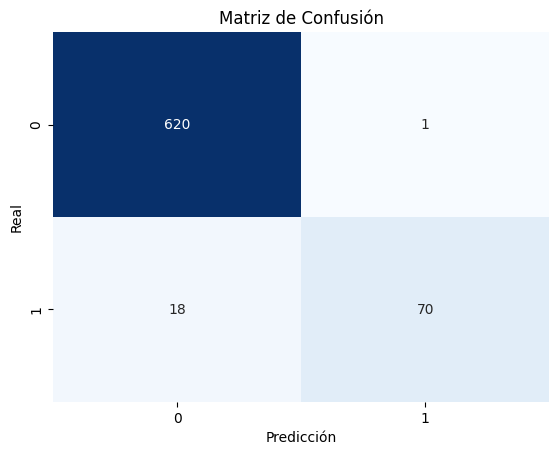

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


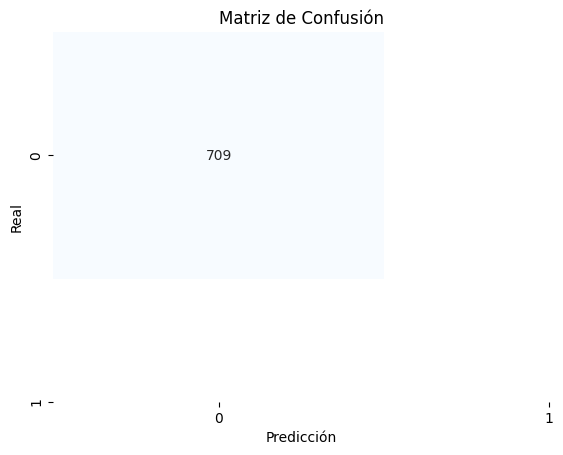

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


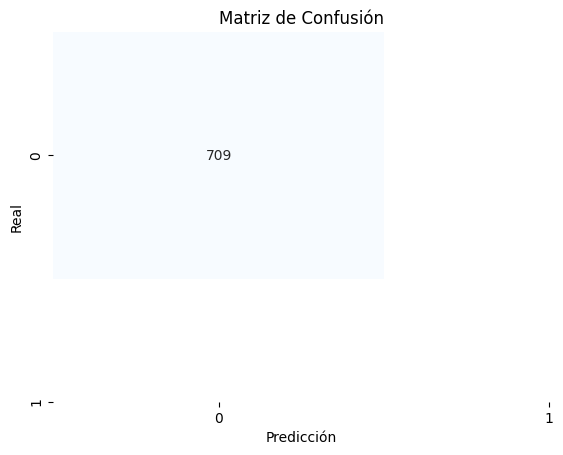

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9888516338268457 Recall 0.9882489997602067 f1 0.9882489997602067


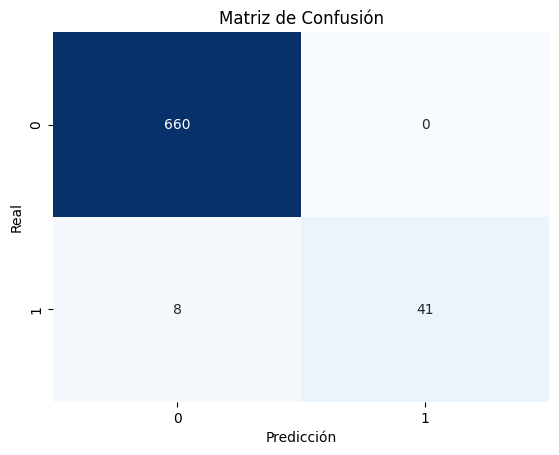

[0 0 1 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9703564384394013 Recall 0.969512049813278 f1 0.969512049813278


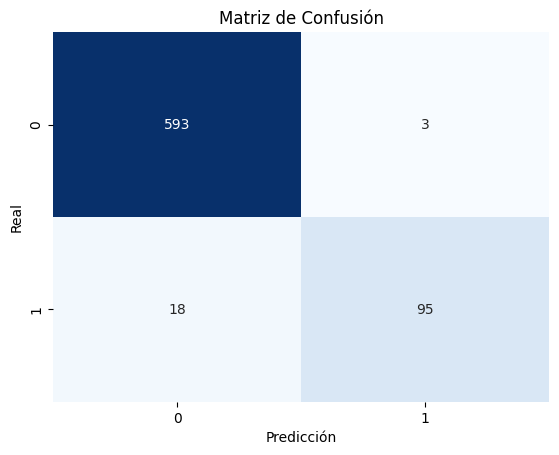

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9971811148621094 Recall 0.9978848418309605 f1 0.9978848418309605


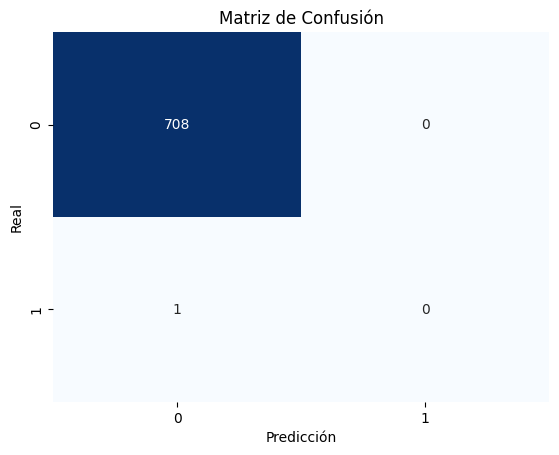

[0 1 1 ... 0 1 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Presicion:  0.9861109615736603 Recall 0.9853522323341357 f1 0.9853522323341357


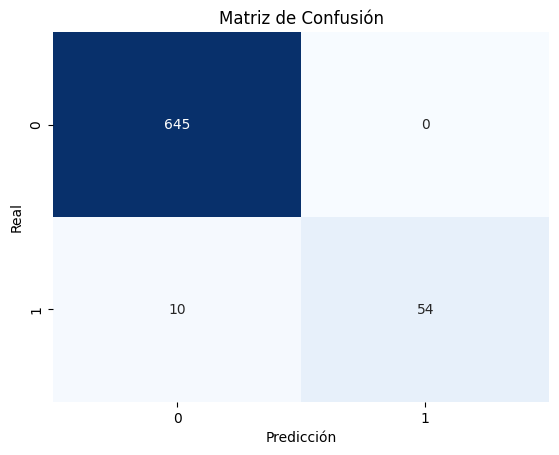

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


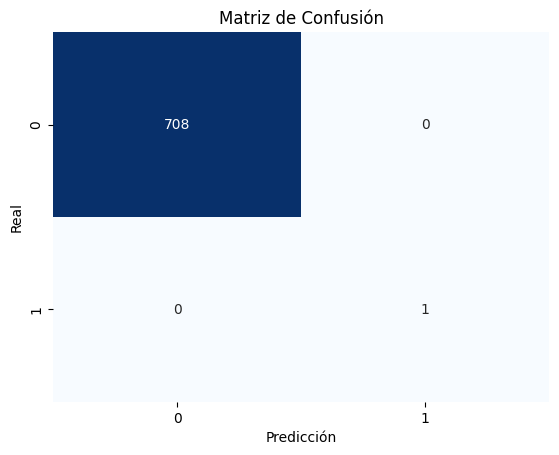

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


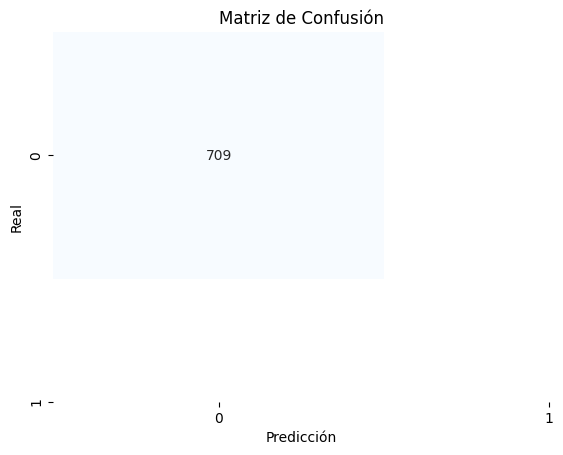

[0 0 0 ... 1 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9846916551019451 Recall 0.9845801511348033 f1 0.9845801511348033


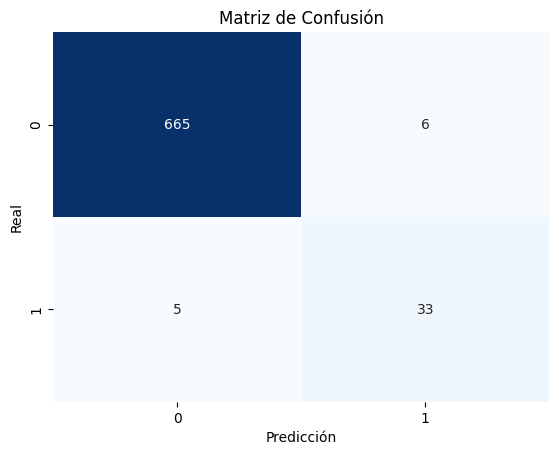

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


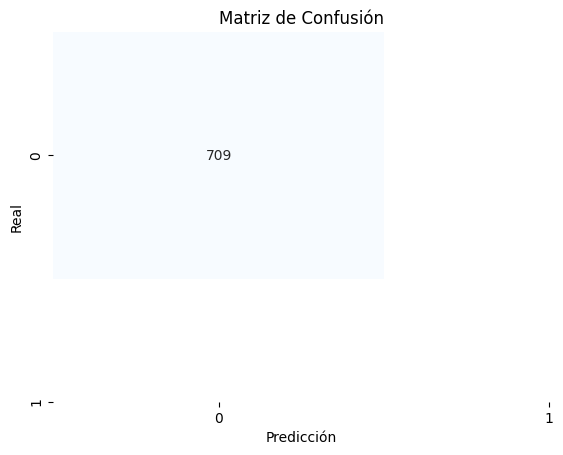

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9929976878405149 Recall 0.9910013859678569 f1 0.9910013859678569


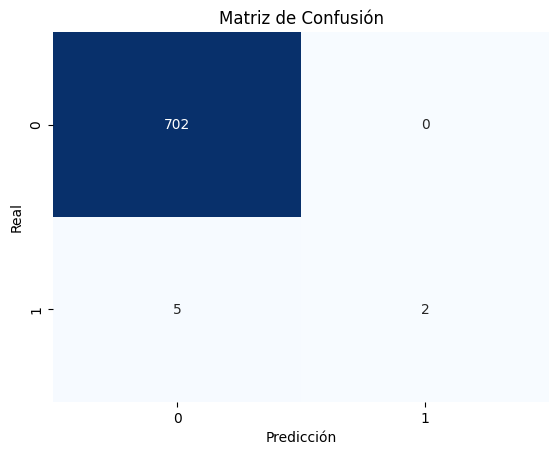

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


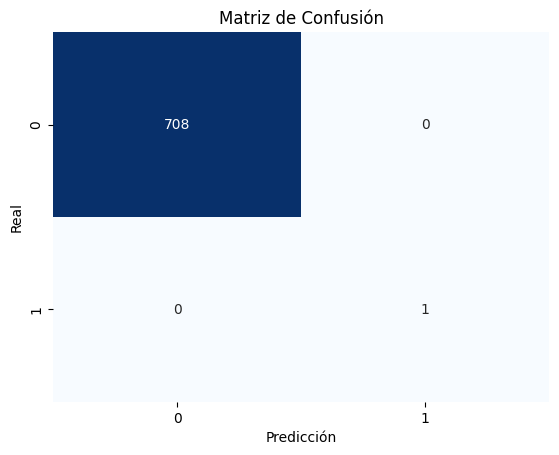

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9929998210949819 Recall 0.9926977224844094 f1 0.9926977224844094


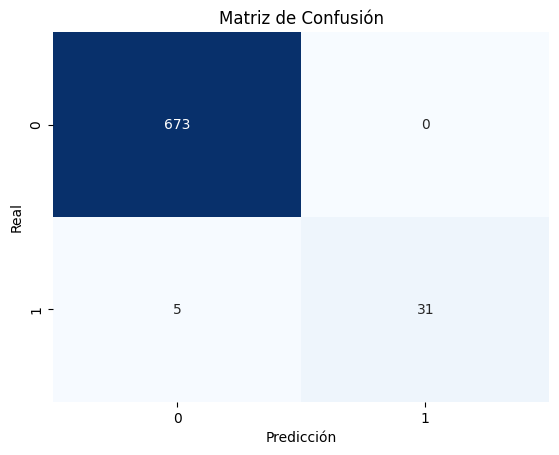

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


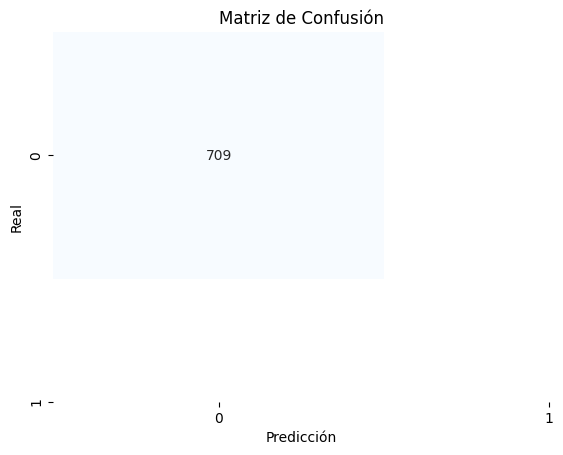

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


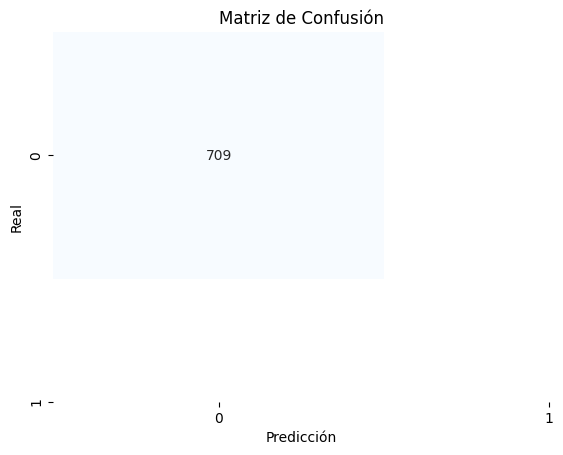

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


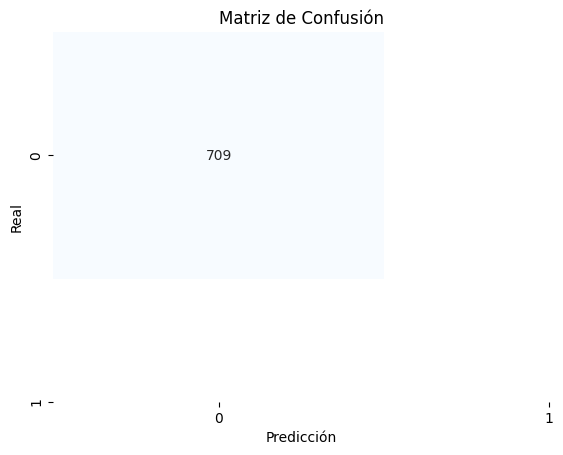

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


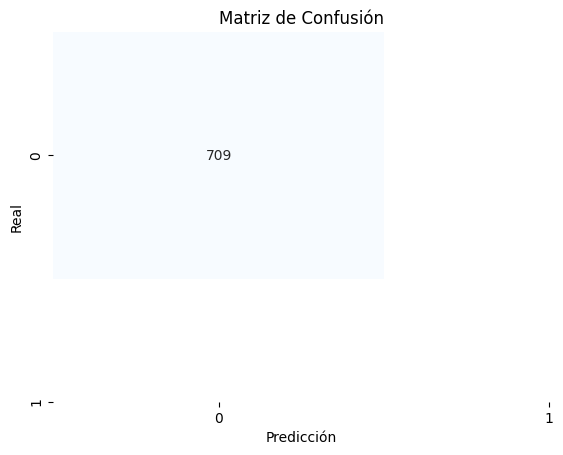

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9957866683714444 Recall 0.9950679742657768 f1 0.9950679742657768


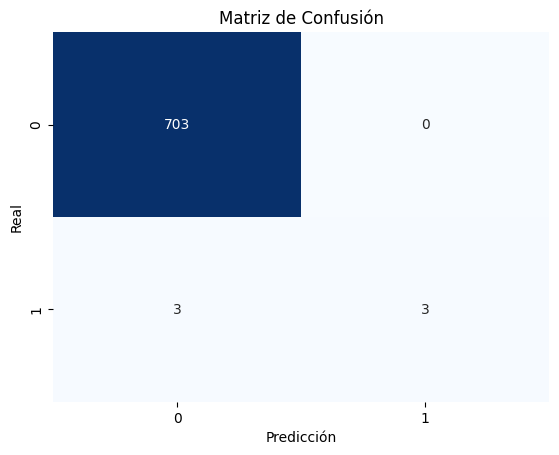

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


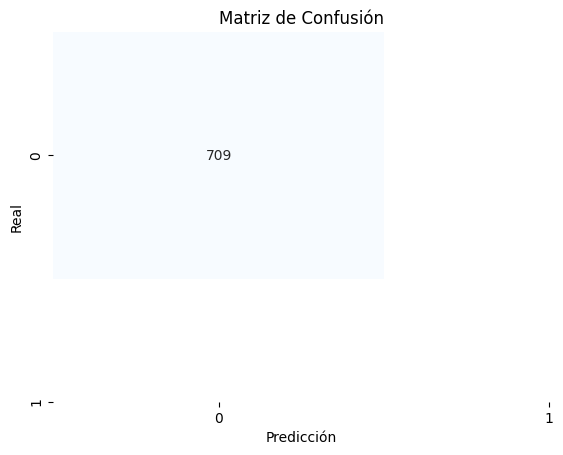

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


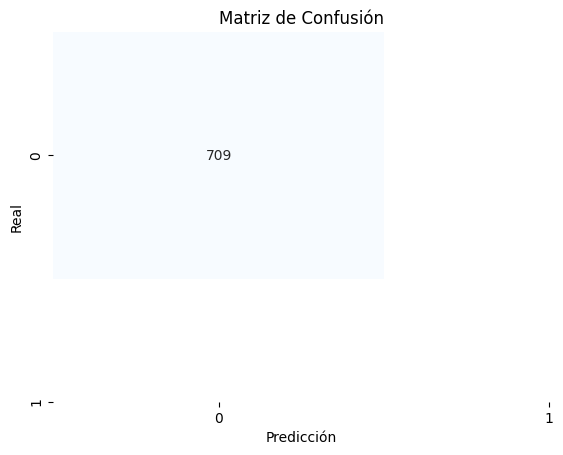

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


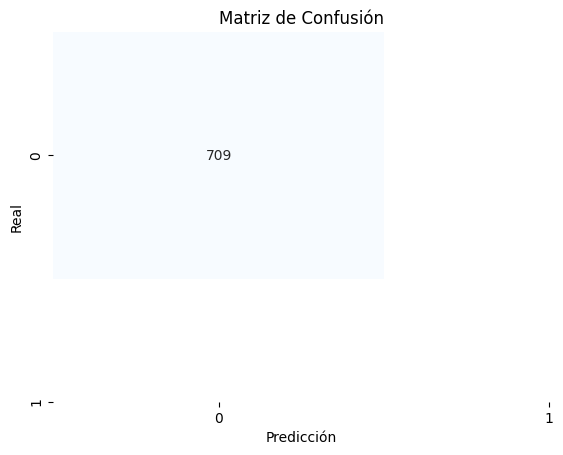

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


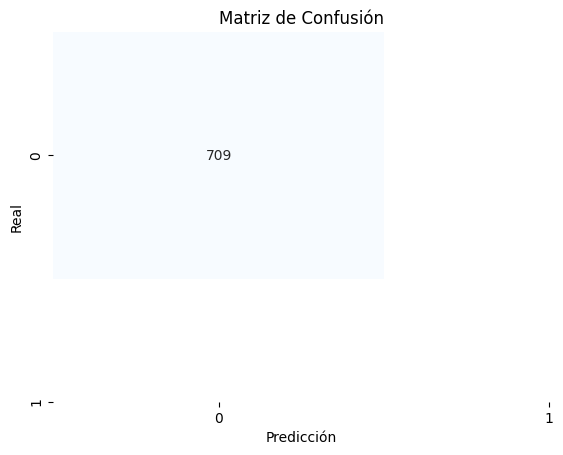

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


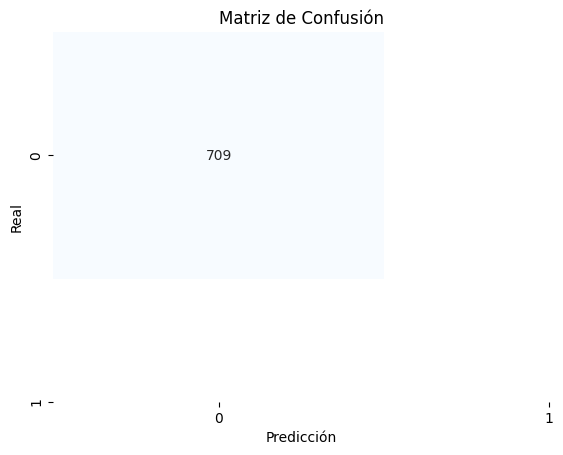

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


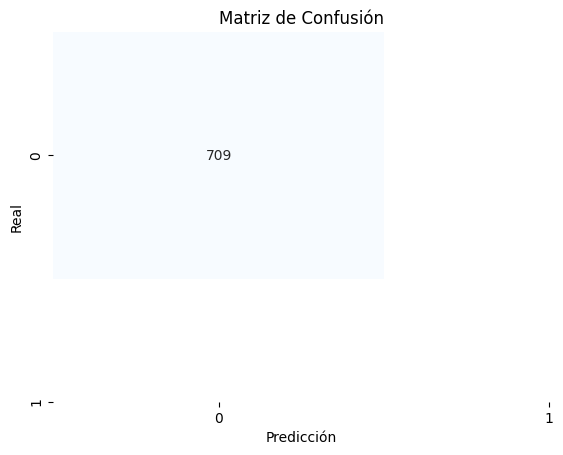

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


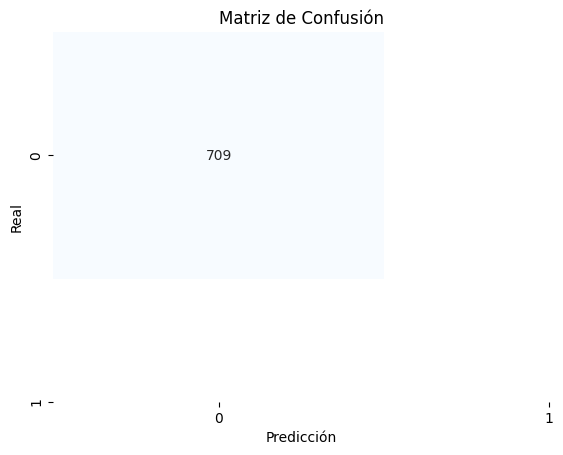

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


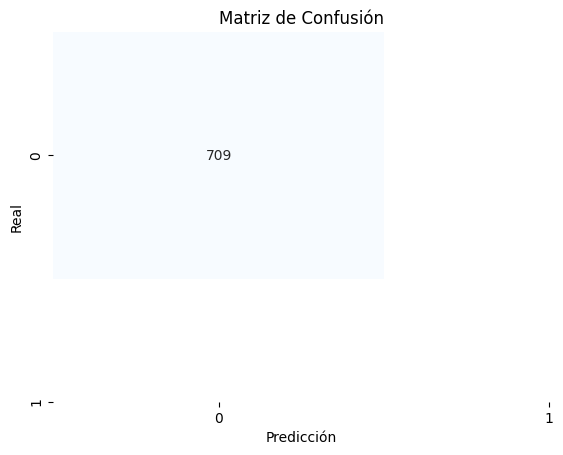

[0 0 0 ... 0 0 0]
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  1.0 Recall 1.0 f1 1.0


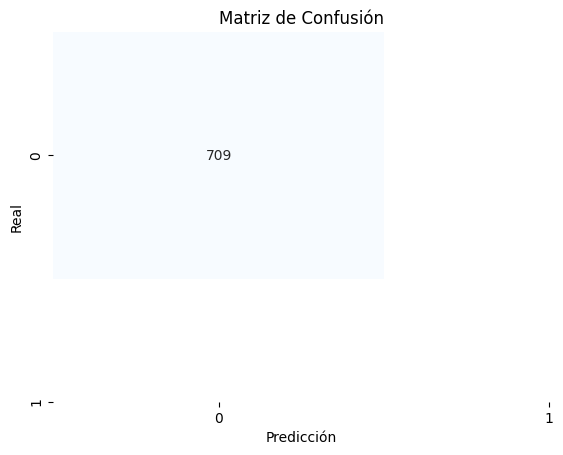

In [40]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para las caracteristicas dadas

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

b_model = BestModel(dfx_nt_nc_m1, dfy_nt_nc_m1)
b_model.split_data()
joblib.dump(b_model.scaler, 'scaler-nt-m1/scaler.joblib')

for col in dfy_nt_nc_m1.columns:
    b_model.grid_search_cv(col, extra_trees, param_grid, f'best-nt-m1/{col}_nt_m1_best_extra_tree_classifier')

## Calculo de las matrices de confusion para los mejores modelos



 Variable: 

 Daño Molde
Presicion:  0.9971871166747244 Recall 0.9968285168402204 f1 0.9968285168402204
[704   0]


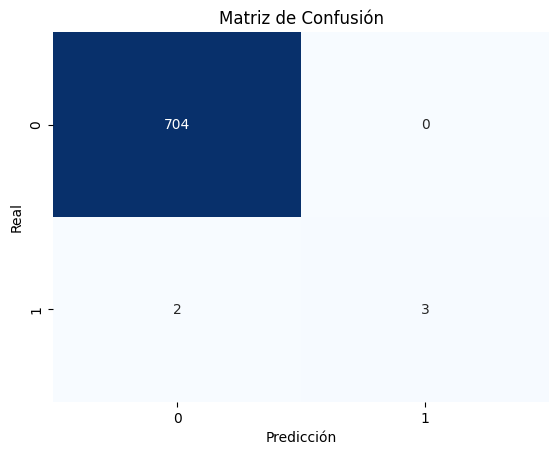



 Variable: 

 Descolgada
Presicion:  0.9815088015451259 Recall 0.981160093318015 f1 0.981160093318015
[630   2]


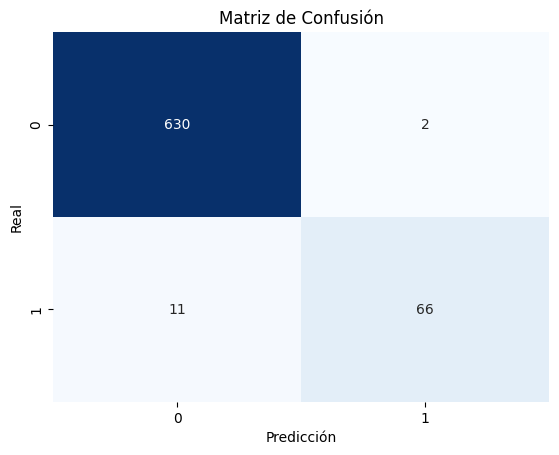



 Variable: 

 Mal Corte
Presicion:  0.9578492238576866 Recall 0.9571583045756874 f1 0.9571583045756874
[497   7]


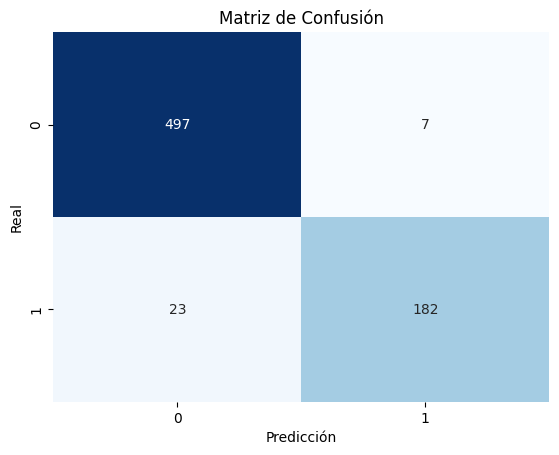



 Variable: 

 Desplazada
Presicion:  0.9465728654439313 Recall 0.9452494116891186 f1 0.9452494116891186
[154  30]


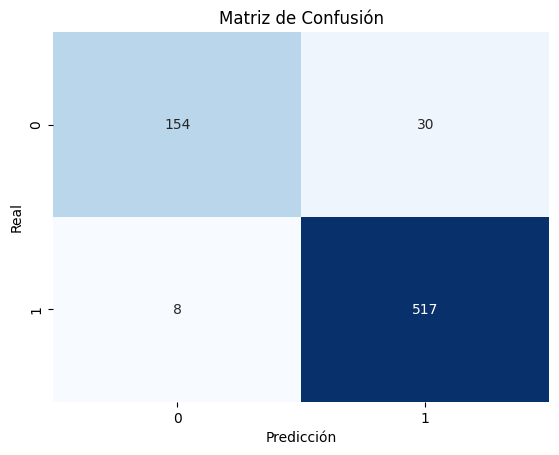



 Variable: 

 Tallon
Presicion:  0.9583949914691204 Recall 0.9576668377859726 f1 0.9576668377859726
[331  22]


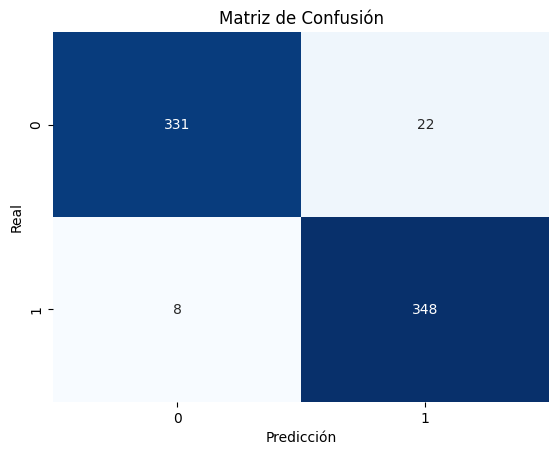



 Variable: 

 Exceso
Fallo 'Exceso'


 Variable: 

 Arruga
Presicion:  0.9902262373749655 Recall 0.9891047465278725 f1 0.9891047465278725
[689   0]


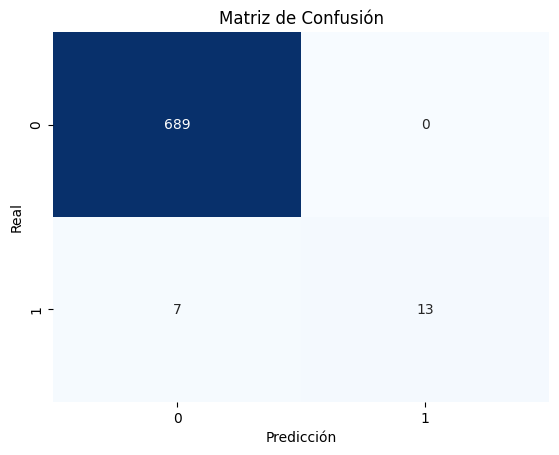



 Variable: 

 Desborde
Presicion:  0.9579171082390754 Recall 0.9577325519540697 f1 0.9577325519540697
[384  18]


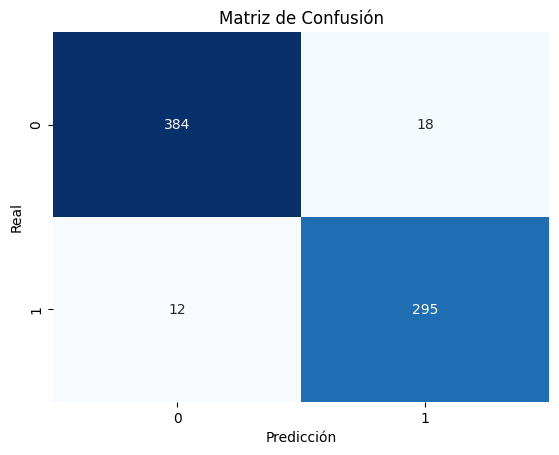



 Variable: 

 Mancha
Presicion:  0.9473875421337219 Recall 0.9456230102648878 f1 0.9456230102648878
[467   7]


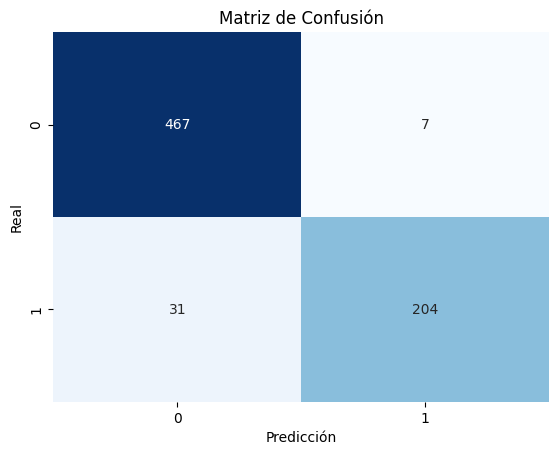



 Variable: 

 Otros
Presicion:  1.0 Recall 1.0 f1 1.0
[707   0]


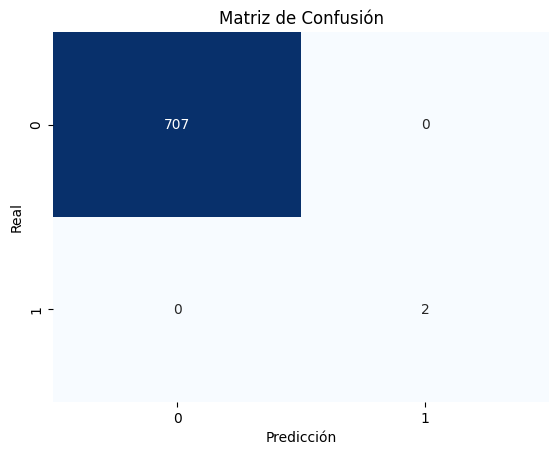



 Variable: 

 Flexible
Presicion:  0.9874807520606618 Recall 0.9868700164945635 f1 0.9868700164945635
[645   0]


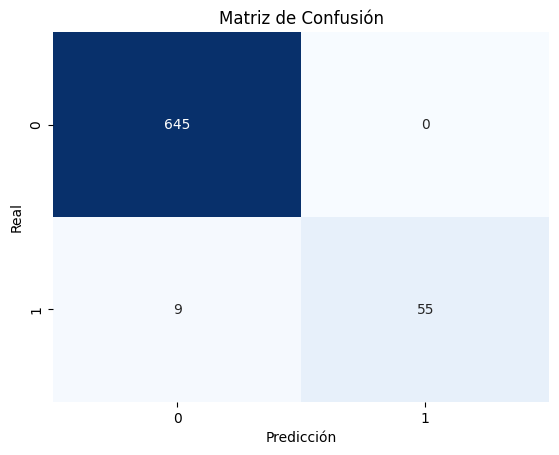



 Variable: 

 Basura
Presicion:  0.9425658715951729 Recall 0.9421416682030992 f1 0.9421416682030992
[346  15]


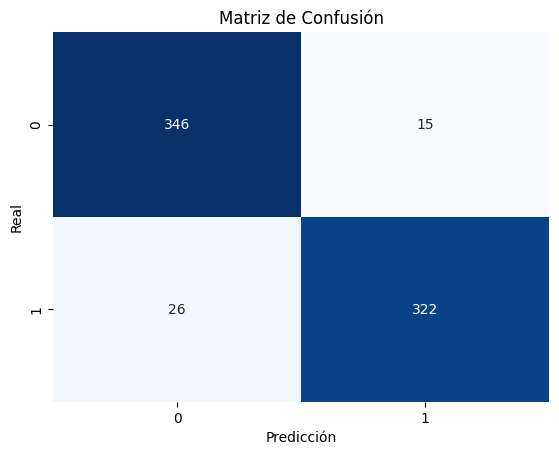



 Variable: 

 Trasparente
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


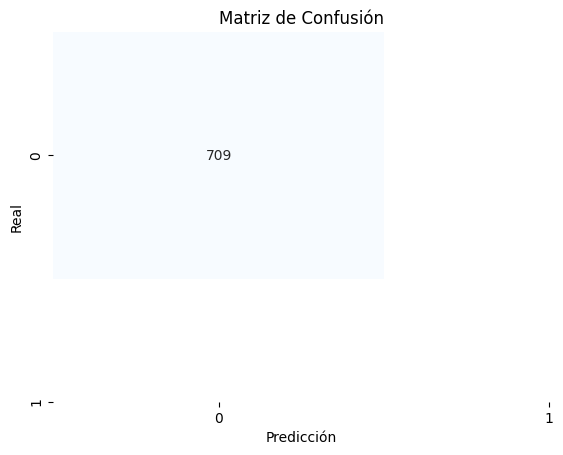



 Variable: 

 Dimensiones
Presicion:  0.9943903977754471 Recall 0.9937394497055994 f1 0.9937394497055994
[698   0]


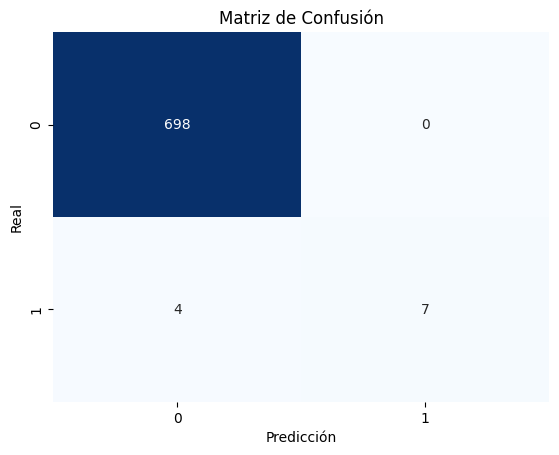



 Variable: 

 Carpas
Presicion:  0.9871640795036423 Recall 0.9872261646084225 f1 0.9872261646084225
[667   4]


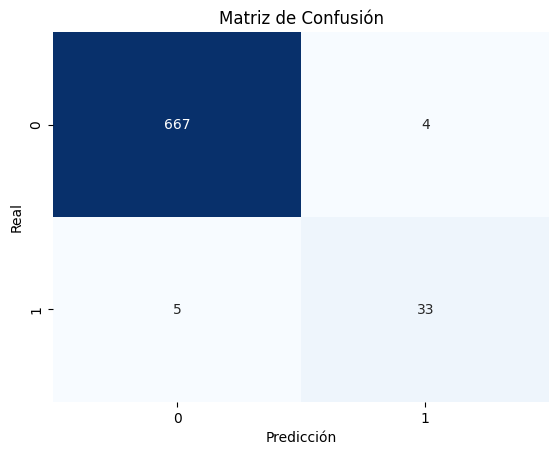



 Variable: 

 Desmoldeadora
Presicion:  0.9751060531616542 Recall 0.9740652356435866 f1 0.9740652356435866
[560   1]


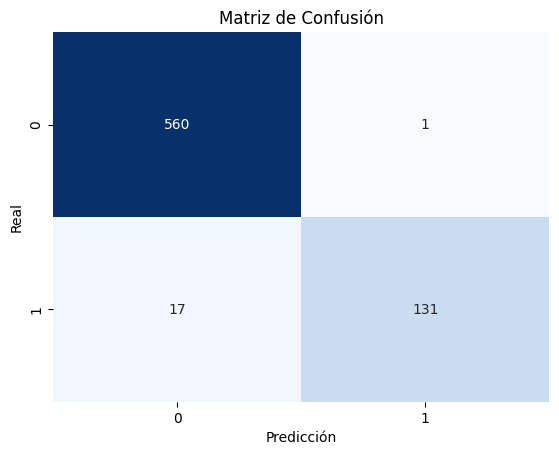



 Variable: 

 Sin Pulir
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


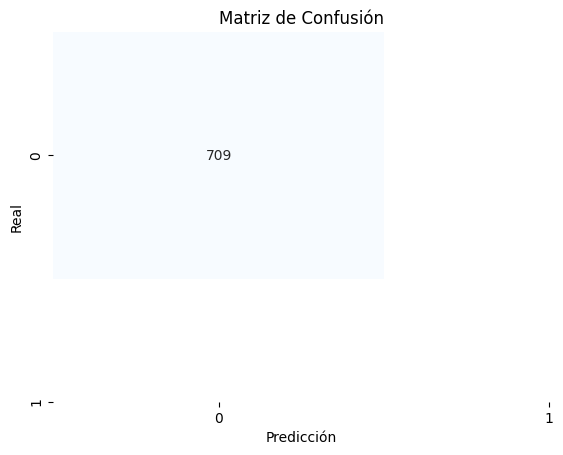



 Variable: 

 Rajada
Presicion:  0.9407969955716212 Recall 0.9407718081794546 f1 0.9407718081794546
[355  22]


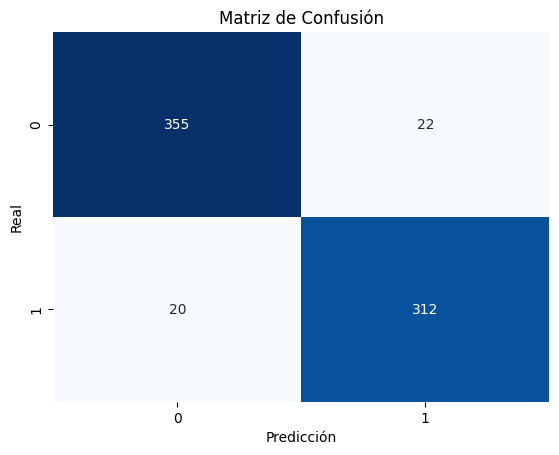



 Variable: 

 Cuarteamineto
Fallo 'Cuarteamineto'


 Variable: 

 Perdida De Grados
Presicion:  1.0 Recall 1.0 f1 1.0
[708   0]


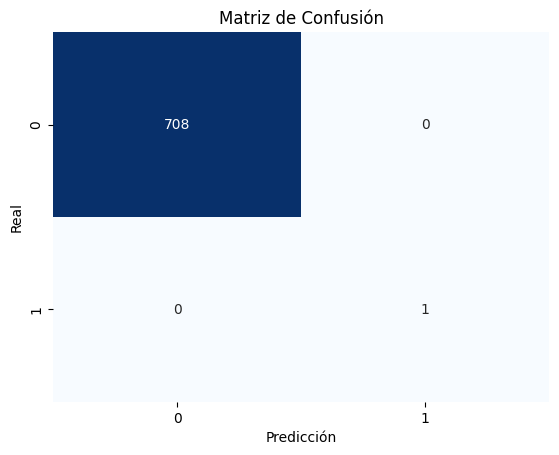



 Variable: 

 Piel De Elefante
Presicion:  0.9902285737990543 Recall 0.9896208530767683 f1 0.9896208530767683
[673   0]


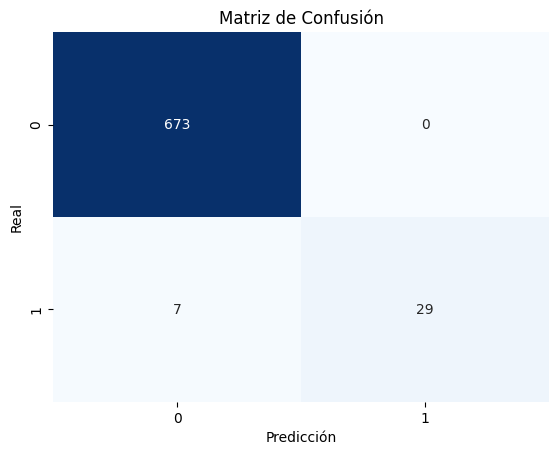



 Variable: 

 Fisura
Presicion:  0.9739537868260579 Recall 0.9703251159341731 f1 0.9703251159341731
[658   0]


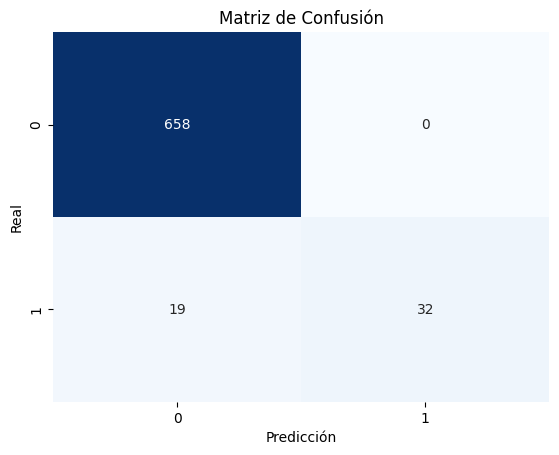



 Variable: 

 Caponeo
Presicion:  0.9753184383604048 Recall 0.9731821074431967 f1 0.9731821074431967
[629   0]


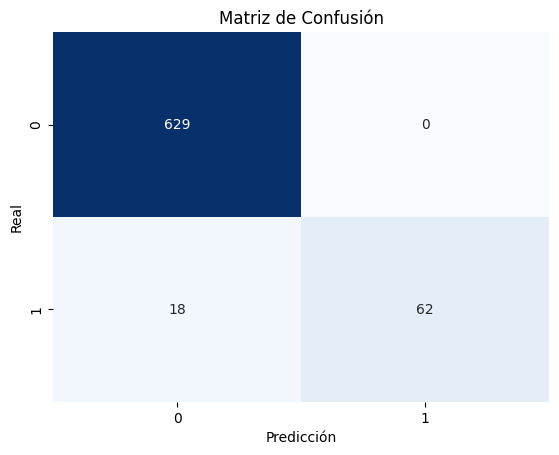



 Variable: 

 Espesor
Presicion:  0.977990214003378 Recall 0.9762658163161015 f1 0.9762658163161015
[632   0]


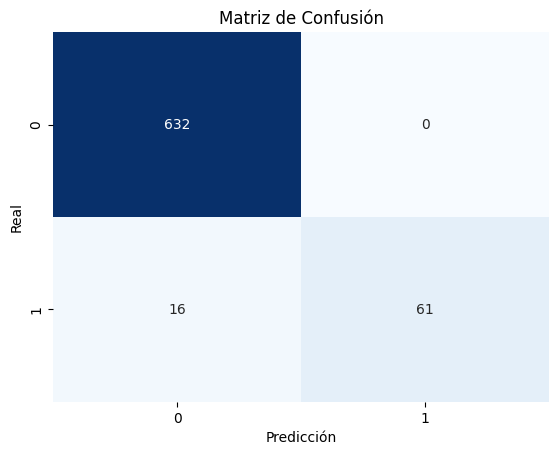



 Variable: 

 Pandeo
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


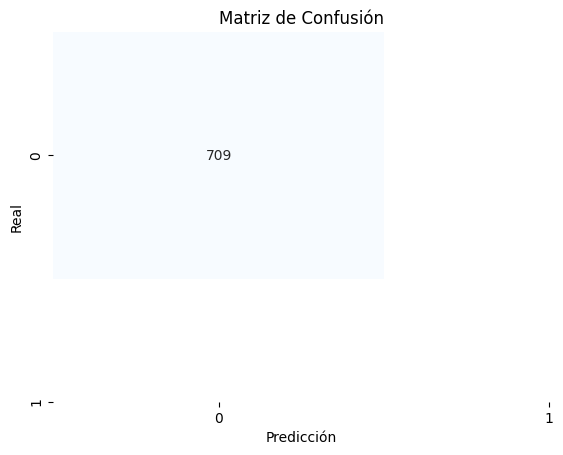



 Variable: 

 Daño
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


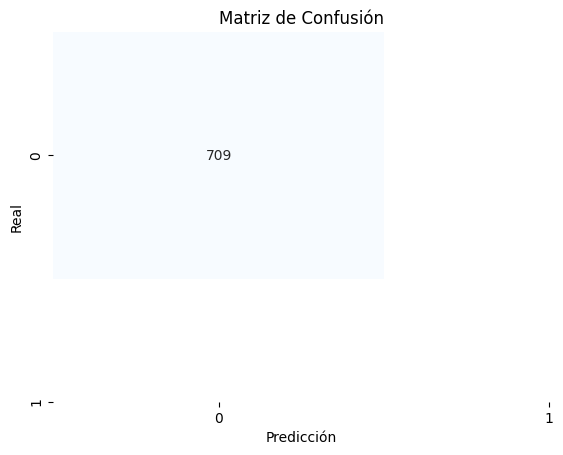



 Variable: 

 Mal Asentada
Presicion:  0.9957866683714444 Recall 0.9950679742657768 f1 0.9950679742657768
[703   0]


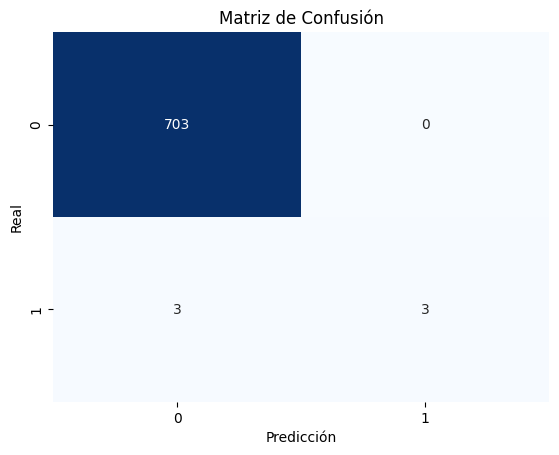



 Variable: 

 Maquina
Presicion:  0.9778396675507233 Recall 0.9775732117534873 f1 0.9775732117534873
[28 12]


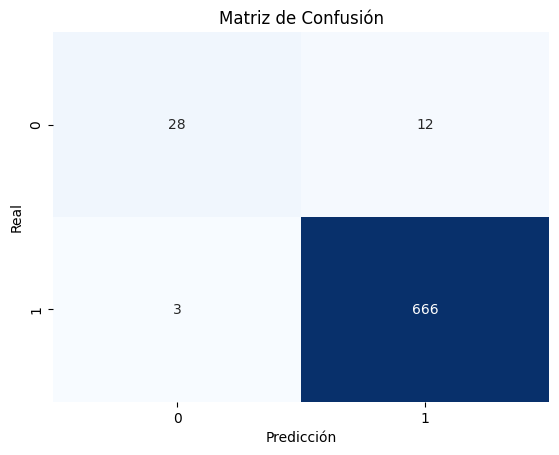



 Variable: 

 Desmoldeo
Presicion:  0.9607738360857635 Recall 0.9600373086774129 f1 0.9600373086774129
[493   6]


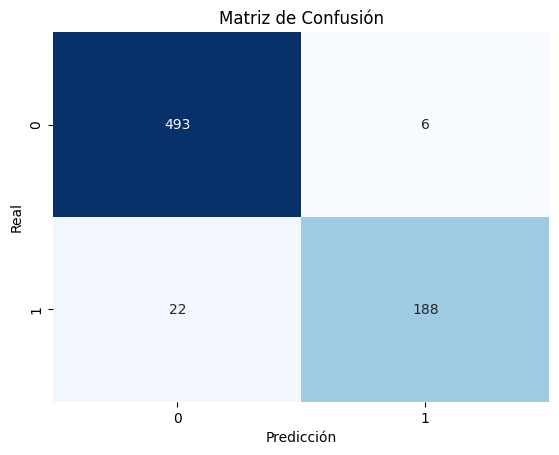



 Variable: 

 Quebrada
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


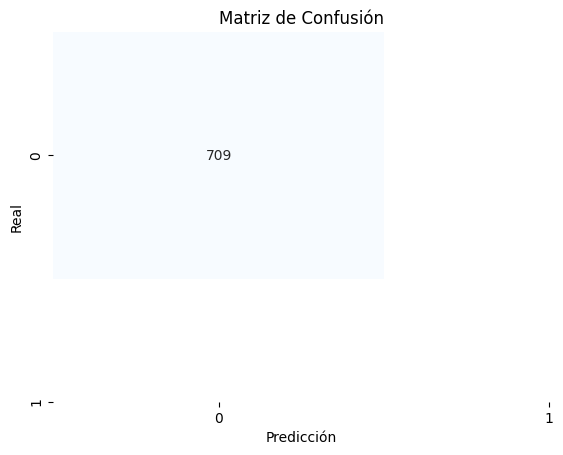



 Variable: 

 Nudo
Presicion:  0.9255986275516184 Recall 0.9252736154475694 f1 0.9252736154475694
[338  31]


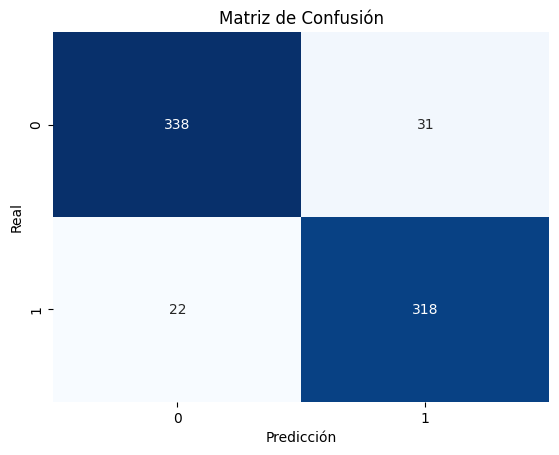



 Variable: 

 Placa Fresca
Presicion:  0.9929976878405149 Recall 0.9910013859678569 f1 0.9910013859678569
[702   0]


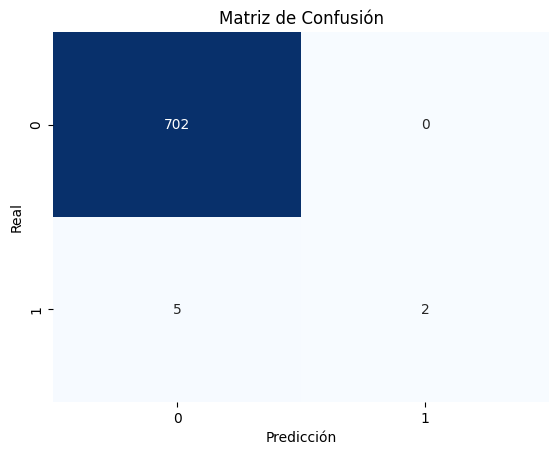



 Variable: 

 Incrustaciones
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


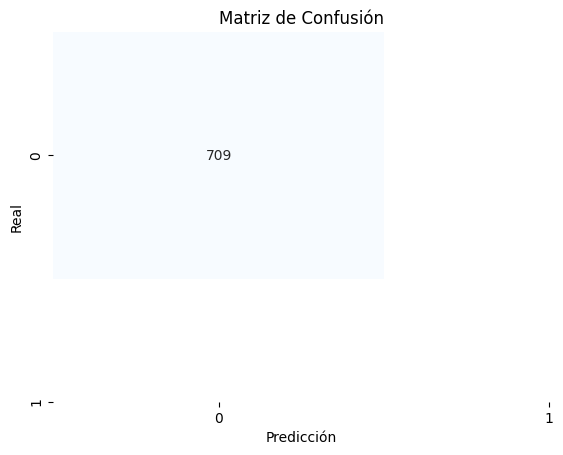



 Variable: 

 Material
Presicion:  0.93159613436168 Recall 0.9301606600398816 f1 0.9301606600398816
[225  36]


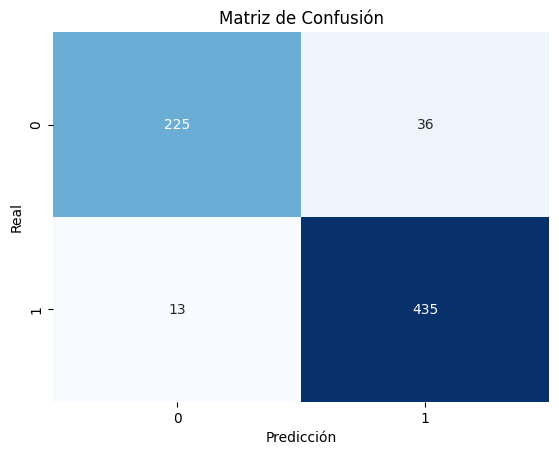



 Variable: 

 Mal Ondulada
Presicion:  0.9698638660510374 Recall 0.9683276014030886 f1 0.9683276014030886
[531   1]


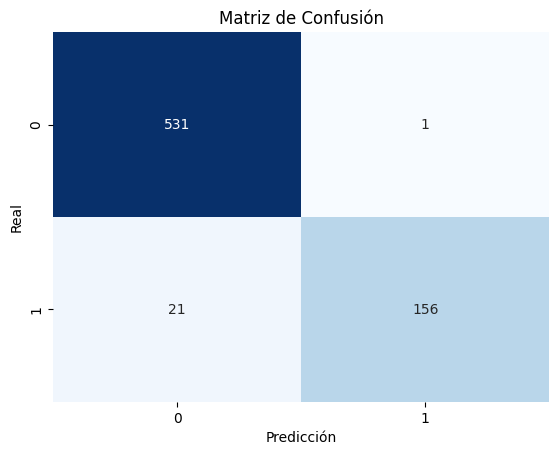



 Variable: 

 Sin Textura
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


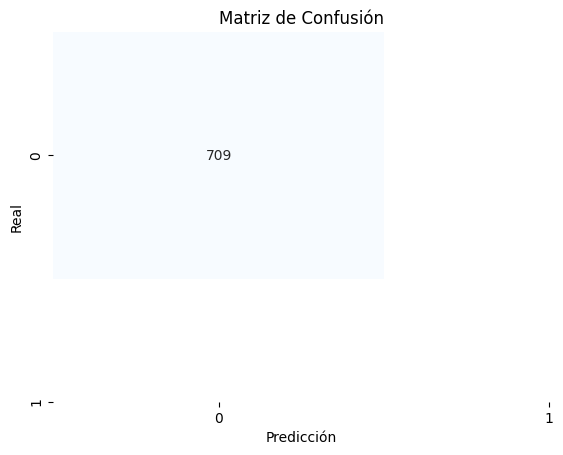



 Variable: 

 Quemado
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


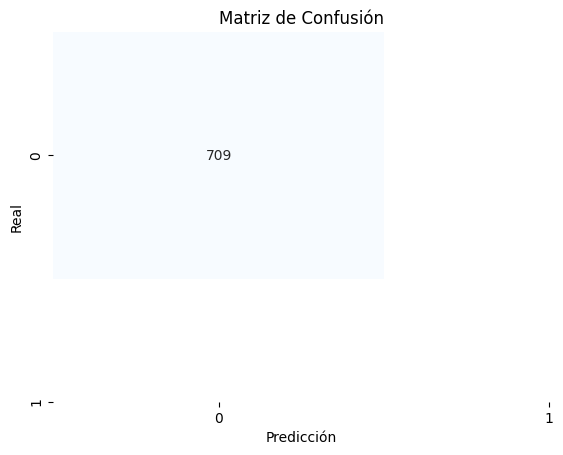



 Variable: 

 Despunte
Presicion:  0.9369119520037531 Recall 0.9361482678738146 f1 0.9361482678738146
[248  31]


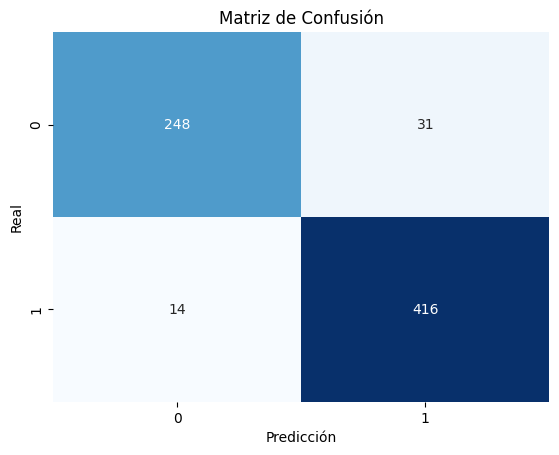



 Variable: 

 Machete
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


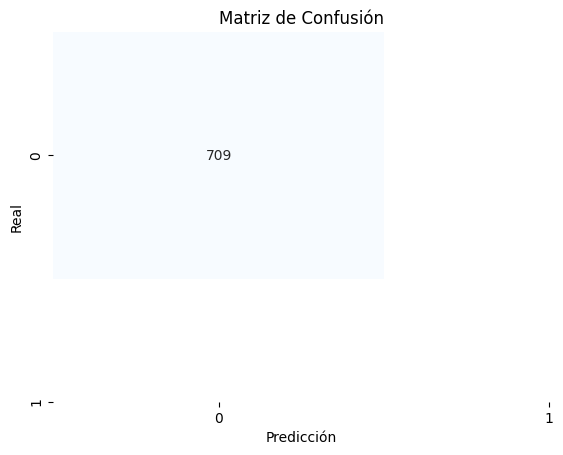



 Variable: 

 Golpe
Presicion:  0.9971811148621094 Recall 0.9978848418309605 f1 0.9978848418309605
[708   0]


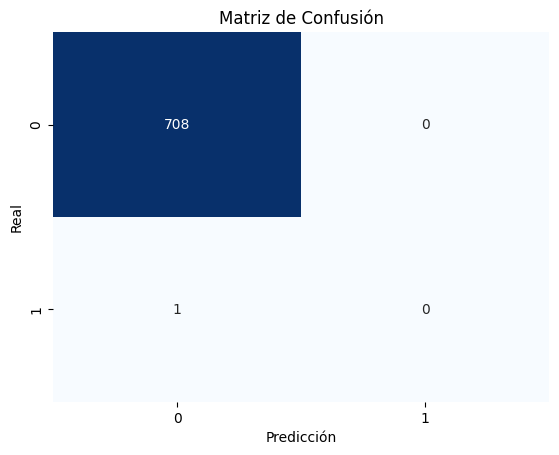



 Variable: 

 Mal Pintada
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


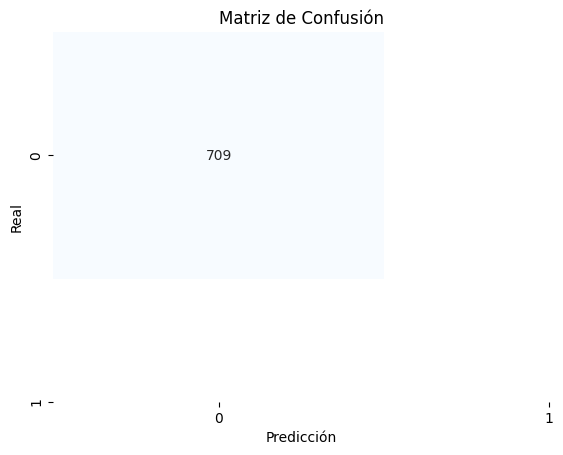



 Variable: 

 Tallon
Presicion:  0.7058334778717796 Recall 0.49982246355734716 f1 0.49982246355734716
[343  10]


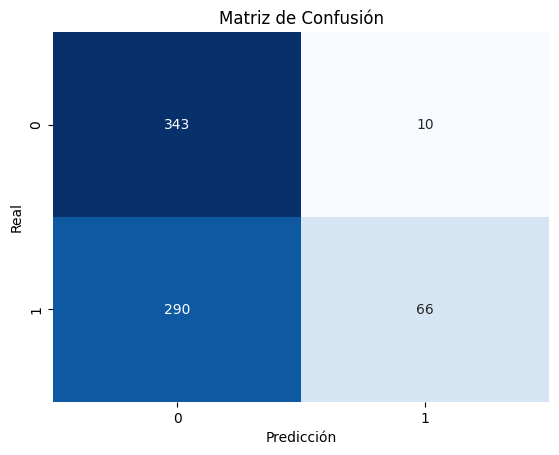



 Variable: 

 Ensayos
Fallo 'Ensayos'


 Variable: 

 Sello Litografico
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


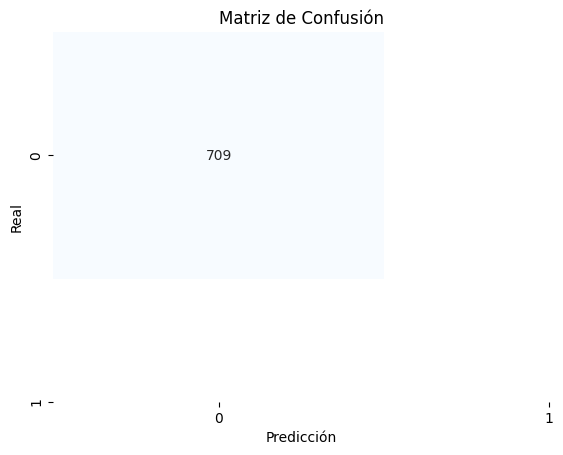



 Variable: 

 Ondulación
Presicion:  0.9916093989136633 Recall 0.9897420398125617 f1 0.9897420398125617
[699   0]


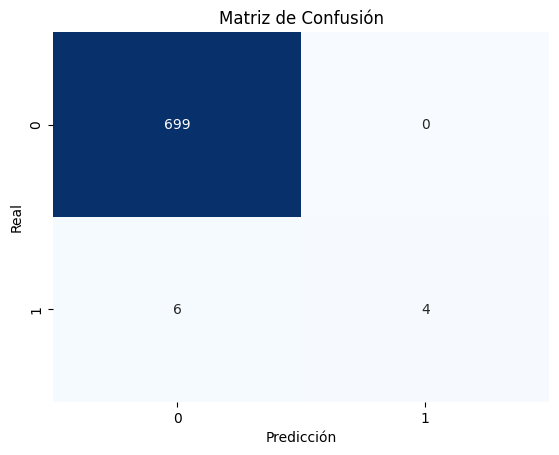



 Variable: 

 Sin
Fallo 'Sin'


 Variable: 

 Pegada
Presicion:  0.9687552301670548 Recall 0.9681259235045113 f1 0.9681259235045113
[592   4]


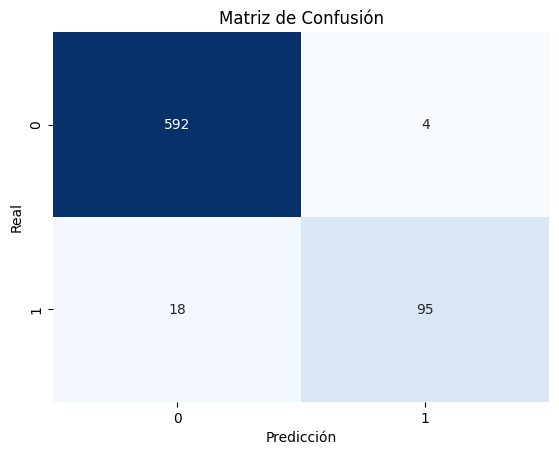



 Variable: 

 Separador
Presicion:  1.0 Recall 1.0 f1 1.0
[708   0]


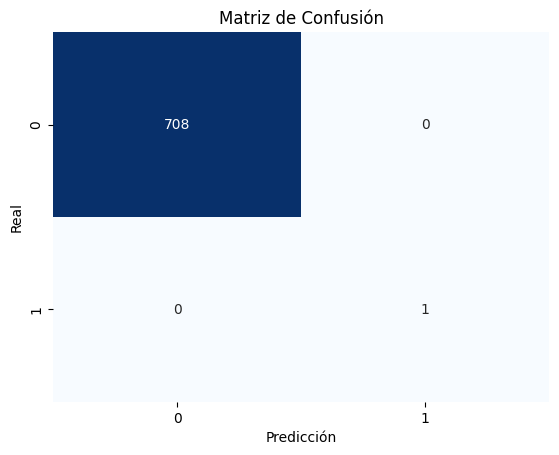



 Variable: 

 Daño Estiba
Presicion:  0.9902305546803467 Recall 0.9897732467257883 f1 0.9897732467257883
[660   0]


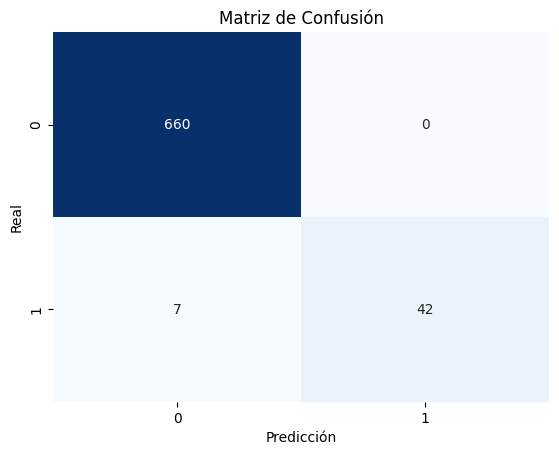



 Variable: 

 Roto
Presicion:  0.9591203748604109 Recall 0.958718118087678 f1 0.958718118087678
[488   8]


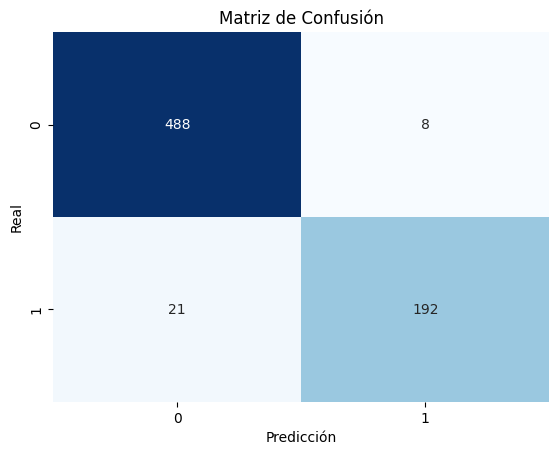



 Variable: 

 Manipulación
Presicion:  0.9291056822361649 Recall 0.9281470122539881 f1 0.9281470122539881
[162  36]


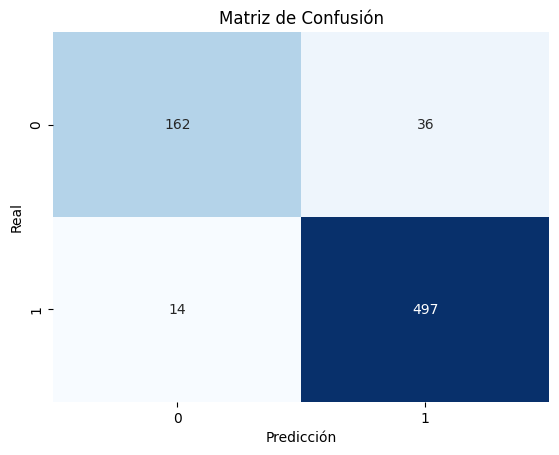



 Variable: 

 Daño Tren
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


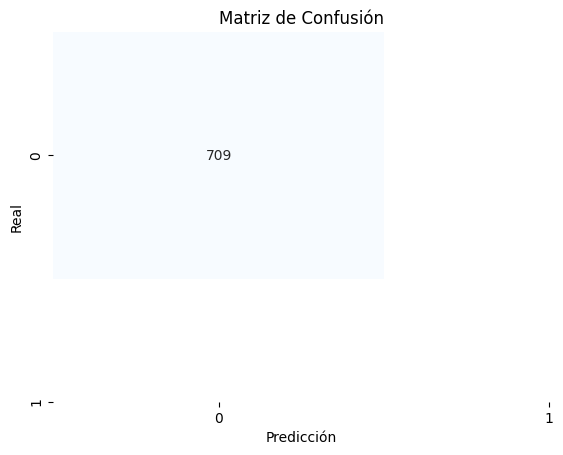



 Variable: 

 Esquinas Levantadas
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


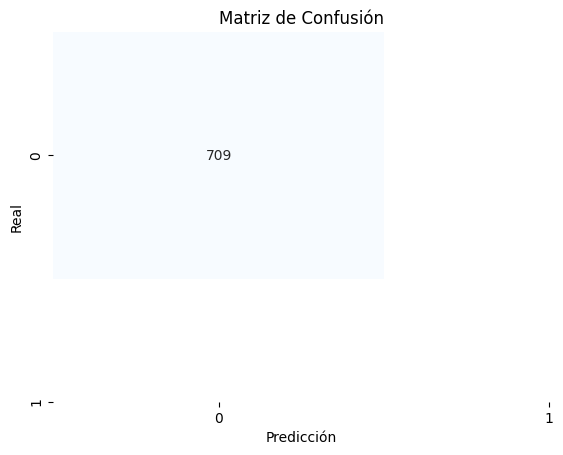



 Variable: 

 Delaminada
Presicion:  0.9449549457403335 Recall 0.9449566511379265 f1 0.9449566511379265
[389  18]


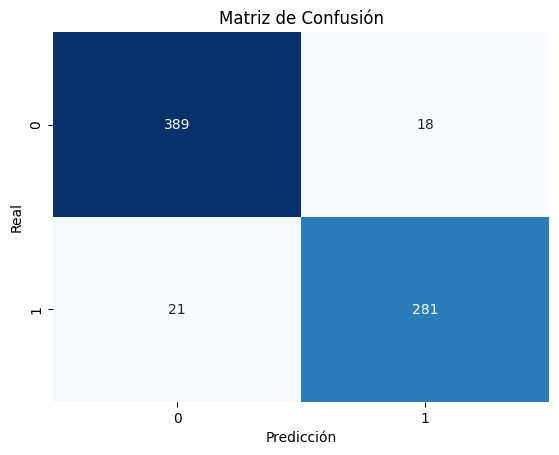



 Variable: 

 Mal Perforado
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


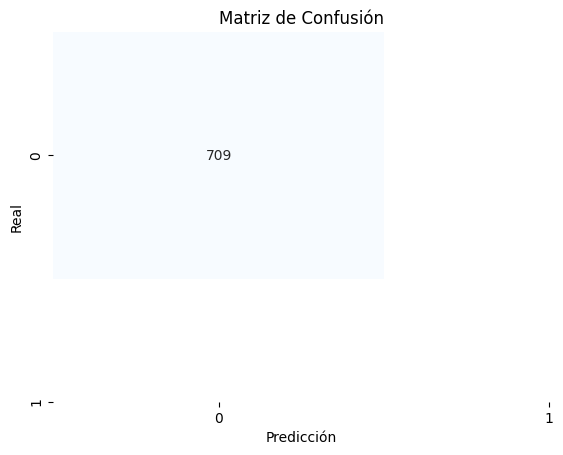



 Variable: 

 Crudo
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


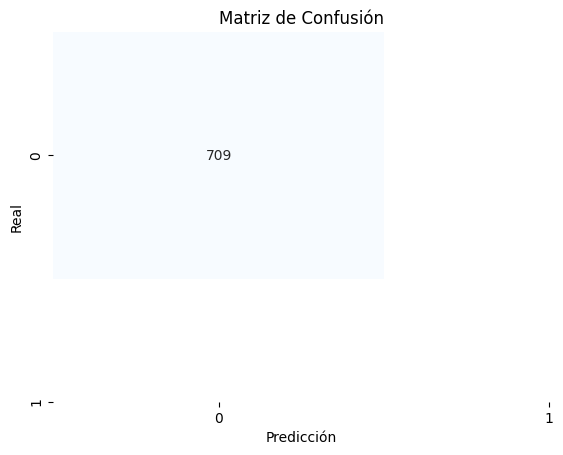



 Variable: 

 Burbuja
Presicion:  0.9943909095176958 Recall 0.9940843519255846 f1 0.9940843519255846
[687   0]


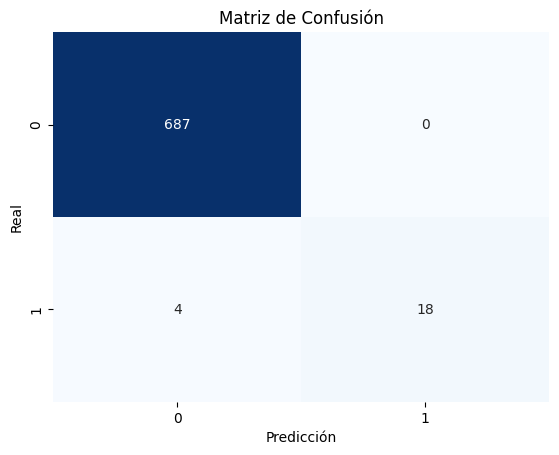

In [92]:
split = BestModel(dfx_nt_nc_m1, dfy_nt_nc_m1)
split.split_data()
dict_choose_labels = {'column':[],'precision':[],
                      'recall':[],'FPR':[],'FNR':[],'f1':[],'TP':[],'TN':[],'FP':[],'FN':[]}

for file in os.listdir('best-nt-m1'):
    if ('.joblib' in file) and ('nt' in file) and ('m1' in file):
        print("\n\n Variable: \n\n",file.split("_")[0])
        try:

            idx = split.dfy.columns.get_loc(file.split("_")[0])
        
            y_test = split.y_test[:,idx]
            
            
            model = joblib.load('best-nt-m1/'+file)
            y_pred = model.predict(split.X_test)
    
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            print("Presicion: ",precision,"Recall",f1,"f1",f1)
            
            cm = confusion_matrix(y_test, y_pred)
            print(cm[0,])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['0', '1'],
                        yticklabels=['0', '1'])
    
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.show()

            dict_choose_labels['column'].append(file.split("_")[0])
            dict_choose_labels['precision'].append(precision)
            dict_choose_labels['recall'].append(recall)
            dict_choose_labels['f1'].append(f1)

            try:
                fpr = cm[0,1]/(cm[0,1]+cm[0,0])
                fnr = cm[1,0]/(cm[1,1]+cm[1,0])
                dict_choose_labels['FPR'].append(fpr)
                dict_choose_labels['FNR'].append(fnr)
                dict_choose_labels['TP'].append(cm[1,1])
                dict_choose_labels['TN'].append(cm[0,0])
                dict_choose_labels['FP'].append(cm[0,1])
                dict_choose_labels['FN'].append(cm[1,0])

            except:
                dict_choose_labels['FPR'].append(1)
                dict_choose_labels['FNR'].append(1)
                dict_choose_labels['TP'].append(0)
                dict_choose_labels['TN'].append(0)
                dict_choose_labels['FP'].append(0)
                dict_choose_labels['FN'].append(0)
        
        except Exception as err:
            print("Fallo", err)

In [57]:
df_choose_labels_nt_m1 = pd.DataFrame(dict_choose_labels)
df_choose_labels_nt_m1

column  precision  recall  FPR  FNR   f1   TP   TN  FP   FN
0            Descolgada       0.98    0.98 0.00 0.16 0.98   65  630   2   12
1            Desplazada       0.95    0.95 0.15 0.02 0.95  517  157  27    8
2                Tallon       0.95    0.95 0.06 0.04 0.95  343  331  22   13
3             Mal Corte       0.95    0.95 0.02 0.12 0.95  180  496   8   25
4                Arruga       0.99    0.99 0.00 0.40 0.99   12  689   0    8
5              Desborde       0.95    0.95 0.05 0.05 0.95  291  383  19   16
6     Sello Litografico       1.00    1.00 1.00 1.00 1.00    0    0   0    0
7           Sin Textura       1.00    1.00 1.00 1.00 1.00    0    0   0    0
8                Mancha       0.95    0.95 0.01 0.13 0.95  205  469   5   30
9          Placa Fresca       0.99    0.99 0.00 0.57 0.99    3  702   0    4
10                Otros       1.00    1.00 0.00 0.00 1.00    2  707   0    0
11             Flexible       0.99    0.99 0.00 0.16 0.99   54  645   0   10
12               Basura       0.94    0.94 0.04 0.07 0.94  322  345  16   26
13          Trasparente       1.00    1.00 1.00 1.00 1.00    0    0   0    0
14        Mal Perforado       1.00    1.00 1.00 1.00 1.00    0    0   0    0
15          Dimensiones       0.99    0.99 0.00 0.36 0.99    7  698   0    4
16               Carpas       0.99    0.99 0.01 0.11 0.99   34  667   4    4
17        Desmoldeadora       0.98    0.97 0.00 0.12 0.97  130  561   0   18
18               Rajada       0.94    0.94 0.07 0.06 0.94  312  352  25   20
19               Fisura       0.98    0.98 0.00 0.31 0.98   35  658   0   16
20              Caponeo       0.98    0.97 0.00 0.23 0.97   62  629   0   18
21              Espesor       0.98    0.98 0.00 0.19 0.98   62  630   2   15
22               Pandeo       1.00    1.00 1.00 1.00 1.00    0    0   0    0
23                 Daño       1.00    1.00 1.00 1.00 1.00    0    0   0    0
24            Daño Tren       1.00    1.00 1.00 1.00 1.00    0    0   0    0
25              Maquina       0.98    0.98 0.28 0.01 0.98  665   29  11    4
26            Desmoldeo       0.96    0.96 0.01 0.10 0.96  188  494   5   22
27             Quebrada       1.00    1.00 1.00 1.00 1.00    0    0   0    0
28          Mal Pintada       1.00    1.00 1.00 1.00 1.00    0    0   0    0
29          Daño Estiba       0.99    0.99 0.00 0.16 0.99   41  660   0    8
30                 Nudo       0.93    0.93 0.08 0.06 0.93  320  338  31   20
31         Mal Asentada       1.00    1.00 0.00 0.33 1.00    4  703   0    2
32         Mal Ondulada       0.97    0.97 0.00 0.13 0.97  154  531   1   23
33       Incrustaciones       1.00    1.00 1.00 1.00 1.00    0    0   0    0
34             Material       0.93    0.93 0.13 0.03 0.93  435  227  34   13
35  Esquinas Levantadas       1.00    1.00 1.00 1.00 1.00    0    0   0    0
36            Sin Pulir       1.00    1.00 1.00 1.00 1.00    0    0   0    0
37    Perdida De Grados       1.00    1.00 0.00 0.00 1.00    1  708   0    0
38              Quemado       1.00    1.00 1.00 1.00 1.00    0    0   0    0
39             Despunte       0.94    0.94 0.11 0.03 0.93  416  247  32   14
40     Piel De Elefante       0.99    0.99 0.00 0.14 0.99   31  673   0    5
41              Machete       1.00    1.00 1.00 1.00 1.00    0    0   0    0
42                Golpe       1.00    1.00 0.00 1.00 1.00    0  708   0    1
43               Tallon       0.70    0.58 0.03 0.82 0.50   65  343  10  291
44           Ondulación       0.99    0.99 0.00 0.40 0.99    6  699   0    4
45               Pegada       0.97    0.97 0.00 0.16 0.97   95  594   2   18
46            Separador       1.00    1.00 0.00 0.00 1.00    1  708   0    0
47                 Roto       0.96    0.95 0.01 0.12 0.95  188  489   7   25
48         Manipulación       0.93    0.93 0.19 0.03 0.93  498  161  37   13
49           Daño Molde       1.00    1.00 0.00 0.40 1.00    3  704   0    2
50           Delaminada       0.94    0.94 0.04 0.07 0.94  281  389  18   21
51           

In [42]:
df_choose_labels_nt_m1_filter = df_choose_labels_nt_m1.loc[(df_choose_labels_nt_m1['TP']>100) | (df_choose_labels_nt_m1['FNR']<0.03) & (df_choose_labels_nt_m1['TP']>10)]
df_choose_labels_nt_m1_filter.reset_index()

NameError: name 'df_choose_labels_nt_m1' is not defined

# Mejor modelo nt m1 sin algunos predictores

In [136]:
#Carga de datos tanto de la maquina 1 como de la maquina 2

dfx_nt_nc_m1 = pd.read_csv('nt-data-without-variables/dfx_nt_nc_m1.csv')
dfy_nt_nc_m1 = pd.read_csv('nt-data-without-variables/dfy_nt_nc_m1.csv')

In [138]:
dfx_nt_nc_m1.head()

PP_Hidro_Cemento_Kg  PP_Hidro_Carbonato_Kg  PP_Hidro_Celulosa_Kg  \
0               925.00                  50.00                 32.00   
1               925.00                  50.00                 32.00   
2               925.00                  50.00                 32.00   
3               925.00                  50.00                 32.00   
4               925.00                  50.00                 32.00   

   PP_Hidro_Pva_Kg  PP_Hidro_Agua_Kg  PP_Hidro_SolReales_%  \
0            23.00           2437.00                  0.23   
1            20.00           2437.00                  0.22   
2            20.00           2437.00                  0.22   
3            20.00           2437.00                  0.22   
4            20.00           2437.00                  0.22   

   PP_Hidro_CelulosaS_%  PP_Maq_Resi_ml  PP_Refi_EE_AMP  PP_Refi_CelulosaH_%  \
0                  0.04           35.33           31.00                 0.10   
1                  0.04           70.00           31.00                 0.11   
2                  0.04           66.00           31.00                 0.11   
3                  0.04           66.00           31.00                 0.11   
4                  0.04           67.07           31.00                 0.11   

   ...  PP_Maq_FlocCanalS_%  PP_Maq_FlocTkS_%  PP_Maq_FlocFormS_%  \
0  ...                 0.09              0.00                0.00   
1  ...                 0.09              0.00                0.00   
2  ...                 0.09              0.00                0.00   
3  ...                 0.09              0.00                0.00   
4  ...                 0.09              0.00                0.00   

   PP_MaqTCE_Densidad_g/cm3  PP_Maq_TCES_%  PP_Maq_CilinS_%  PP_Maq_Cono1S_%  \
0                      1.03           0.06             0.01             0.02   
1                      1.03           0.06             0.02             0.02   
2                      1.03           0.05             0.02             0.02   
3                      1.05           0.06             0.02             0.02   
4                      1.03           0.06             0.02             0.02   

   PP_Maq_MolinoS_%  PP_Maq_P1H_%  PP_Maq_P3H_%  
0              0.21          0.48          0.36  
1              0.28          0.48          0.37  
2              0.28          0.46          0.39  
3              0.28          0.45          0.35  
4              0.28          0.46          0.35  

[5 rows x 34 columns]

In [ ]:
for columns in dfx_nt_nc_m1.columns:
    if "Tipo" in columns:
        print(columns, "Tipo" in columns)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9143258947761633 Recall 0.9090912808305097 f1 0.9090912808305097


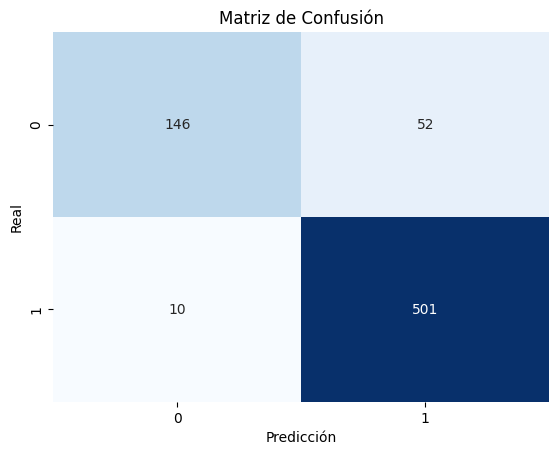

Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Presicion:  0.9699089361719859 Recall 0.9703079326557553 f1 0.9703079326557553


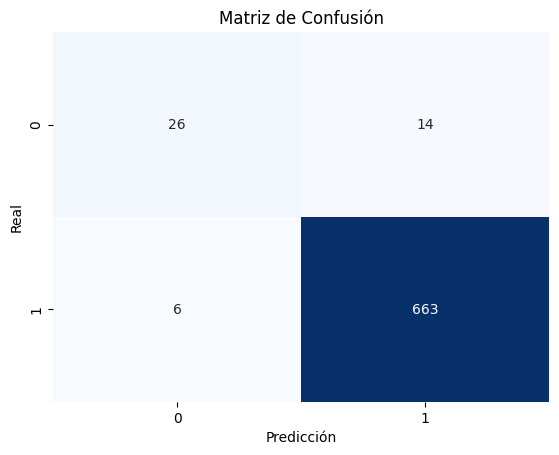

In [ ]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para todos los labels

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

b_model = BestModel(dfx_nt_nc_m1, dfy_nt_nc_m1)
b_model.split_data()
joblib.dump(b_model.scaler, 'scaler-nt-m1-without-variables/scaler.joblib')

for col in dfy_nt_nc_m1.columns:
    b_model.grid_search_cv(col, extra_trees, param_grid, f'best-nt-m1-without-variables/{col}_aut_m1_best_extra_tree_classifier')

Vairbale:  Separador aut
Presicion:  1.0 Recall 1.0 f1 1.0
[708   0]


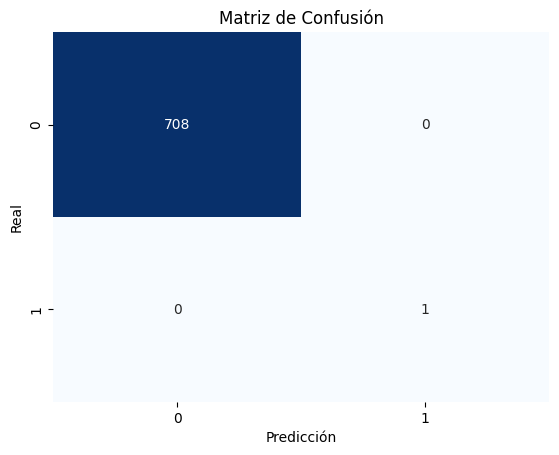

Vairbale:  Nudo aut
Presicion:  0.9090082121593545 Recall 0.9083595338349484 f1 0.9083595338349484
[330  39]


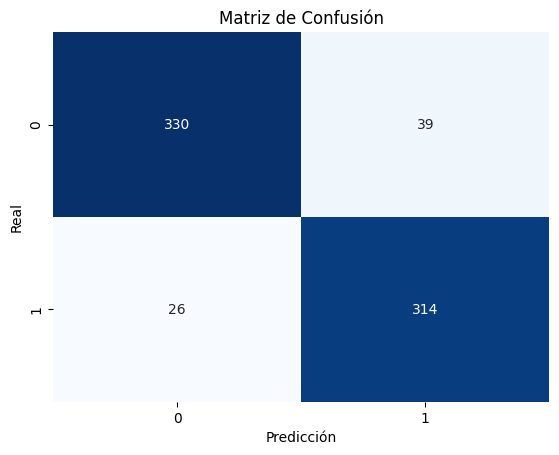

Vairbale:  Descolgada aut
Presicion:  0.9680289193631649 Recall 0.9652639608878795 f1 0.9652639608878795
[631   1]


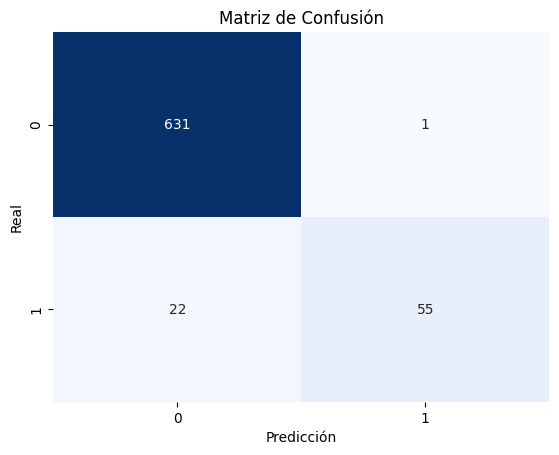

Vairbale:  Fisura aut
Presicion:  0.9544012979283694 Recall 0.9406602935798987 f1 0.9406602935798987
[658   0]


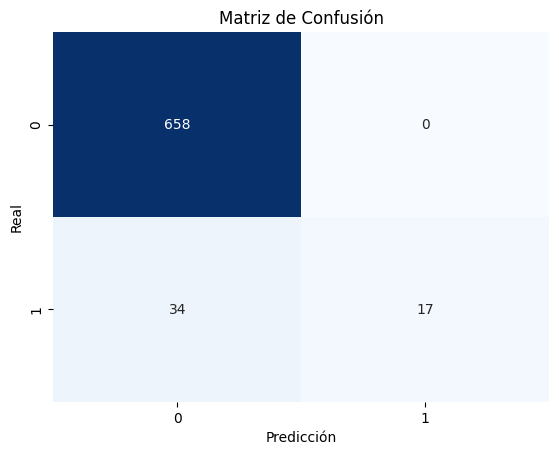

Vairbale:  Mal Ondulada aut
Presicion:  0.9493508480586729 Recall 0.9442466499091563 f1 0.9442466499091563
[531   1]


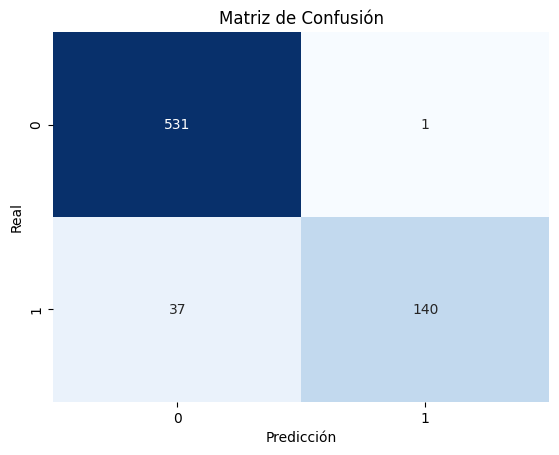

Vairbale:  Perdida De Grados aut
Presicion:  1.0 Recall 1.0 f1 1.0
[708   0]


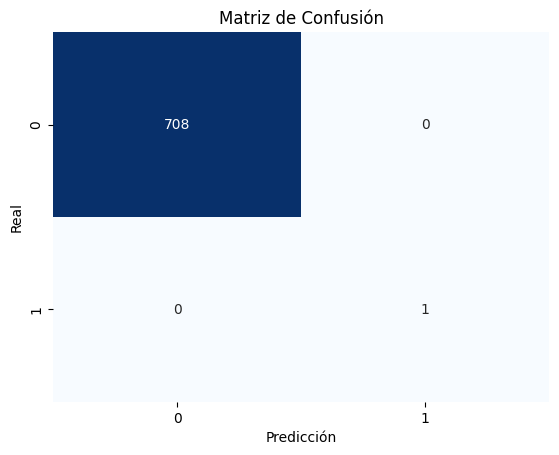

Vairbale:  Incrustaciones aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


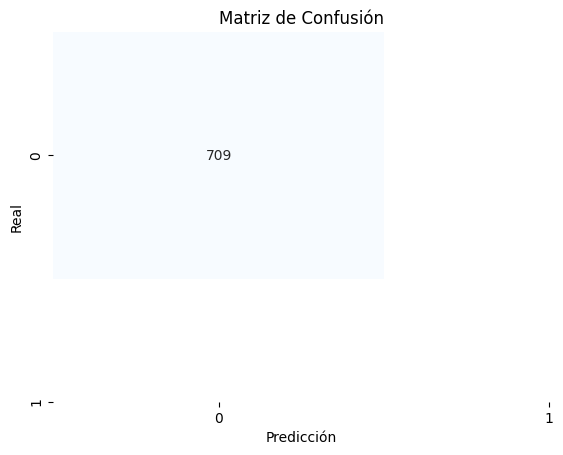

Vairbale:  Quebrada aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


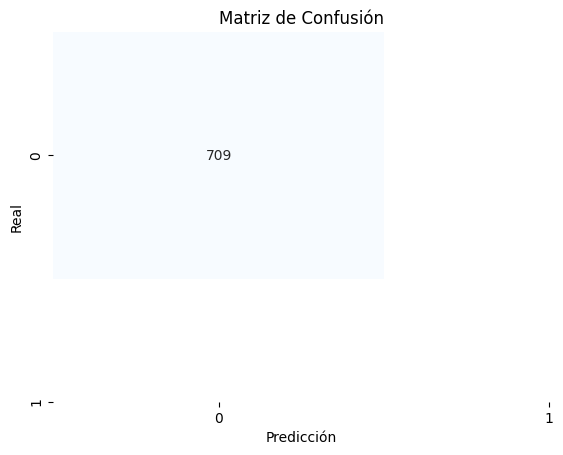

Vairbale:  Muestra aut
Fallo 'Muestra'
Vairbale:  Desmoldeadora aut
Presicion:  0.9577987802509655 Recall 0.9565243166446092 f1 0.9565243166446092
[556   5]


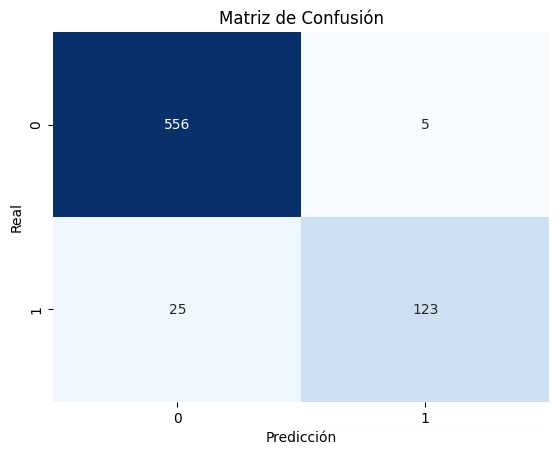

Vairbale:  Espesor aut
Presicion:  0.9608918401618269 Recall 0.9548113013874208 f1 0.9548113013874208
[632   0]


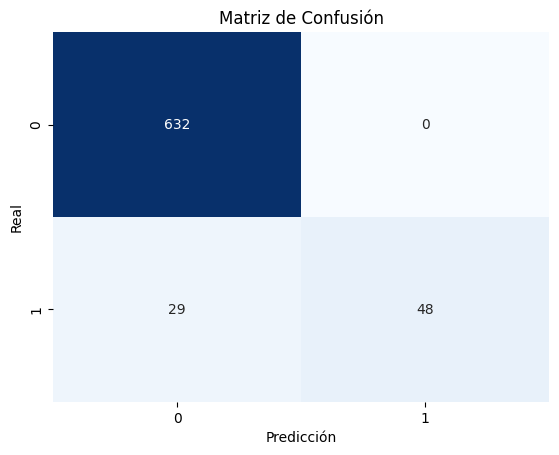

Vairbale:  Exceso Pecas
Fallo 'Exceso'
Vairbale:  Sello Litografico aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


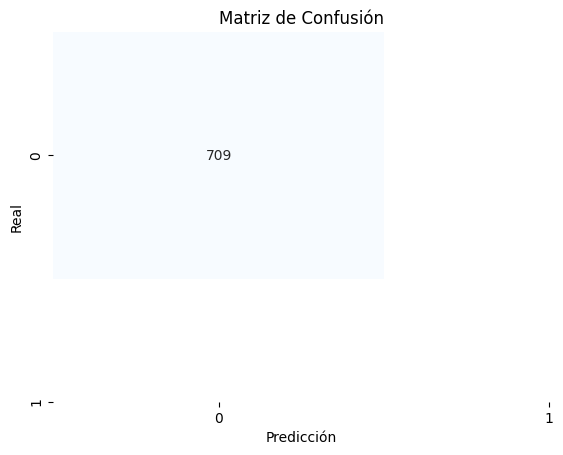

Vairbale:  Daño Molde aut
Presicion:  0.9859453609744551 Recall 0.9894341980621211 f1 0.9894341980621211
[704   0]


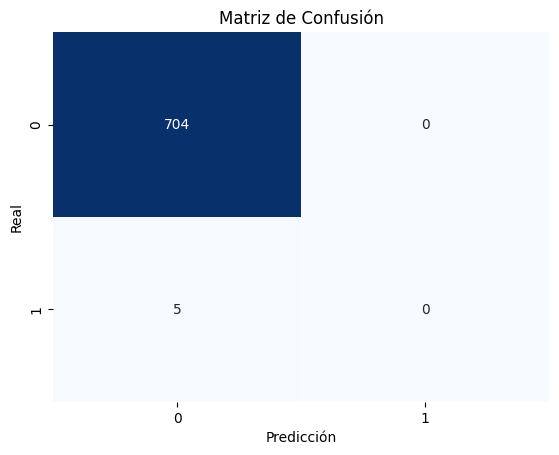

Vairbale:  Sin Texturizar
Fallo 'Sin'
Vairbale:  Manipulación aut
Presicion:  0.9143258947761633 Recall 0.9090912808305097 f1 0.9090912808305097
[146  52]


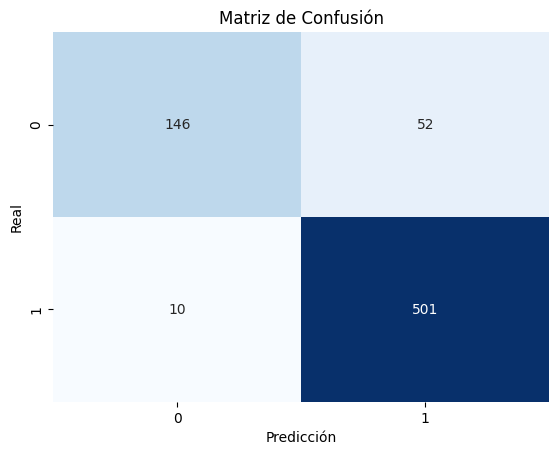

Vairbale:  Mal Pintada aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


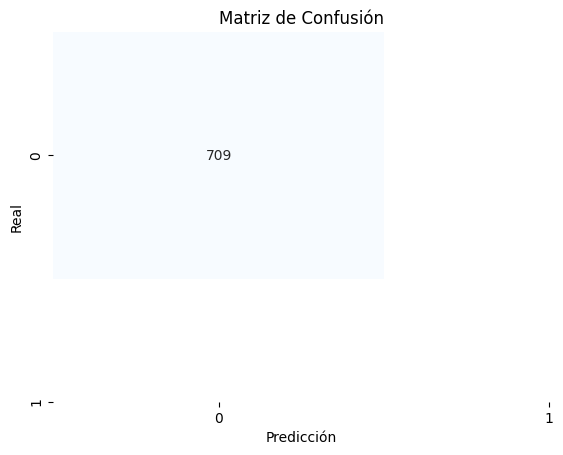

Vairbale:  Sin Textura aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


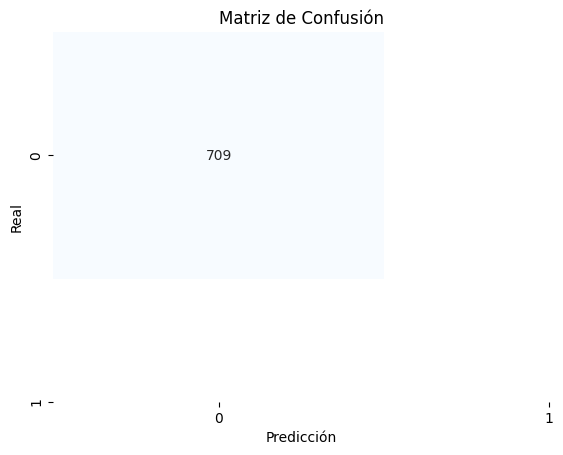

Vairbale:  Caponeo aut
Presicion:  0.9583301277941617 Recall 0.9515486084446801 f1 0.9515486084446801
[629   0]


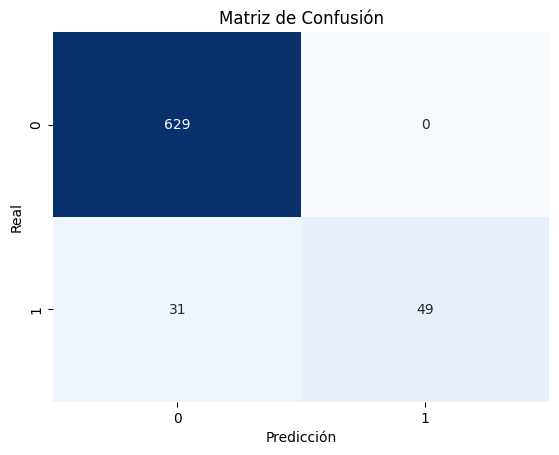

Vairbale:  Machete aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


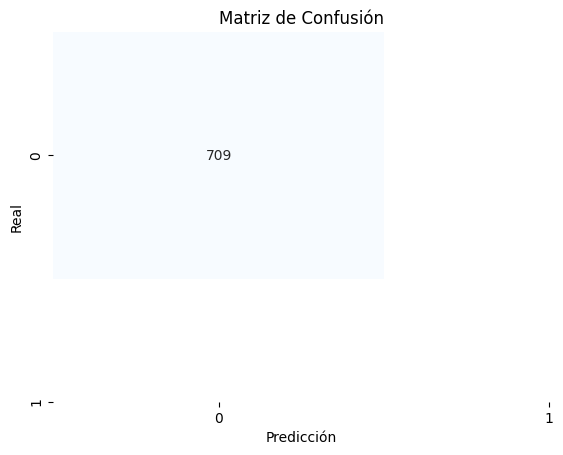

Vairbale:  Mal Asentada aut
Presicion:  0.9957866683714444 Recall 0.9950679742657768 f1 0.9950679742657768
[703   0]


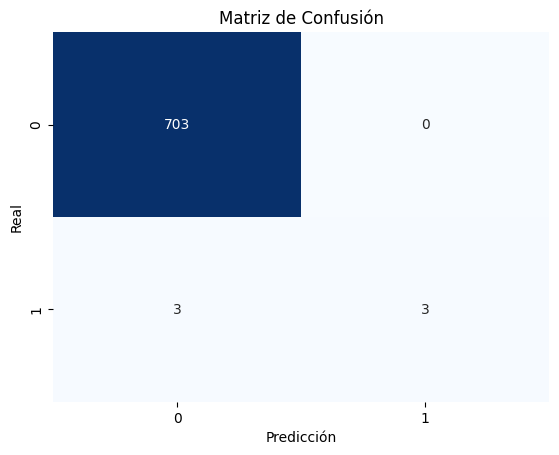

Vairbale:  Material aut
Presicion:  0.9110919494213512 Recall 0.9083408354830673 f1 0.9083408354830673
[213  48]


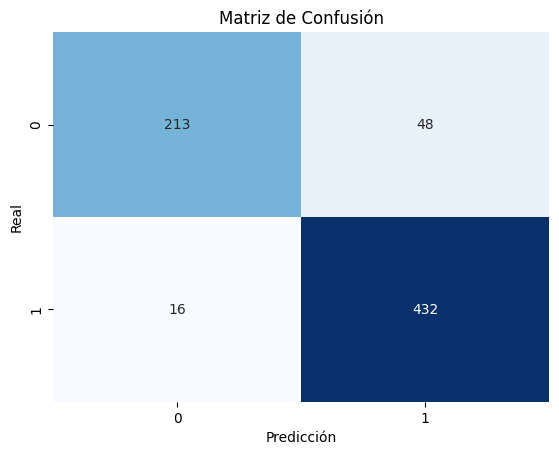

Vairbale:  Daño Tren aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


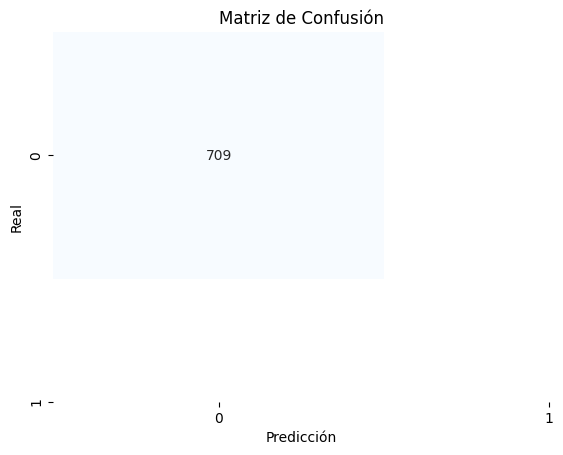

Vairbale:  Roto aut
Presicion:  0.9198430414049473 Recall 0.917810488730419 f1 0.917810488730419
[482  14]


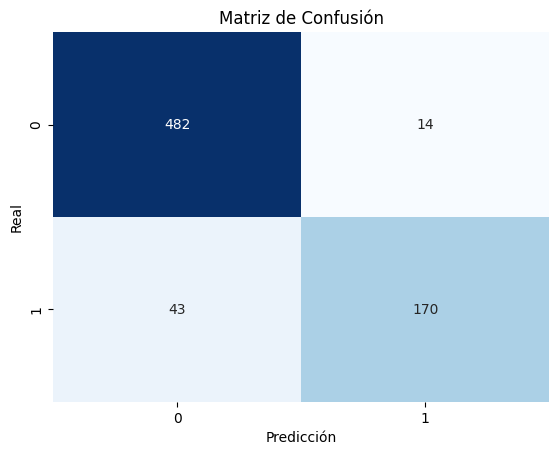

Vairbale:  Delaminada aut
Presicion:  0.9253149377012246 Recall 0.9250518547764984 f1 0.9250518547764984
[386  21]


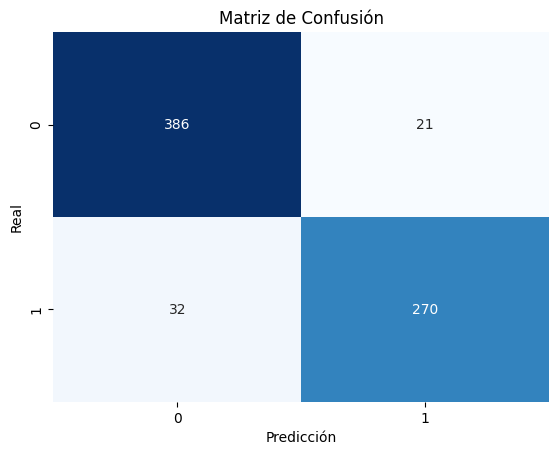

Vairbale:  Dimensiones aut
Presicion:  0.9916095012181049 Recall 0.9899687430207501 f1 0.9899687430207501
[698   0]


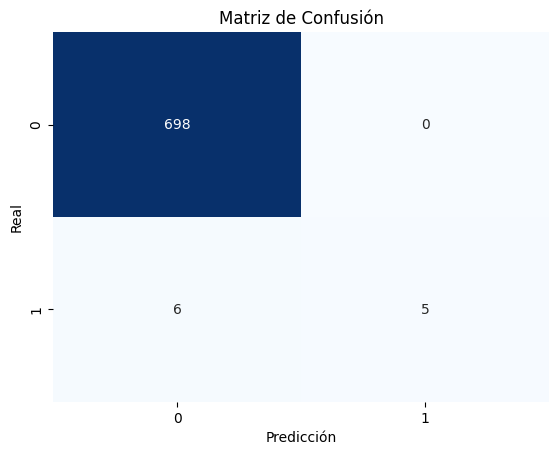

Vairbale:  Desborde aut
Presicion:  0.9364088040298154 Recall 0.9352850802651408 f1 0.9352850802651408
[371  31]


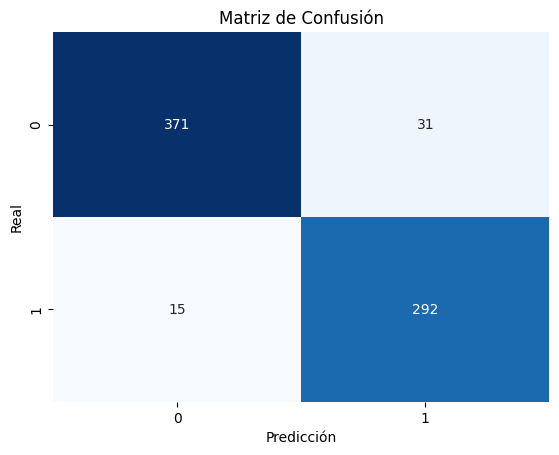

Vairbale:  Ondulación aut
Presicion:  0.9916093989136633 Recall 0.9897420398125617 f1 0.9897420398125617
[699   0]


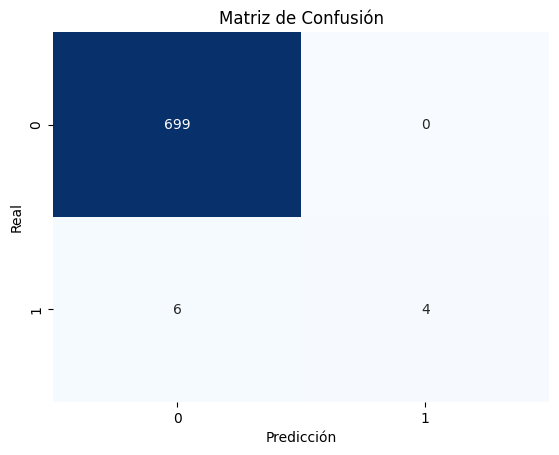

Vairbale:  Burbuja aut
Presicion:  0.9874702105928699 Recall 0.9857152909840847 f1 0.9857152909840847
[687   0]


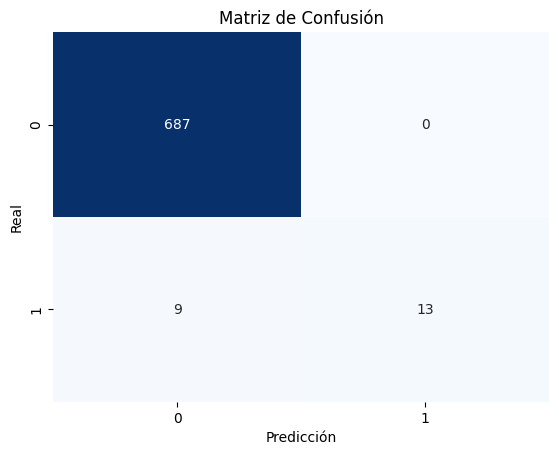

Vairbale:  Trasparente aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


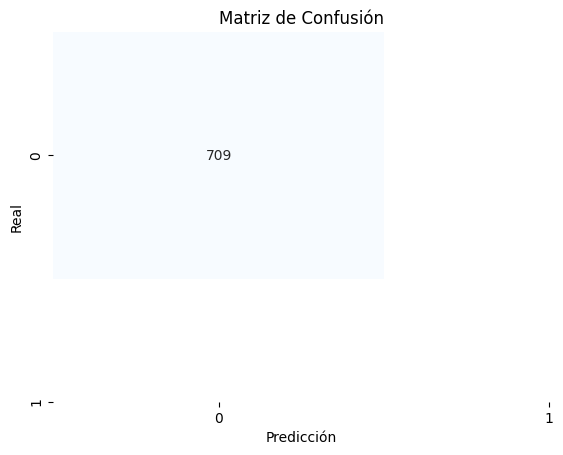

Vairbale:  Maquina aut
Presicion:  0.9699089361719859 Recall 0.9703079326557553 f1 0.9703079326557553
[26 14]


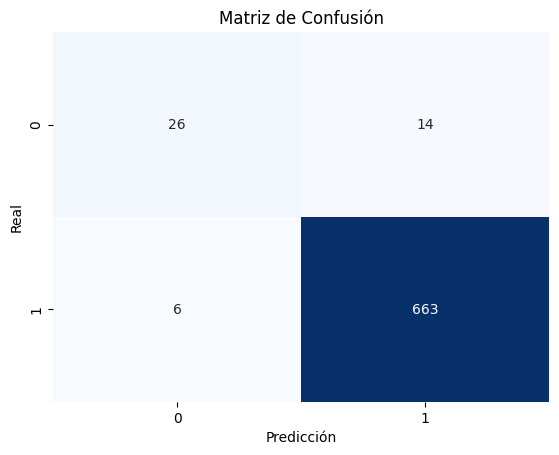

Vairbale:  Quemado aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


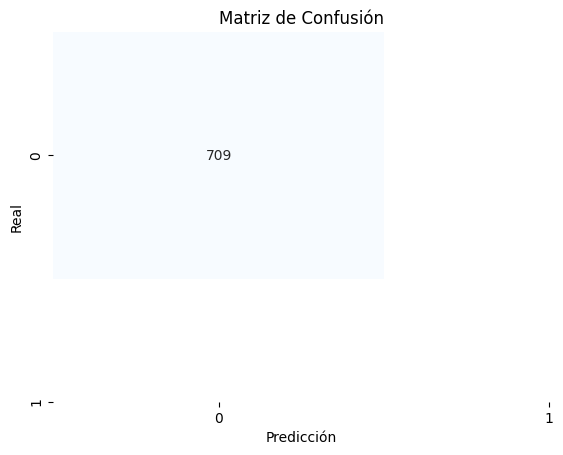

Vairbale:  Pandeo aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


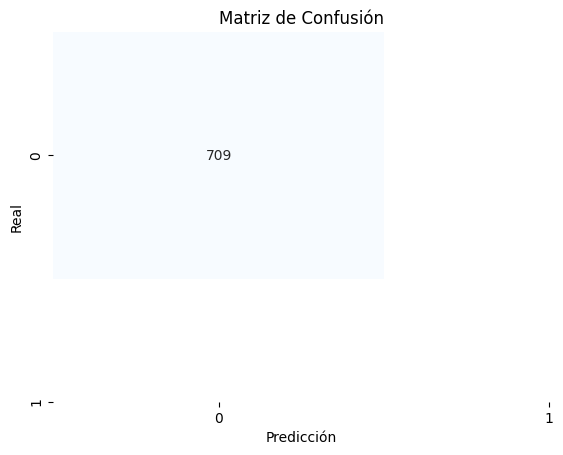

Vairbale:  Carpas aut
Presicion:  0.9809033955448189 Recall 0.9810527238537268 f1 0.9810527238537268
[667   4]


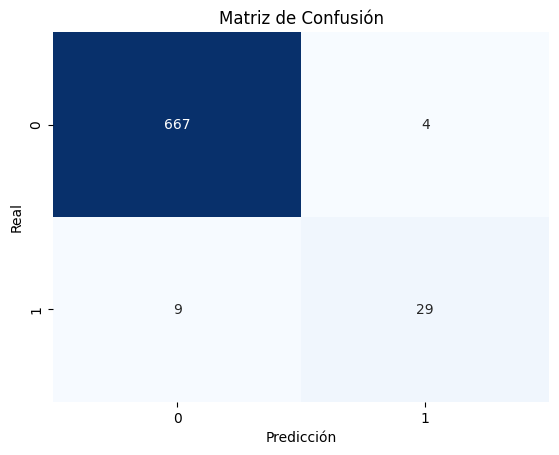

Vairbale:  Arruga aut
Presicion:  0.9820038656427937 Recall 0.9773358505414976 f1 0.9773358505414976
[689   0]


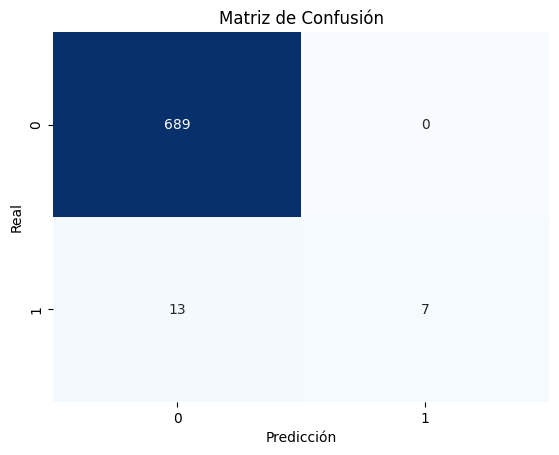

Vairbale:  Rajada aut
Presicion:  0.9155841200770484 Recall 0.9154132792738899 f1 0.9154132792738899
[344  33]


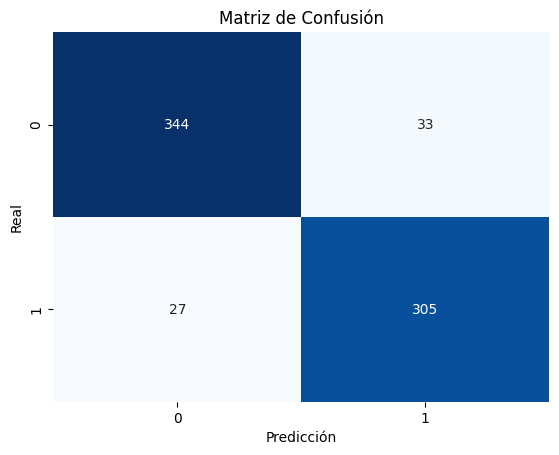

Vairbale:  Tallon Montacargas
Presicion:  0.7116817211989553 Recall 0.47667166505827335 f1 0.47667166505827335
[346   7]


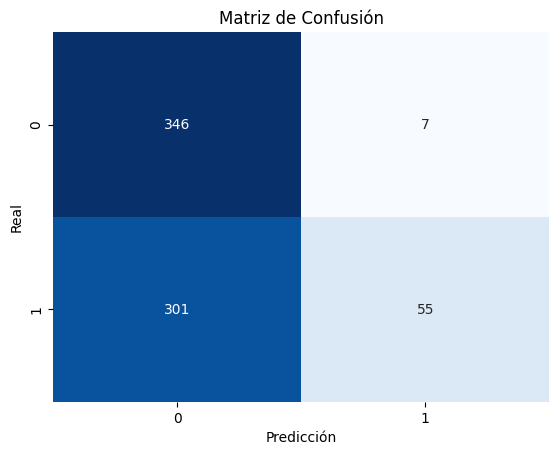

Vairbale:  Crudo aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


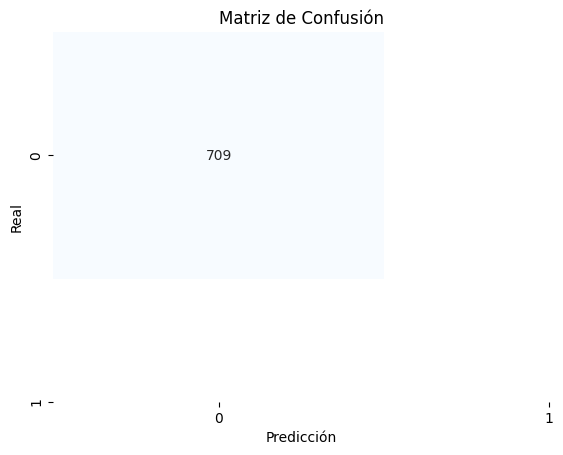

Vairbale:  Daño aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


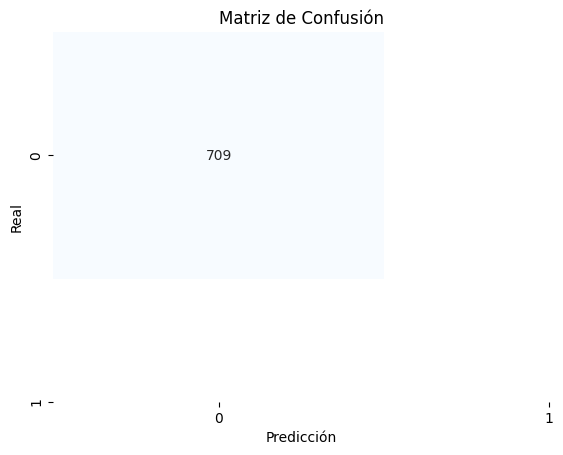

Vairbale:  Cuarteamineto Pintura
Fallo 'Cuarteamineto'
Vairbale:  Despunte aut
Presicion:  0.909564878576411 Recall 0.90730397244208 f1 0.90730397244208
[232  47]


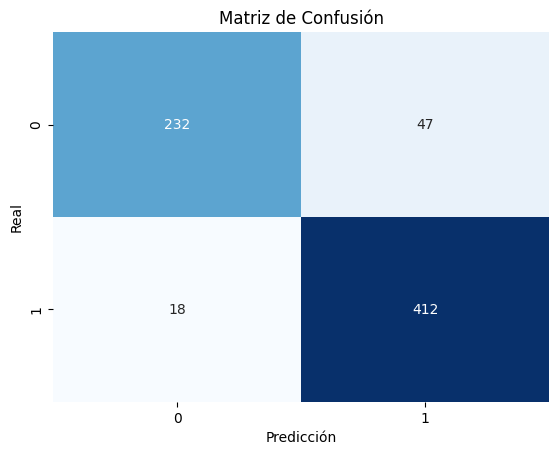

Vairbale:  Piel De Elefante aut
Presicion:  0.9820117851694375 Recall 0.9797319812161938 f1 0.9797319812161938
[673   0]


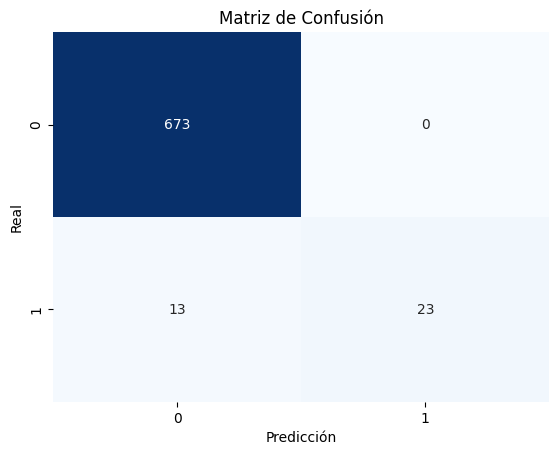

Vairbale:  Pegada aut
Presicion:  0.961678091380298 Recall 0.9583622716145451 f1 0.9583622716145451
[595   1]


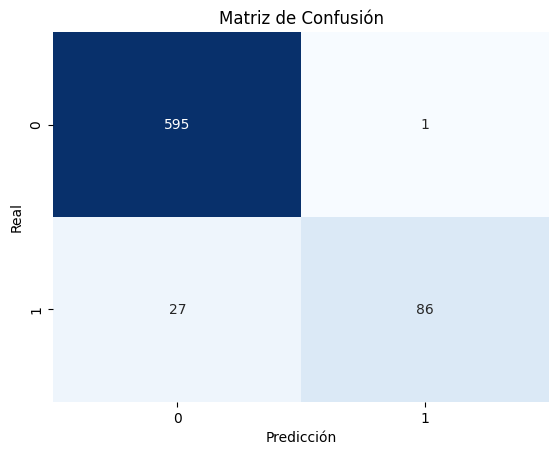

Vairbale:  Mal Corte aut
Presicion:  0.9335349849757771 Recall 0.9325965505001423 f1 0.9325965505001423
[491  13]


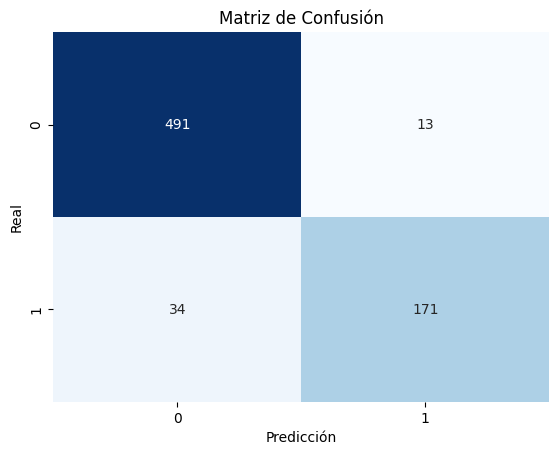

Vairbale:  Basura aut
Presicion:  0.9224899923535871 Recall 0.9224120542307989 f1 0.9224120542307989
[336  25]


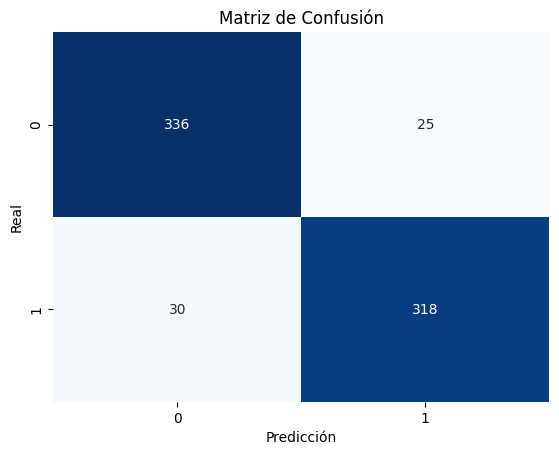

Vairbale:  Otros aut
Presicion:  1.0 Recall 1.0 f1 1.0
[707   0]


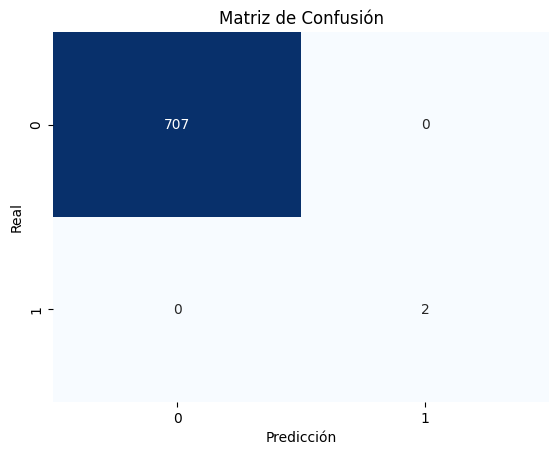

Vairbale:  Flexible aut
Presicion:  0.966054775487864 Recall 0.9607950098773301 f1 0.9607950098773301
[645   0]


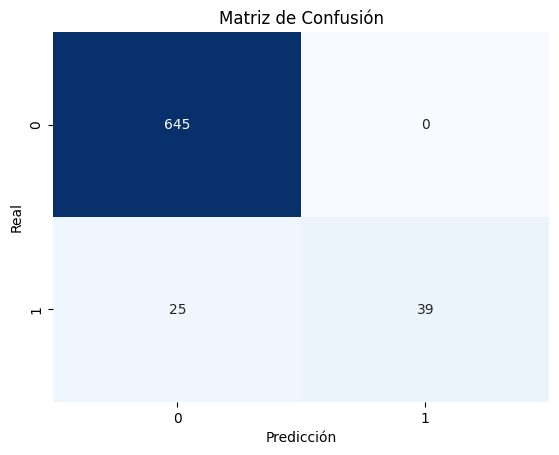

Vairbale:  Desplazada aut
Presicion:  0.937921493367862 Recall 0.9364693037952069 f1 0.9364693037952069
[150  34]


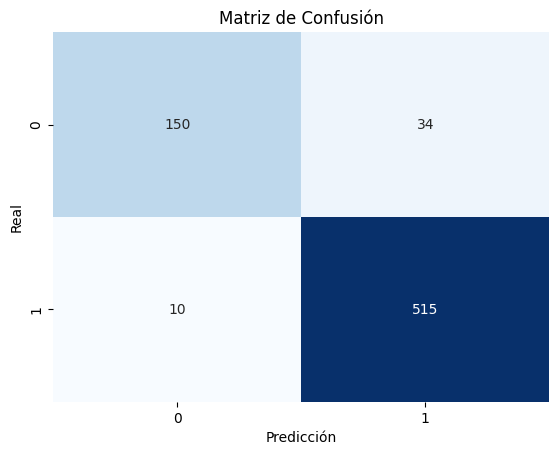

Vairbale:  Desmoldeo aut
Presicion:  0.9575888186984345 Recall 0.9554270454450776 f1 0.9554270454450776
[496   3]


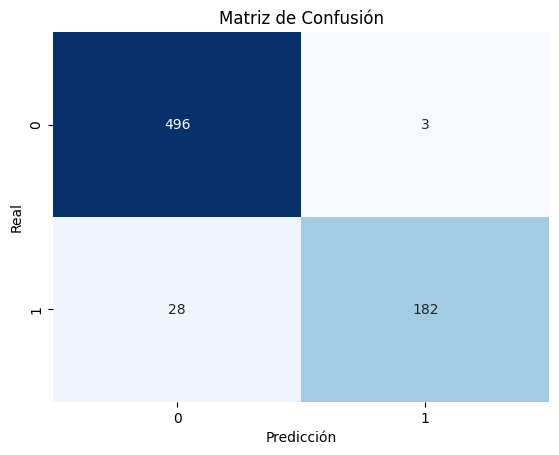

Vairbale:  Golpe aut
Presicion:  0.9971811148621094 Recall 0.9978848418309605 f1 0.9978848418309605
[708   0]


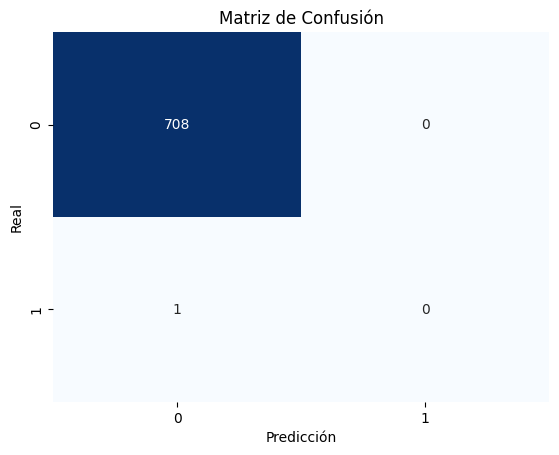

Vairbale:  Esquinas Levantadas aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


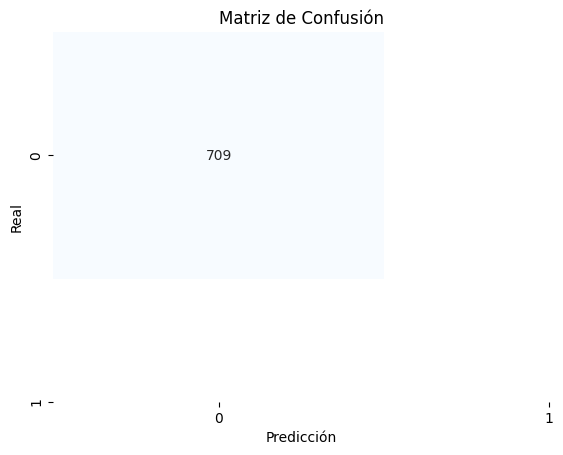

Vairbale:  Daño Estiba aut
Presicion:  0.9699713362755358 Recall 0.9647335928667654 f1 0.9647335928667654
[660   0]


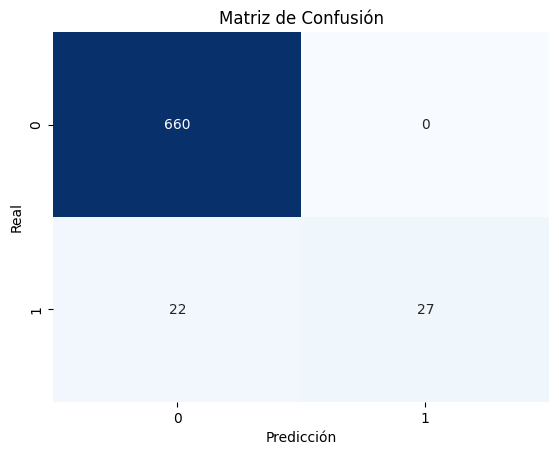

Vairbale:  Ensayos Calidad
Fallo 'Ensayos'
Vairbale:  Mal Perforado aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


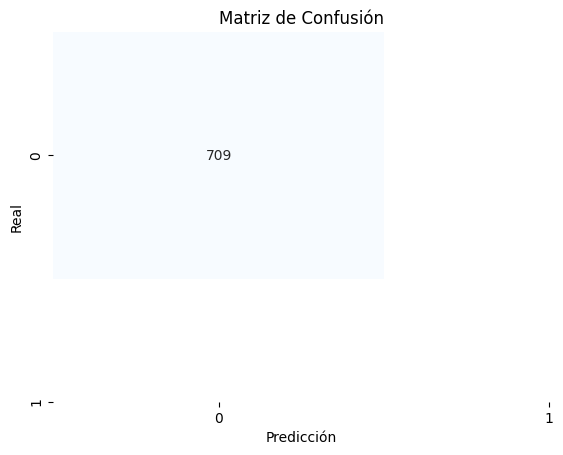

Vairbale:  Tallon aut
Presicion:  0.9225842694080434 Recall 0.9224151474517315 f1 0.9224151474517315
[322  31]


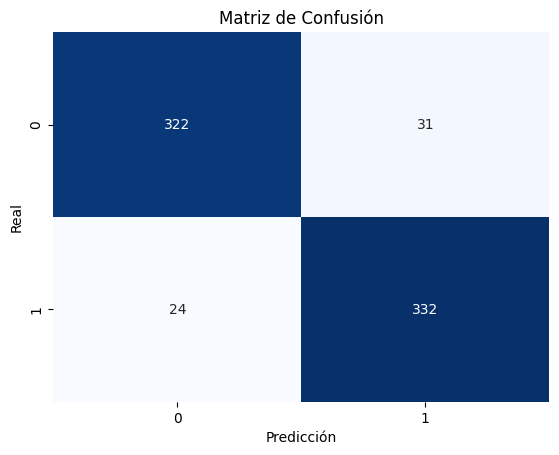

Vairbale:  Mancha aut
Presicion:  0.9301596291022467 Recall 0.9283545658186171 f1 0.9283545658186171
[462  12]


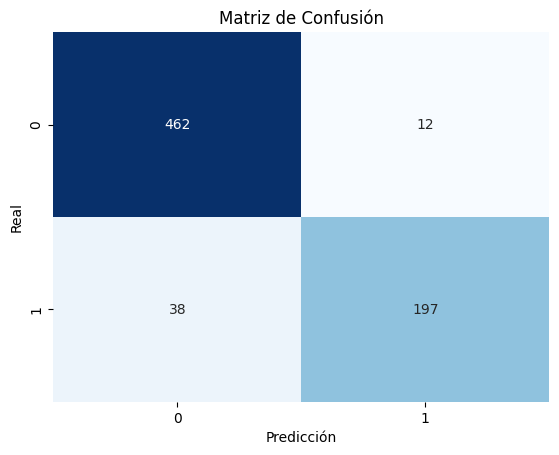

Vairbale:  Placa Fresca aut
Presicion:  0.9929976878405149 Recall 0.9910013859678569 f1 0.9910013859678569
[702   0]


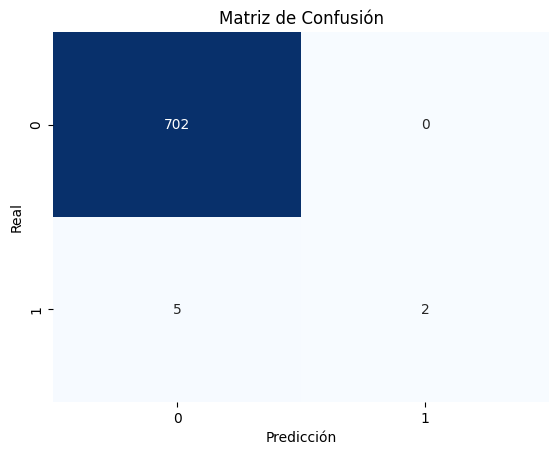

Vairbale:  Sin Pulir aut
Presicion:  1.0 Recall 1.0 f1 1.0
[709]


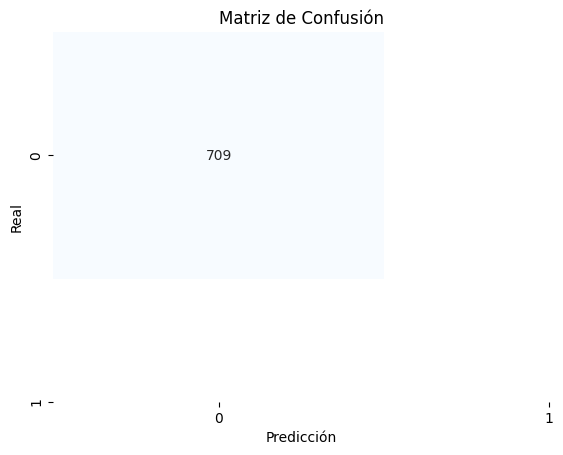

In [90]:
# Determinacion de matrices de confusion y métricas de los mejores modelos para las diferentes variables

split = BestModel(dfx_nt_nc_m1, dfy_nt_nc_m1)
split.split_data()
dict_choose_labels = {'column':[],'precision':[],
                      'recall':[],'FPR':[],'FNR':[],'f1':[],'TP':[],'TN':[],'FP':[],'FN':[]}

for file in os.listdir('best-nt-m1-without-variables'):
    if '.joblib' in file:
        print("Vairbale: ",' '.join(file.split("_")[:2]))
        try:

            idx = split.dfy.columns.get_loc(file.split("_")[0])
        
            y_test = split.y_test[:,idx]
            
            
            model = joblib.load('best-nt-m1-without-variables/'+file)
            y_pred = model.predict(split.X_test)
    
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            print("Presicion: ",precision,"Recall",f1,"f1",f1)
            
            cm = confusion_matrix(y_test, y_pred)
            print(cm[0,])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['0', '1'],
                        yticklabels=['0', '1'])
    
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.show()

            dict_choose_labels['column'].append(file.split("_")[0])
            dict_choose_labels['precision'].append(precision)
            dict_choose_labels['recall'].append(recall)
            dict_choose_labels['f1'].append(f1)

            try:
                fpr = cm[0,1]/(cm[0,1]+cm[0,0])
                fnr = cm[1,0]/(cm[1,1]+cm[1,0])
                dict_choose_labels['FPR'].append(fpr)
                dict_choose_labels['FNR'].append(fnr)
                dict_choose_labels['TP'].append(cm[1,1])
                dict_choose_labels['TN'].append(cm[0,0])
                dict_choose_labels['FP'].append(cm[0,1])
                dict_choose_labels['FN'].append(cm[1,0])

            except:
                dict_choose_labels['FPR'].append(1)
                dict_choose_labels['FNR'].append(1)
                dict_choose_labels['TP'].append(0)
                dict_choose_labels['TN'].append(0)
                dict_choose_labels['FP'].append(0)
                dict_choose_labels['FN'].append(0)
        
        except Exception as err:
            print("Fallo", err)

# Mejor modelo nt m2

In [44]:
dfx_nt_nc_m2 = pd.read_csv('nt-data/dfx_nt_nc_m2.csv')
dfy_nt_nc_m2 = pd.read_csv('nt-data/dfy_nt_nc_m2.csv')

In [31]:
dfx_aut_nc_m1.columns

Index(['PP_Hidro_Cemento_Kg', 'PP_Hidro_Carbonato_Kg', 'PP_Hidro_Silice_Kg',
       'PP_Hidro_Celulosa_Kg', 'PP_Hidro_Hidroxido_Kg',
       'PP_Hidro_Bentonita_Kg', 'PP_Hidro_SolReales_%', 'PP_Hidro_CelulosaS_%',
       'PP_Hidro_CelulosaSR_SR°', 'PP_Refi_EE_AMP', 'PP_Refi_CelulosaH_%',
       'PP_Refi_CelulosaS_%', 'PP_Refi_CelulosaSR_SR°',
       'PP_Maq_FlujoFloc_L/min', 'PP_Maq_Resi_ml', 'PP_Maq_Vueltas_N',
       'PP_Maq_Vel_m/min', 'PP_Maq_FormatoP_PSI',
       'PP_Maq_FlujoFlocForm_L/Placa', 'PP_Maq_VacíoCP_PulgadasHg',
       'PP_Maq_VacioSF_PulgadasHg', 'PP_Maq_Recir_%', 'PP_Maq_Fieltro_Dias',
       'PP_PF_Humedad_%', 'PP_PF_Espesor_mm', 'PP_PF_Dens_g/cm3',
       'PP_Maq_FlocCanalS_%', 'PP_Maq_FlocTkS_%', 'PP_Maq_FlocFormS_%',
       'PP_MaqTCE_Densidad_g/cm3', 'PP_Maq_TCES_%', 'PP_Maq_CilinS_%',
       'PP_Maq_CanalS_%', 'PP_Maq_Cono1S_%', 'PP_Maq_MolinoS_%',
       'PP_Maq_P1H_%', 'PP_Maq_P3H_%', 'Mp_CemPre_ARG_LOI_%',
       'Mp_CemCist_Bl_ARG_cm2/g', 'Mp_CemPre_ARG_Fi_mi

In [32]:
dfx_nt_nc_m2.columns

Index(['PP_Hidro_Cemento_Kg', 'PP_Hidro_Carbonato_Kg', 'PP_Hidro_Celulosa_Kg',
       'PP_Hidro_Pva_Kg', 'PP_Hidro_Bentonita_Kg', 'PP_Hidro_Agua_Kg',
       'PP_Hidro_SolReales_%', 'PP_Hidro_CelulosaS_%',
       'PP_Hidro_CelulosaSR_SR°', 'PP_Maq_Resi_ml', 'PP_Refi_EE_AMP',
       'PP_Refi_CelulosaH_%', 'PP_Refi_CelulosaS_%', 'PP_Refi_CelulosaSR_SR°',
       'PP_Maq_FlujoFloc_L/min', 'PP_Maq_Vueltas_N', 'PP_Maq_Vel_m/min',
       'PP_Maq_FormatoP_PSI', 'PP_Maq_FlujoFlocForm_L/Placa',
       'PP_Maq_VacíoCP_PulgadasHg', 'PP_Maq_VacioSF_PulgadasHg',
       'PP_Maq_Recir_%', 'PP_Maq_Fieltro_Dias', 'PP_PF_Humedad_%',
       'PP_PF_Espesor_mm', 'PP_PF_Dens_g/cm3', 'PP_Maq_FlocCanalS_%',
       'PP_Maq_FlocTkS_%', 'PP_Maq_FlocFormS_%', 'PP_MaqTCE_Densidad_g/cm3',
       'PP_Maq_TCES_%', 'PP_Maq_CilinS_%', 'PP_Maq_CanalS_%',
       'PP_Maq_Cono1S_%', 'PP_Maq_MolinoS_%', 'PP_Maq_P1H_%', 'PP_Maq_P3H_%',
       'Mp_CemPre_ARG_LOI_%', 'Mp_CemCist_Bl_ARG_cm2/g',
       'Mp_CemPre_ARG_Fi_min', 'Mp_

## Elección del mejor modelo según la caracteristica de interes

In [17]:
classifier = GeneralClassifier(dfx_nt_nc_m2, dfy_nt_nc_m2)

for caract in dfy_aut_nc_m1.columns:
    classifier.train(feature=caract)
    idx = classifier.predictions['Balanced Accuracy'].idxmax()
    
    print("\nMejor modelo de: ", caract,"\n")
    print("Modelo: ",idx)
    print(classifier.predictions[['Accuracy','Balanced Accuracy','ROC AUC','F1 Score']].loc[idx],"\n")

NameError: name 'dfy_aut_nc_m1' is not defined

## Tuneo del mejor modelo para cada variable

In [ ]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para las caracteristicas dadas

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


for col in dfy_nt_nc_m2.columns:
    b_model = BestModel(dfx_nt_nc_m2, dfy_nt_nc_m2)
    b_model.grid_search_cv(col, extra_trees, param_grid, f'best{col}_nt_m2_best_extra_tree_classifier.joblib')

[1 1 1 ... 1 0 1]


## Calculo de las matrices de confusion para los mejores modelos

In [49]:
split = BestModel(dfx_nt_nc_m2, dfy_nt_nc_m2)

dict_choose_labels = {'column':[],'precision':[],
                      'recall':[],'FPR':[],'FNR':[],'f1':[],'TP':[],'TN':[],'FP':[],'FN':[]}

for file in os.listdir('best-nt-m2'):
    if '.joblib' in file and ('nt' in file) and ('m2' in file):
        print("Vairbale: ",file.split("_")[0].split('best')[-1])
        try:
            split.split_data(file.split("_")[0].split("best")[-1])
            
            model = joblib.load('best-nt-m2/'+file)
            y_pred = model.predict(split.X_test[:1,:])

            print(split.X_test)
            print(split.X_test.shape)
            print(y_pred[:])
    
            precision = precision_score(split.y_test, y_pred, average='weighted')
            recall = recall_score(split.y_test, y_pred, average='weighted')
            f1 = f1_score(split.y_test, y_pred, average='weighted')
            
            print("Presicion: ",precision,"Recall",f1,"f1",f1)
            
            cm = confusion_matrix(split.y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['0', '1'],
                        yticklabels=['0', '1'])
    
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.show()

            dict_choose_labels['column'].append(file.split("_")[0])
            dict_choose_labels['precision'].append(precision)
            dict_choose_labels['recall'].append(recall)
            dict_choose_labels['f1'].append(f1)
            
            try:
                fpr = cm[0,1]/(cm[0,1]+cm[0,0])
                fnr = cm[1,0]/(cm[1,1]+cm[1,0])
                dict_choose_labels['FPR'].append(fpr)
                dict_choose_labels['FNR'].append(fnr)
                dict_choose_labels['TP'].append(cm[1,1])
                dict_choose_labels['TN'].append(cm[0,0])
                dict_choose_labels['FP'].append(cm[0,1])
                dict_choose_labels['FN'].append(cm[1,0])

            except:
                dict_choose_labels['FPR'].append(1)
                dict_choose_labels['FNR'].append(1)
                dict_choose_labels['TP'].append(0)
                dict_choose_labels['TN'].append(0)
                dict_choose_labels['FP'].append(0)
                dict_choose_labels['FN'].append(0)
        
        except Exception as err:
            print("Fallo", err)


Vairbale:  Ondulación
[[0.0625     0.66666667 0.00900901 ... 0.1        0.85688548 0.95865564]
 [0.6875     0.         0.75675676 ... 0.5        0.06395851 0.80608162]
 [0.0625     0.66666667 0.         ... 0.3        0.         0.90664177]
 ...
 [0.0625     0.66666667 0.00900901 ... 0.3        0.81248877 0.86823153]
 [0.6875     0.         0.75675676 ... 0.4        0.50302506 0.87063217]
 [0.6875     0.         0.75675676 ... 0.4        0.50302506 0.98692985]]
(2522, 47)
[0]
Fallo Found input variables with inconsistent numbers of samples: [2522, 1]
Vairbale:  Espesor
[[0.0625     0.66666667 0.00900901 ... 0.1        0.85688548 0.95865564]
 [0.6875     0.         0.75675676 ... 0.5        0.06395851 0.80608162]
 [0.0625     0.66666667 0.         ... 0.3        0.         0.90664177]
 ...
 [0.0625     0.66666667 0.00900901 ... 0.3        0.81248877 0.86823153]
 [0.6875     0.         0.75675676 ... 0.4        0.50302506 0.87063217]
 [0.6875     0.         0.75675676 ... 0.4        0.50

In [66]:
df_choose_labels_nt_m2 = pd.DataFrame(dict_choose_labels)
df_choose_labels_nt_m2

column  precision  recall  FPR  FNR   f1    TP    TN  FP   FN
0               Espesor       0.97    0.97 0.00 0.17 0.97   346  2103   1   72
1            Daño Molde       1.00    1.00 0.00 0.30 1.00     7  2512   0    3
2                 Golpe       1.00    1.00 0.00 0.71 1.00     2  2515   0    5
3           Dimensiones       1.00    1.00 0.00 0.29 1.00    20  2494   0    8
4                Arruga       0.99    0.99 0.00 0.23 0.99    44  2465   0   13
5                 Otros       1.00    1.00 0.00 0.19 1.00    17  2500   1    4
6             Desmoldeo       0.97    0.97 0.02 0.04 0.97  1067  1376  29   50
7                 Crudo       1.00    1.00 1.00 1.00 1.00     0     0   0    0
8          Manipulación       0.97    0.97 0.10 0.00 0.97  1899   555  59    9
9              Despunte       0.96    0.96 0.06 0.02 0.96  1558   870  58   36
10               Fisura       0.97    0.97 0.00 0.23 0.97   241  2208   0   73
11           Descolgada       0.98    0.98 0.01 0.09 0.98   517  1945  11   49
12  Esquinas Levantadas       1.00    1.00 1.00 1.00 1.00     0     0   0    0
13       Incrustaciones       1.00    1.00 1.00 1.00 1.00     0     0   0    0
14    Sello Litografico       1.00    1.00 1.00 1.00 1.00     0     0   0    0
15        Mal Perforado       1.00    1.00 1.00 1.00 1.00     0     0   0    0
16             Desborde       0.96    0.96 0.04 0.04 0.96  1219  1200  46   57
17               Carpas       1.00    1.00 1.00 1.00 1.00     0     0   0    0
18              Maquina       1.00    1.00 0.33 0.00 1.00  2513     6   3    0
19           Ondulación       1.00    1.00 0.00 0.00 1.00     7  2515   0    0
20                 Roto       0.98    0.98 0.00 0.10 0.98   491  1972   6   53
21              Caponeo       0.97    0.97 0.00 0.17 0.97   335  2116   4   67
22             Flexible       0.98    0.98 0.01 0.10 0.98   327  2145  12   38
23         Placa Fresca       1.00    1.00 0.00 1.00 1.00     0  2518   0    4
24               Pegada       0.98    0.98 0.00 0.13 0.98   311  2166   0   45
25               Tallon       0.69    0.63 0.04 0.79 0.56   228  1353  62  879
26               Rajada       0.97    0.97 0.06 0.01 0.97  1529   910  61   22
27          Mal Pintada       1.00    1.00 1.00 1.00 1.00     0     0   0    0
28              Quemado       1.00    1.00 1.00 1.00 1.00     0     0   0    0
29            Sin Pulir       1.00    1.00 1.00 1.00 1.00     0     0   0    0
30          Sin Textura       1.00    1.00 1.00 1.00 1.00     0     0   0    0
31           Delaminada       0.97    0.97 0.02 0.04 0.97  1211  1234  30   47
32         Mal Ondulada       0.97    0.97 0.01 0.07 0.97   845  1595  21   61
33            Separador       1.00    1.00 1.00 1.00 1.00     0     0   0    0
34            Daño Tren       1.00    1.00 0.00 0.20 1.00     8  2512   0    2
35              Machete       1.00    1.00 0.00 0.50 1.00     3  2516   0    3
36    Perdida De Grados       1.00    1.00 0.00 0.75 1.00     1  2518   0    3
37          Trasparente       1.00    1.00 1.00 1.00 1.00     0     0   0    0
38             Quebrada       1.00    1.00 1.00 1.00 1.00     0     0   0    0
39         Mal Asentada       1.00    1.00 1.00 1.00 1.00     0     0   0    0
40             Material       0.97    0.97 0.13 0.00 0.97  1884   553  80    5
41        Desmoldeadora       0.97    0.97 0.01 0.07 0.97   612  1843  20   47
42               Basura       0.97    0.97 0.15 0.00 0.97  2033   411  72    6
43               Pandeo       1.00    1.00 1.00 1.00 1.00     0     0   0    0
44          Daño Estiba       0.99    0.99 0.00 0.30 0.99    62  2433   1   26
45                 Nudo       0.97    0.97 0.08 0.01 0.96  1693   741  68   20
46               Mancha       0.97    0.97 0.07 0.01 0.97  1574   865  63   20
47            Mal Corte       0.97    0.97 0.02 0.05 0.97  1002  1437  26   57
48           Desplazada       0.97    0.97 0.18 0.00 0.97  2192   266  57    7
49              Burbuja       0.99    0.99 0.00 0.19 0.99    69  24

In [67]:
df_choose_labels_nt_m2_filter = df_choose_labels_nt_m2.loc[(df_choose_labels_nt_m2['TP']>100) | (df_choose_labels_nt_m2['FNR']<0.03) & (df_choose_labels_nt_m2['TP']>10)]
df_choose_labels_nt_m2_filter.reset_index()

index            column  precision  recall  FPR  FNR   f1    TP    TN  FP  \
0       0           Espesor       0.97    0.97 0.00 0.17 0.97   346  2103   1   
1       6         Desmoldeo       0.97    0.97 0.02 0.04 0.97  1067  1376  29   
2       8      Manipulación       0.97    0.97 0.10 0.00 0.97  1899   555  59   
3       9          Despunte       0.96    0.96 0.06 0.02 0.96  1558   870  58   
4      10            Fisura       0.97    0.97 0.00 0.23 0.97   241  2208   0   
5      11        Descolgada       0.98    0.98 0.01 0.09 0.98   517  1945  11   
6      16          Desborde       0.96    0.96 0.04 0.04 0.96  1219  1200  46   
7      18           Maquina       1.00    1.00 0.33 0.00 1.00  2513     6   3   
8      20              Roto       0.98    0.98 0.00 0.10 0.98   491  1972   6   
9      21           Caponeo       0.97    0.97 0.00 0.17 0.97   335  2116   4   
10     22          Flexible       0.98    0.98 0.01 0.10 0.98   327  2145  12   
11     24            Pegada       0.98    0.98 0.00 0.13 0.98   311  2166   0   
12     25            Tallon       0.69    0.63 0.04 0.79 0.56   228  1353  62   
13     26            Rajada       0.97    0.97 0.06 0.01 0.97  1529   910  61   
14     31        Delaminada       0.97    0.97 0.02 0.04 0.97  1211  1234  30   
15     32      Mal Ondulada       0.97    0.97 0.01 0.07 0.97   845  1595  21   
16     40          Material       0.97    0.97 0.13 0.00 0.97  1884   553  80   
17     41     Desmoldeadora       0.97    0.97 0.01 0.07 0.97   612  1843  20   
18     42            Basura       0.97    0.97 0.15 0.00 0.97  2033   411  72   
19     45              Nudo       0.97    0.97 0.08 0.01 0.96  1693   741  68   
20     46            Mancha       0.97    0.97 0.07 0.01 0.97  1574   865  63   
21     47         Mal Corte       0.97    0.97 0.02 0.05 0.97  1002  1437  26   
22     48        Desplazada       0.97    0.97 0.18 0.00 0.97  2192   266  57   
23     50  Piel De Elefante       0.98    0.98 0.00 0.22 0.98   184  2283   3   
24     52            Tallon       0.97    0.97 0.03 0.03 0.97  1073  1378  37   

     FN  
0    72  
1    50  
2     9  
3    36  
4    73  
5    49  
6    57  
7     0  
8    53  
9    67  
10   38  
11   45  
12  879  
13   22  
14   47  
15   61  
16    5  
17   47  
18    6  
19   20  
20   20  
21   57  
22    7  
23   52  
24   34

In [68]:
with pd.ExcelWriter('possible-model-aut-nt.xlsx') as writer:
    # Guarda cada DataFrame en una hoja separada
    df_choose_labels_aut_filter.to_excel(writer, sheet_name='aut_m1', index=False)
    df_choose_labels_nt_m1_filter.to_excel(writer, sheet_name='nt_m1', index=False)
    df_choose_labels_nt_m2_filter.to_excel(writer, sheet_name='nt_m2', index=False)

# Mejor modelo nt m2 sin algunos predictores

In [98]:
dfx_nt_nc_m2 = pd.read_csv('nt-data-without-variables/dfx_nt_nc_m2.csv')
dfy_nt_nc_m2 = pd.read_csv('nt-data-without-variables/dfy_nt_nc_m2.csv')

In [100]:
dfy_nt_nc_m2.head()

Manipulación  Maquina  Material  Daño Molde  Basura  Nudo  Espesor  \
0             1        1         1           0       1     1        0   
1             1        1         1           0       1     1        0   
2             1        1         1           0       1     1        0   
3             1        1         1           0       1     1        0   
4             1        1         1           0       1     1        0   

   Ondulación  Fisura  Despunte  ...  Mal Asentada  Exceso_Pecas  \
0           0       0         1  ...             0             0   
1           0       0         1  ...             0             0   
2           0       0         1  ...             0             0   
3           0       0         1  ...             0             0   
4           0       0         1  ...             0             0   

   Ensayos_Calidad  Mal Perforado  Crudo  Incrustaciones  Trasparente  \
0                0              0      0               0            0   
1                0              0      0               0            0   
2                0              0      0               0            0   
3                0              0      0               0            0   
4                0              0      0               0            0   

   Quemado  Mal Pintada  Cuarteamineto_Pintura  
0        0            0                      0  
1        0            0                      0  
2        0            0                      0  
3        0            0                      0  
4        0            0                      0  

[5 rows x 57 columns]

In [55]:
for columns in dfx_nt_nc_m2.columns:
    if "Tipo" in columns:
        print(columns)

Tipo_Producto


Mejores hiperparámetros: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.941813664588413 Recall 0.937248044635955 f1 0.937248044635955


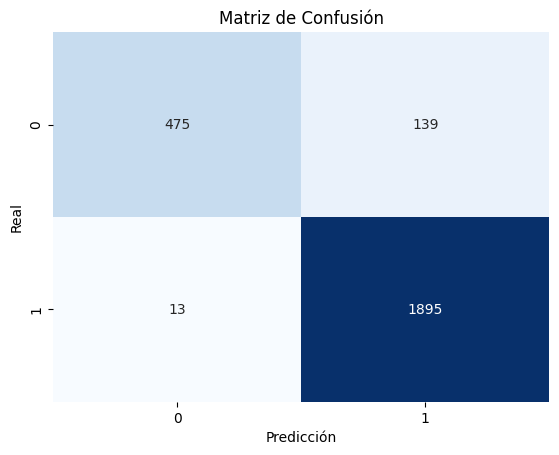

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Presicion:  0.9980213832334236 Recall 0.997637171345745 f1 0.997637171345745


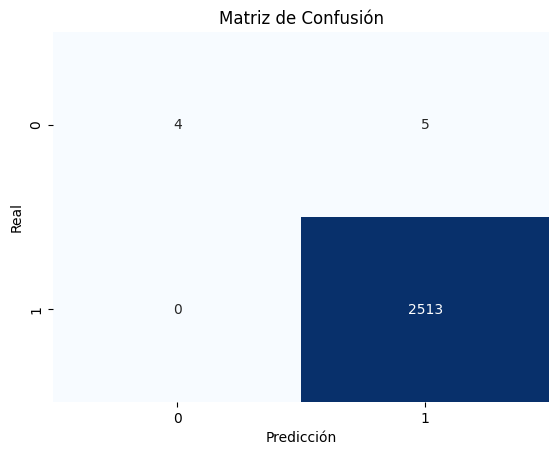

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Presicion:  0.9315123384705242 Recall 0.9235775918844811 f1 0.9235775918844811


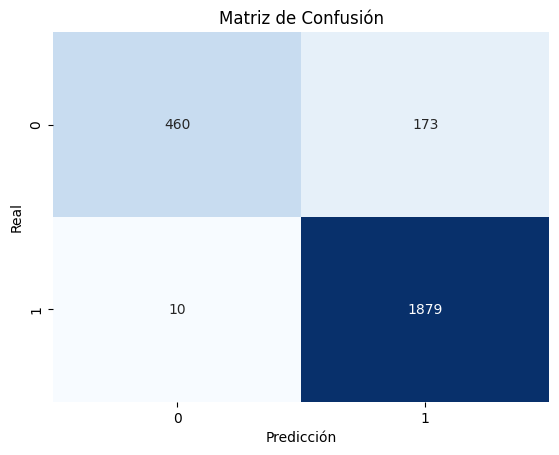

In [ ]:
#Entrenamiento de ExtraTreeClassifier como mejor modelo para las caracteristicas dadas

extra_trees = ExtraTreesClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

b_model = BestModel(dfx_nt_nc_m2, dfy_nt_nc_m2)
b_model.split_data()
joblib.dump(b_model.scaler, 'scaler-nt-m2-without-variables/scaler.joblib')

for col in dfy_nt_nc_m1.columns:
    b_model.grid_search_cv(col, extra_trees, param_grid, f'best-nt-m2-without-variables/{col}_nt_m2_best_extra_tree_classifier')

Vairbale:  Roto nt
Presicion:  0.9417471942808716 Recall 0.9343901722574331 f1 0.9343901722574331
[1974    4]


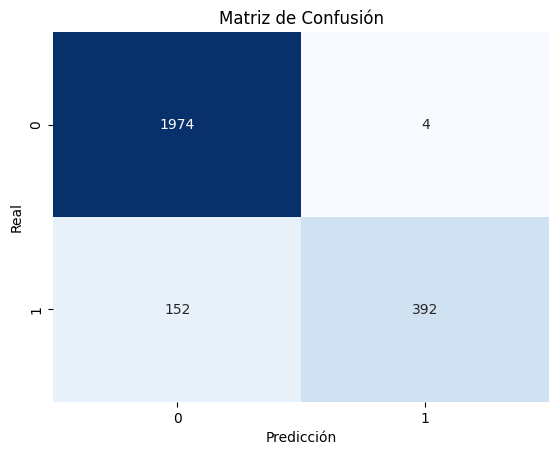

Vairbale:  Flexible nt
Presicion:  0.9541592932759624 Recall 0.9504893275593291 f1 0.9504893275593291
[2148    9]


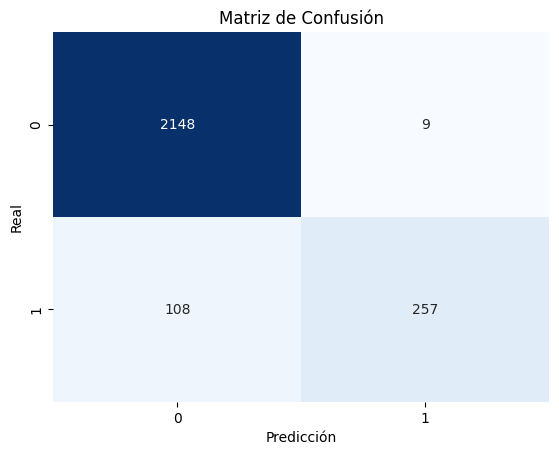

Vairbale:  Desmoldeo nt
Presicion:  0.9460459881248703 Recall 0.9446518807105475 f1 0.9446518807105475
[1372   33]


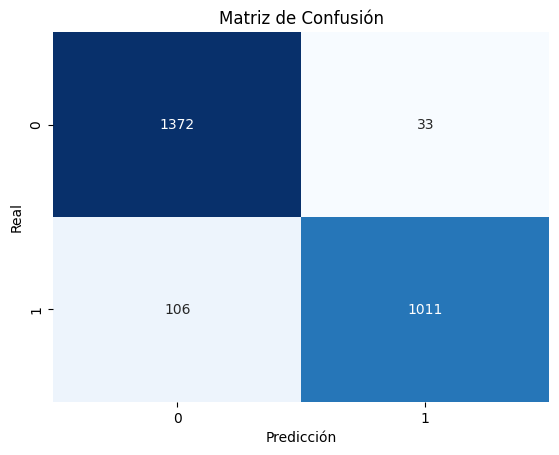

Vairbale:  Cuarteamineto Pintura
Fallo 'Cuarteamineto'
Vairbale:  Mal Perforado nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


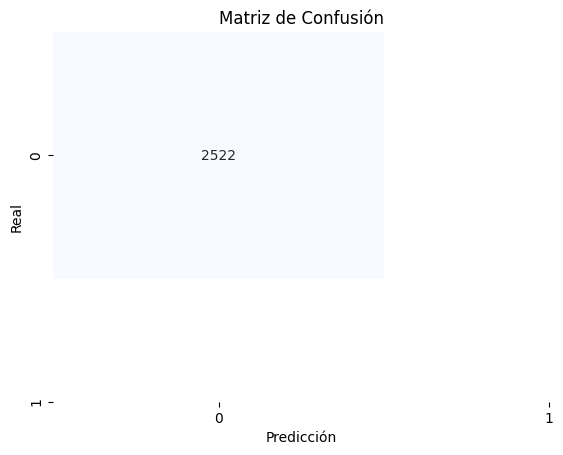

Vairbale:  Daño Molde nt
Presicion:  0.9968379844668505 Recall 0.995773074002304 f1 0.995773074002304
[2512    0]


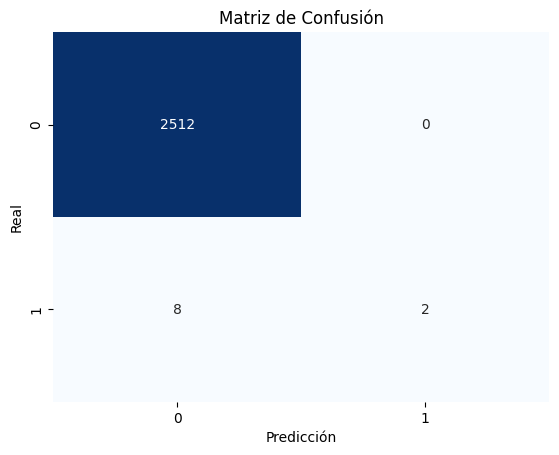

Vairbale:  Crudo nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


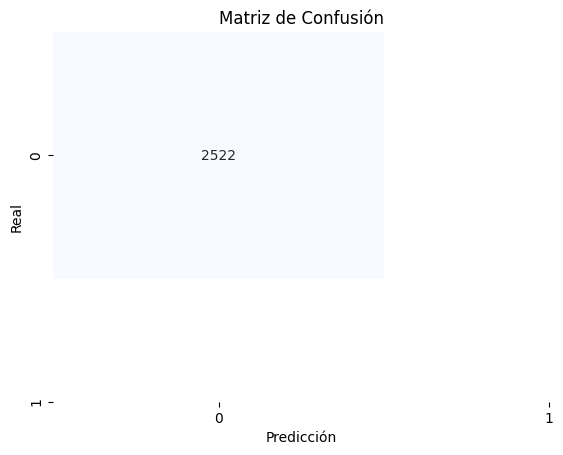

Vairbale:  Mancha nt
Presicion:  0.9329558468929496 Recall 0.9285377480716299 f1 0.9285377480716299
[774 154]


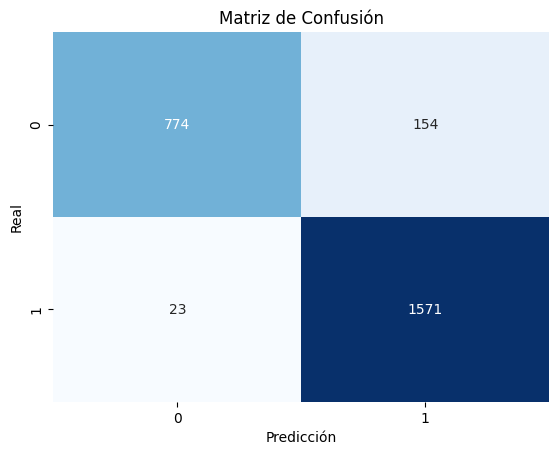

Vairbale:  Sello Litografico nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


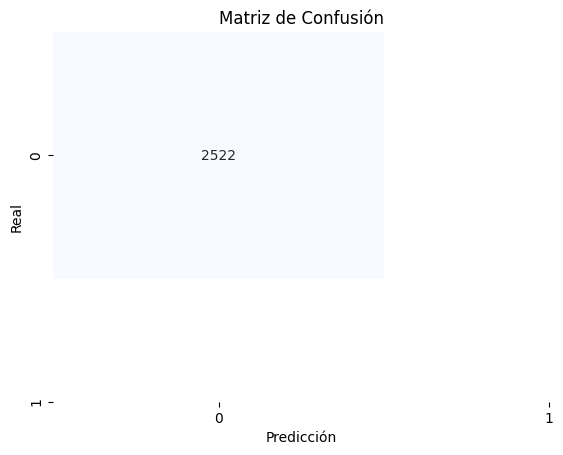

Vairbale:  Basura nt
Presicion:  0.9400150910988441 Recall 0.934147098129057 f1 0.934147098129057
[338 145]


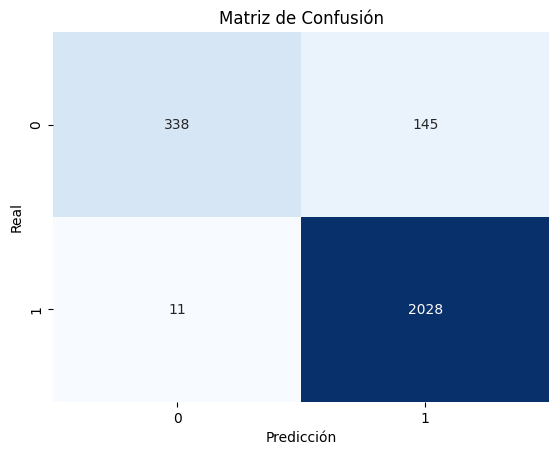

Vairbale:  Esquinas Levantadas nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


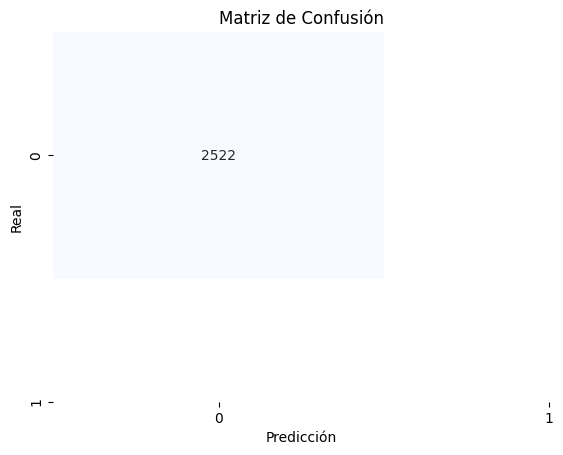

Vairbale:  Caponeo nt
Presicion:  0.9430255928468536 Recall 0.9352038093822064 f1 0.9352038093822064
[2115    5]


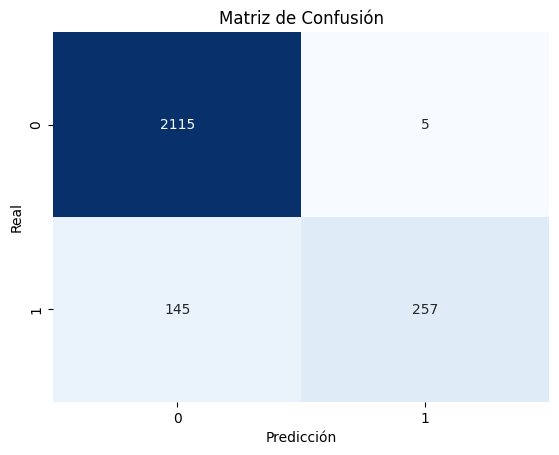

Vairbale:  Mal Asentada nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


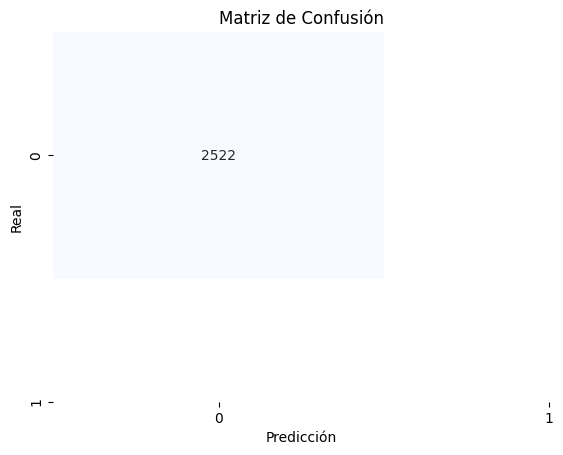

Vairbale:  Piel De Elefante nt
Presicion:  0.9610805618334722 Recall 0.955818169834016 f1 0.955818169834016
[2283    3]


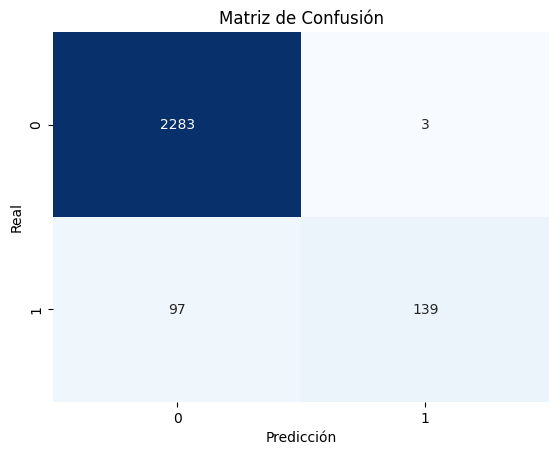

Vairbale:  Sin Textura nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


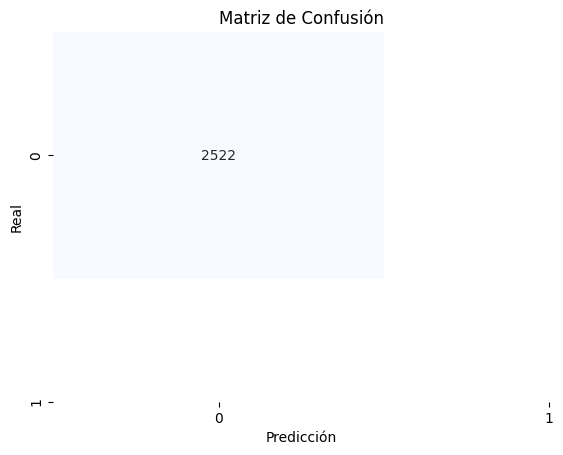

Vairbale:  Desmoldeadora nt
Presicion:  0.9480356878836697 Recall 0.9470945338204094 f1 0.9470945338204094
[1832   31]


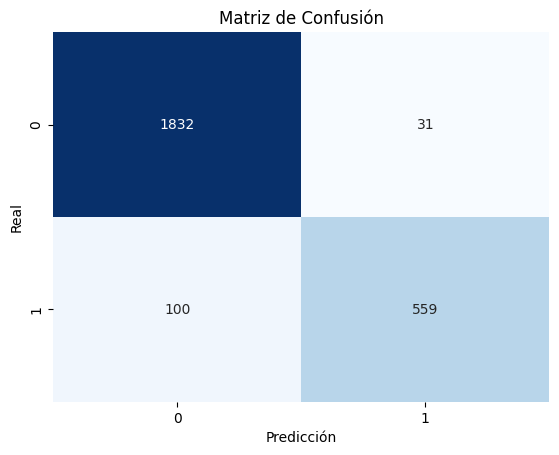

Vairbale:  Sin Texturizar
Fallo 'Sin'
Vairbale:  Pandeo nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


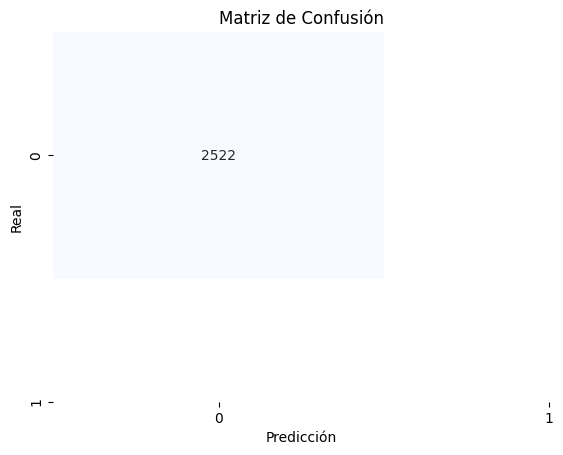

Vairbale:  Tallon nt
Presicion:  0.935115798142118 Recall 0.9350149047853347 f1 0.9350149047853347
[1326   89]


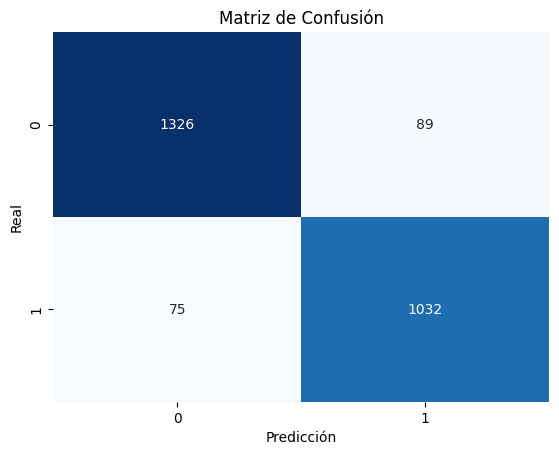

Vairbale:  Arruga nt
Presicion:  0.9863164155432196 Recall 0.9830968275130261 f1 0.9830968275130261
[2465    0]


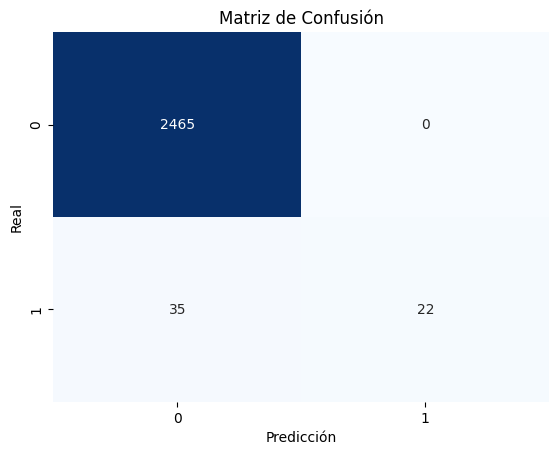

Vairbale:  Ensayos Calidad
Fallo 'Ensayos'
Vairbale:  Rajada nt
Presicion:  0.9393915947297472 Recall 0.9370551843041084 f1 0.9370551843041084
[844 127]


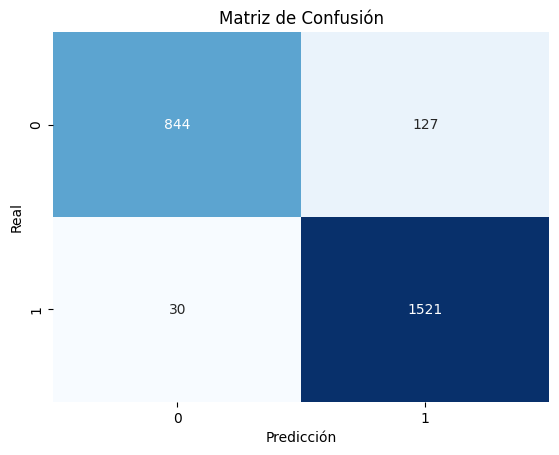

Vairbale:  Tallon Montacargas
Presicion:  0.6805627324167288 Recall 0.5382411240209062 f1 0.5382411240209062
[1363   52]


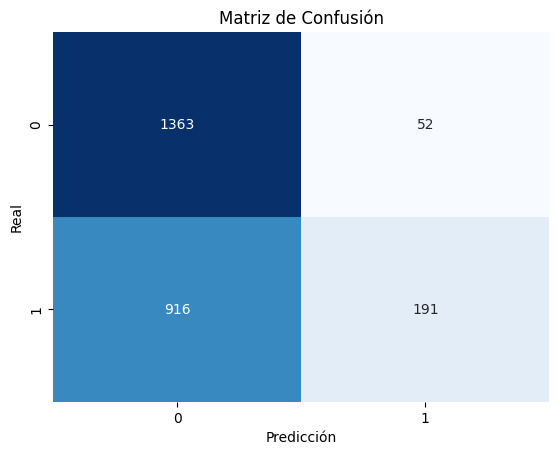

Vairbale:  Quemado nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


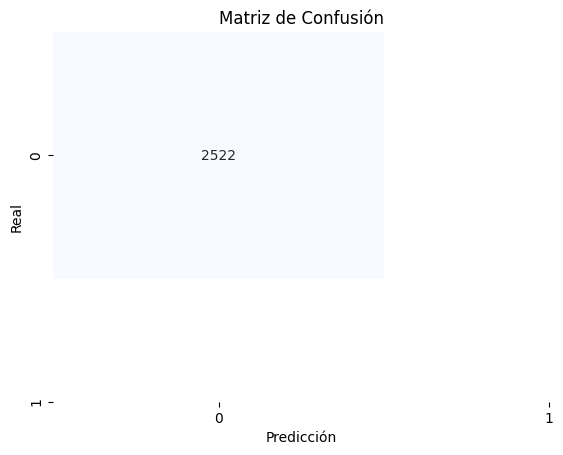

Vairbale:  Maquina nt
Presicion:  0.9980213832334236 Recall 0.997637171345745 f1 0.997637171345745
[4 5]


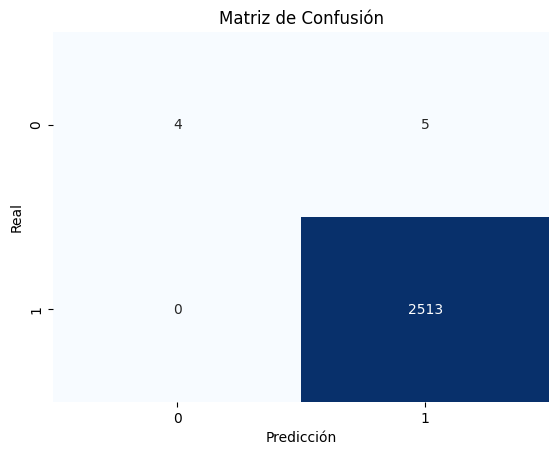

Vairbale:  Perdida De Grados nt
Presicion:  0.9968304298855245 Recall 0.9976215651473384 f1 0.9976215651473384
[2518    0]


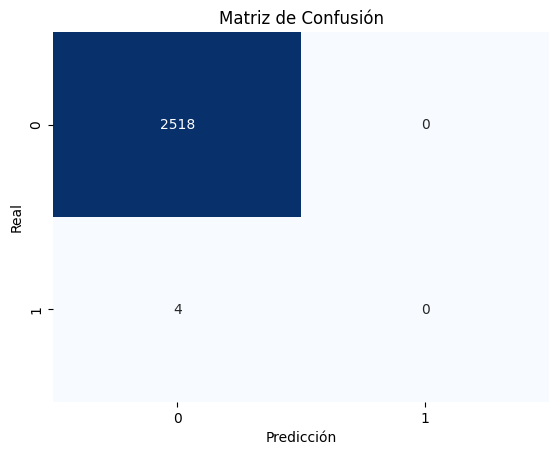

Vairbale:  Desplazada nt
Presicion:  0.9380278072082832 Recall 0.9269559306672709 f1 0.9269559306672709
[166 157]


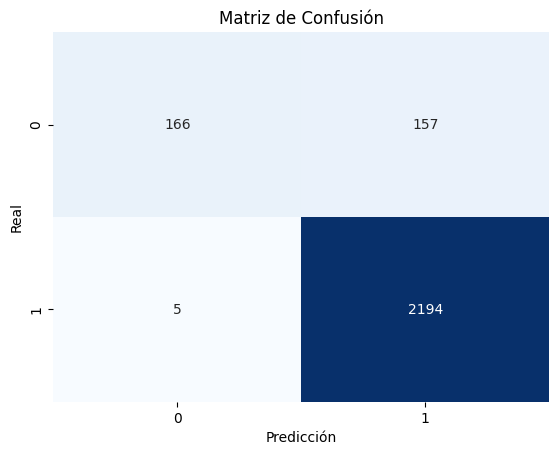

Vairbale:  Mal Corte nt
Presicion:  0.9292646192380293 Recall 0.926846914516834 f1 0.926846914516834
[1421   42]


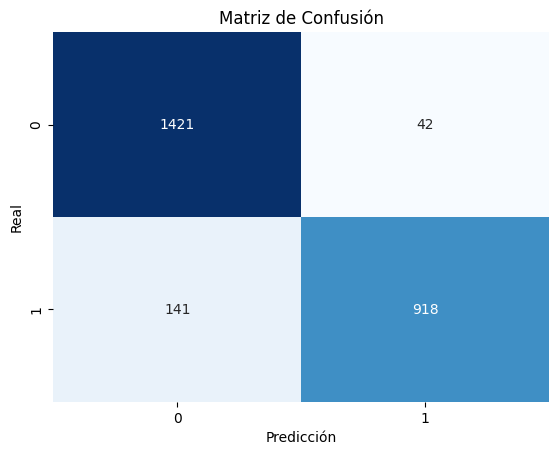

Vairbale:  Quebrada nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


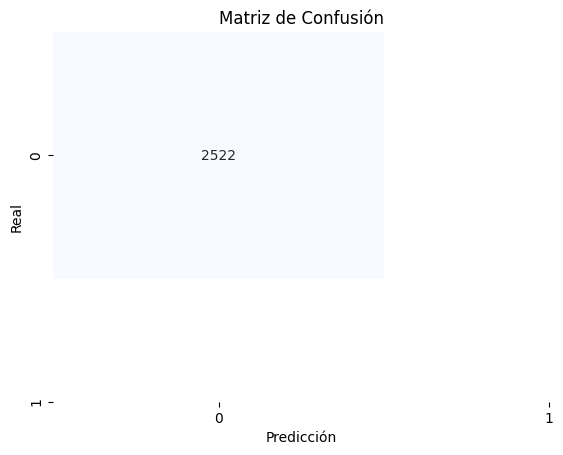

Vairbale:  Despunte nt
Presicion:  0.9316876223060292 Recall 0.930825127782293 f1 0.930825127782293
[808 120]


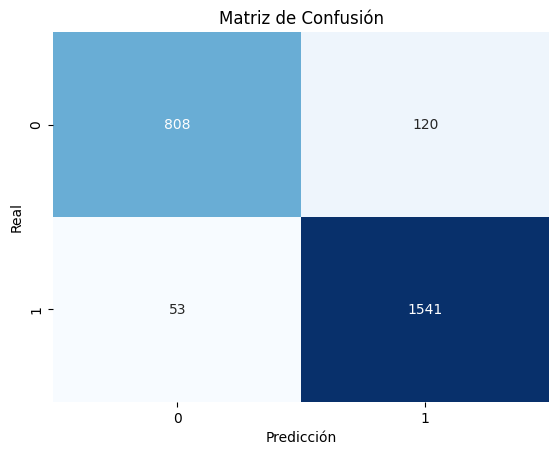

Vairbale:  Carpas nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


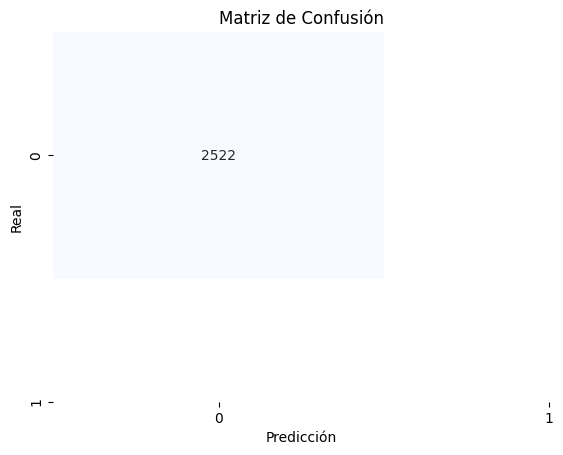

Vairbale:  Exceso Pecas
Fallo 'Exceso'
Vairbale:  Trasparente nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


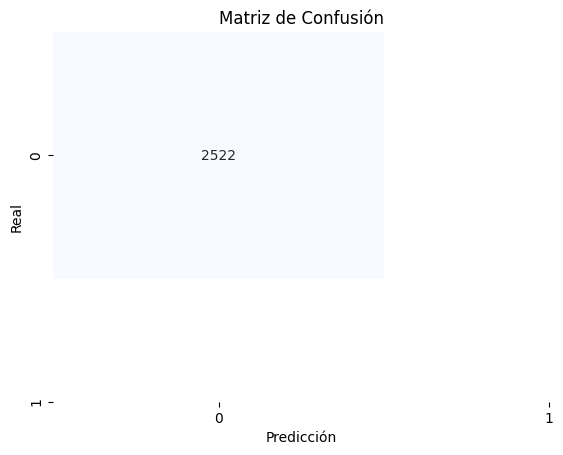

Vairbale:  Otros nt
Presicion:  0.9960506838901694 Recall 0.9954193005778994 f1 0.9954193005778994
[2501    0]


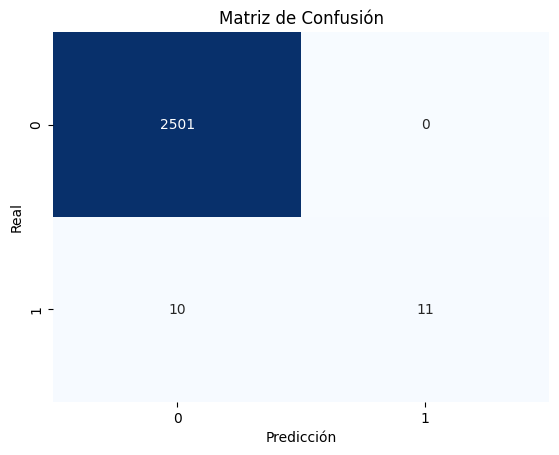

Vairbale:  Dimensiones nt
Presicion:  0.9940878973680476 Recall 0.992973268861646 f1 0.992973268861646
[2494    0]


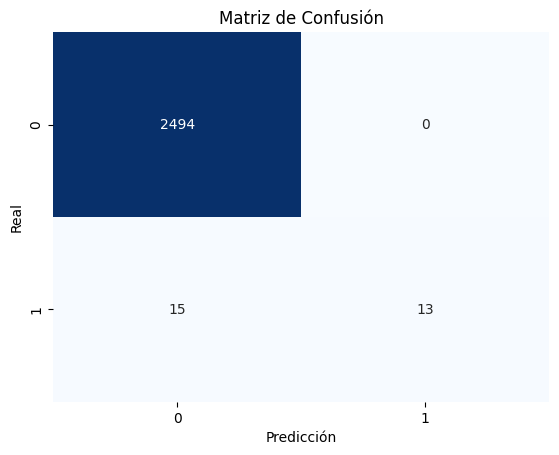

Vairbale:  Golpe nt
Presicion:  0.9976265979570182 Recall 0.9967302039116931 f1 0.9967302039116931
[2515    0]


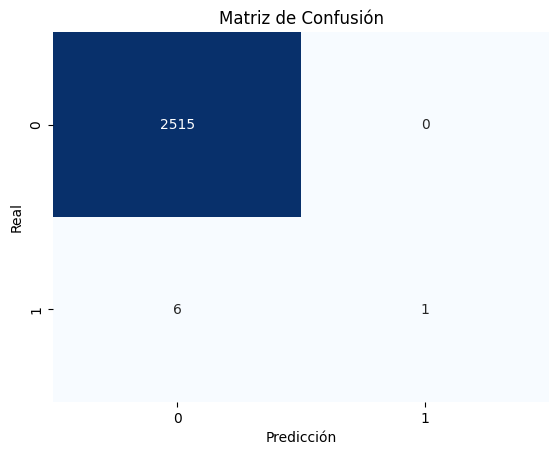

Vairbale:  Placa Fresca nt
Presicion:  0.9968304298855245 Recall 0.9976215651473384 f1 0.9976215651473384
[2518    0]


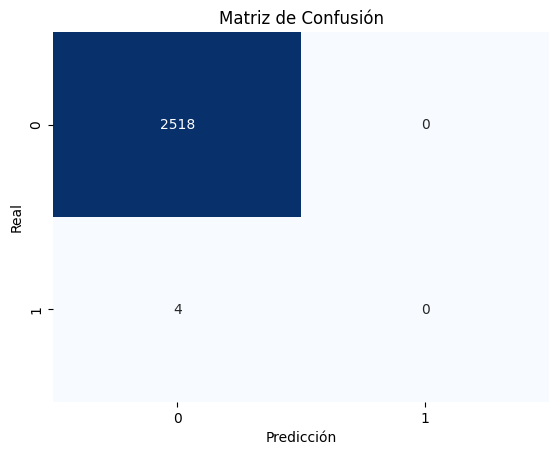

Vairbale:  Incrustaciones nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


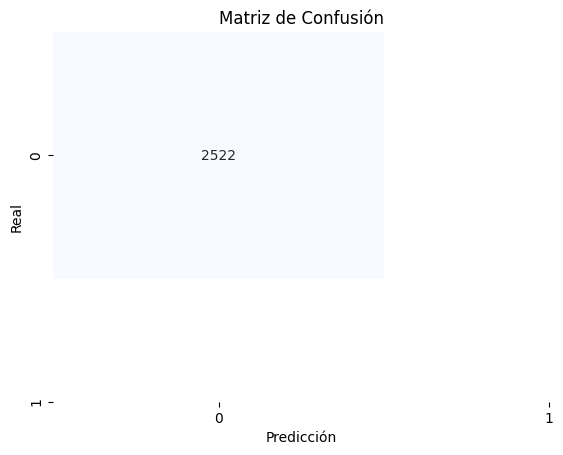

Vairbale:  Descolgada nt
Presicion:  0.9390179837820679 Recall 0.9349564002104022 f1 0.9349564002104022
[1938   18]


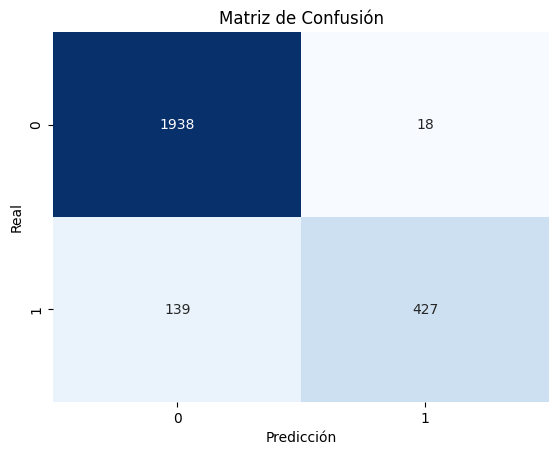

Vairbale:  Mal Pintada nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


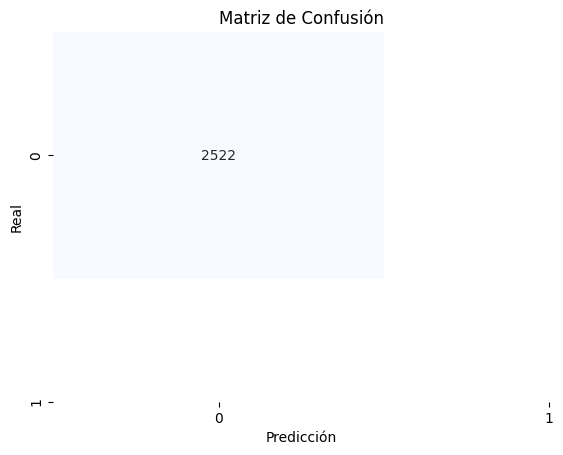

Vairbale:  Daño Estiba nt
Presicion:  0.9805735294305442 Recall 0.9763416072325487 f1 0.9763416072325487
[2434    0]


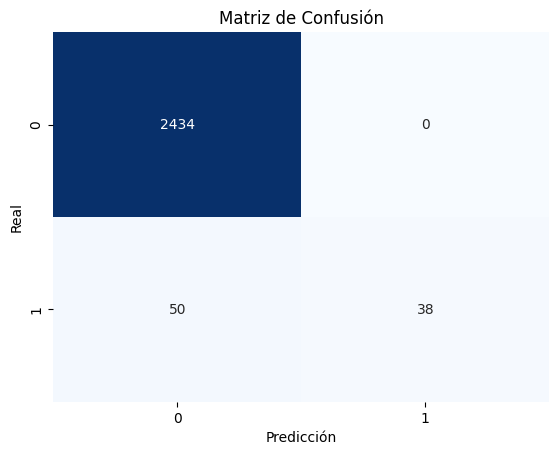

Vairbale:  Ondulación nt
Presicion:  0.9992076087206521 Recall 0.9991410510664606 f1 0.9991410510664606
[2515    0]


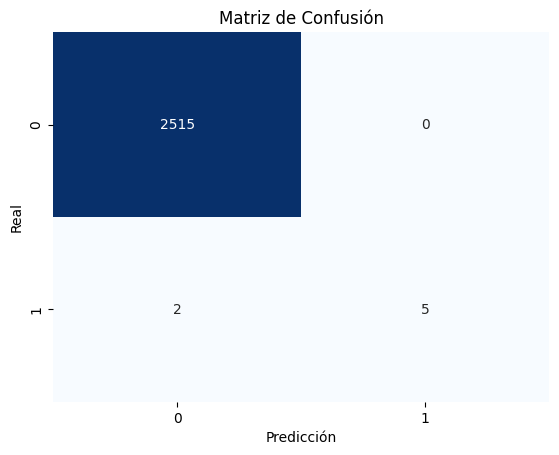

Vairbale:  Separador nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


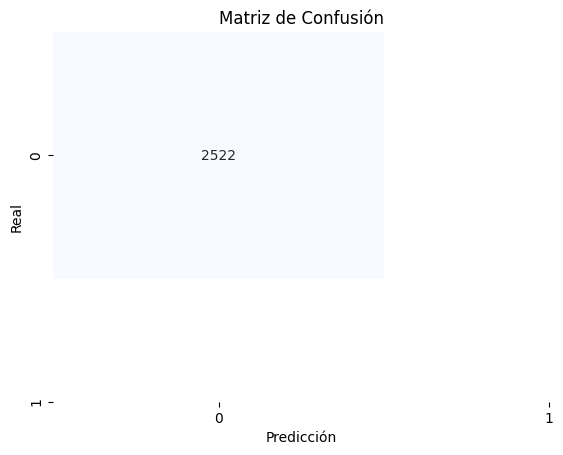

Vairbale:  Burbuja nt
Presicion:  0.9828629383473 Recall 0.9795853641143195 f1 0.9795853641143195
[2437    0]


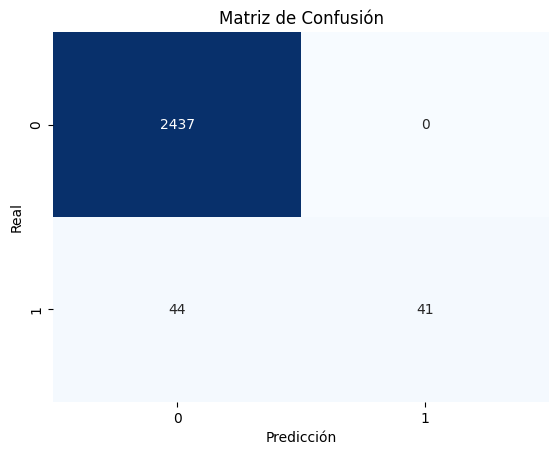

Vairbale:  Mal Ondulada nt
Presicion:  0.92548794489093 Recall 0.9216457399476015 f1 0.9216457399476015
[1582   34]


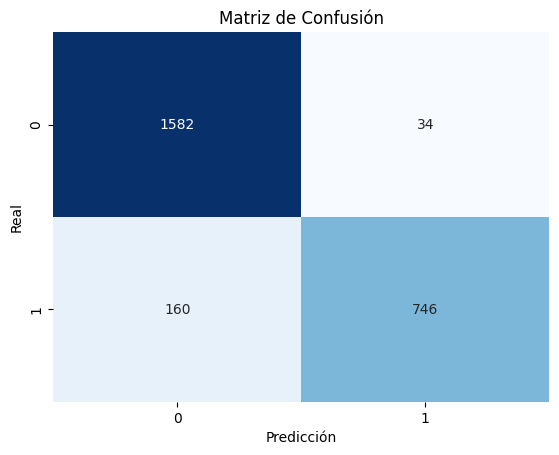

Vairbale:  Material nt
Presicion:  0.9315123384705242 Recall 0.9235775918844811 f1 0.9235775918844811
[460 173]


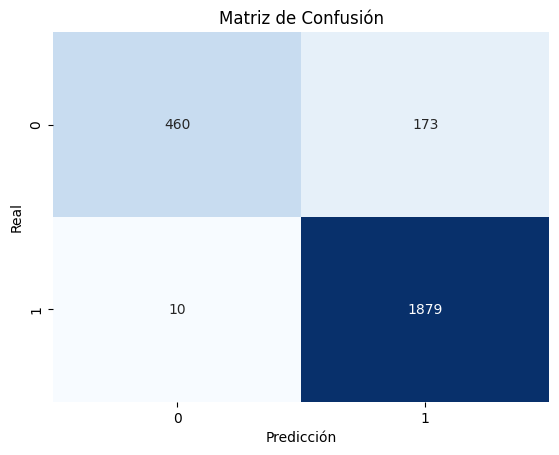

Vairbale:  Pegada nt
Presicion:  0.9610133338738974 Recall 0.9561799656982635 f1 0.9561799656982635
[2166    0]


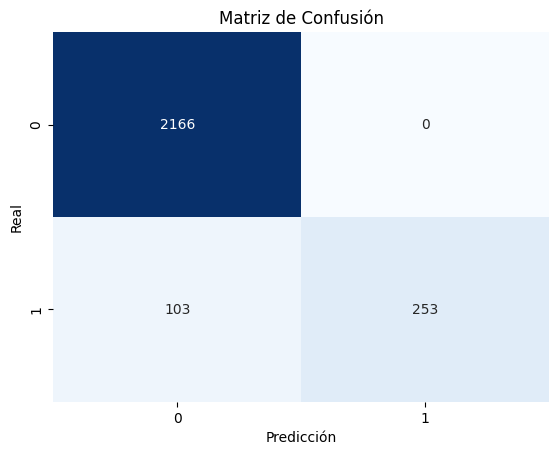

Vairbale:  Desborde nt
Presicion:  0.9107899414165015 Recall 0.9107862274688461 f1 0.9107862274688461
[1135  111]


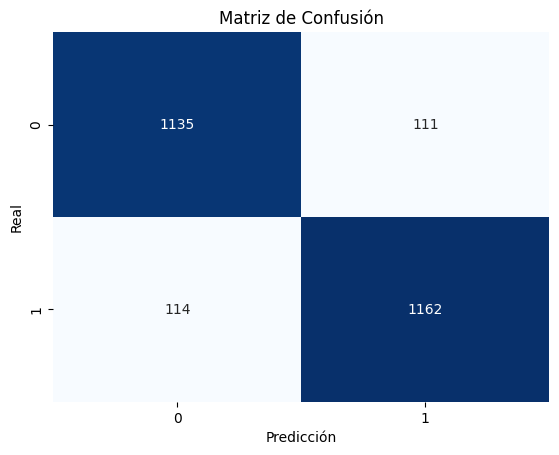

Vairbale:  Fisura nt
Presicion:  0.9432652127604904 Recall 0.930579170363729 f1 0.930579170363729
[2208    0]


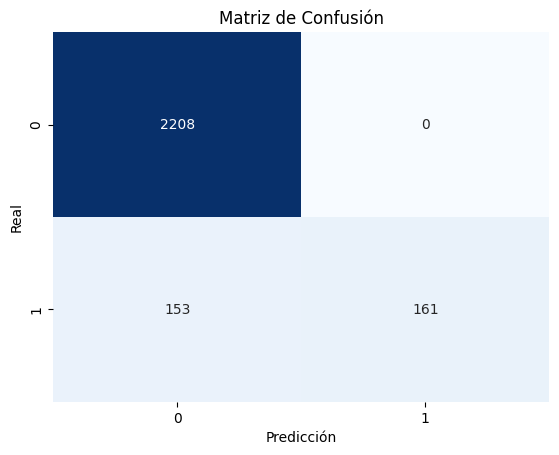

Vairbale:  Daño nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


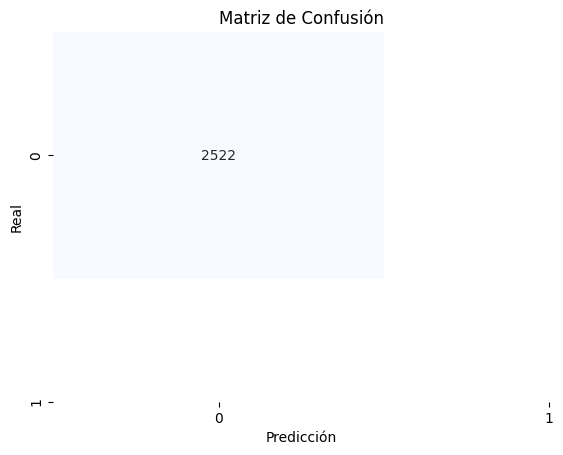

Vairbale:  Nudo nt
Presicion:  0.9293248610164476 Recall 0.9236729276933356 f1 0.9236729276933356
[642 167]


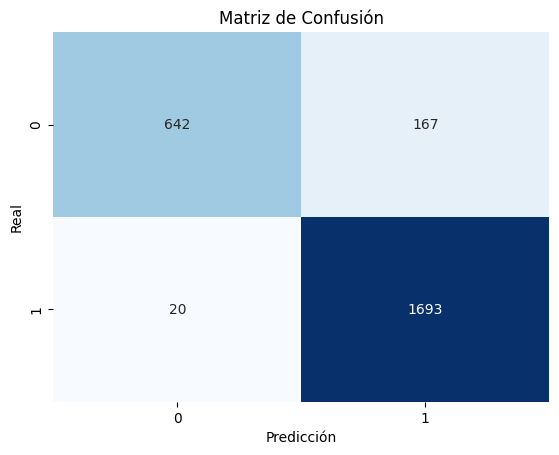

Vairbale:  Espesor nt
Presicion:  0.9369421103241894 Recall 0.9255218789487119 f1 0.9255218789487119
[2102    2]


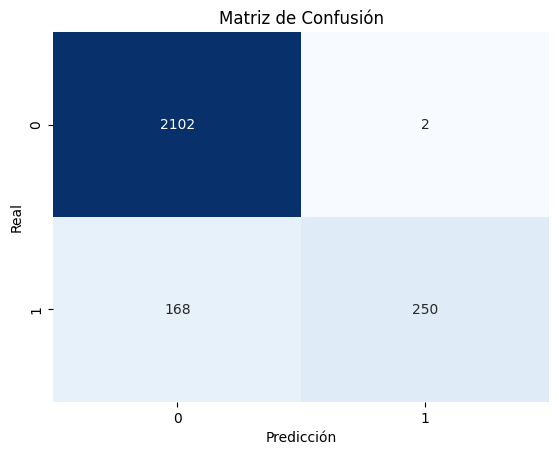

Vairbale:  Machete nt
Presicion:  0.9980213785486606 Recall 0.9973103756344884 f1 0.9973103756344884
[2516    0]


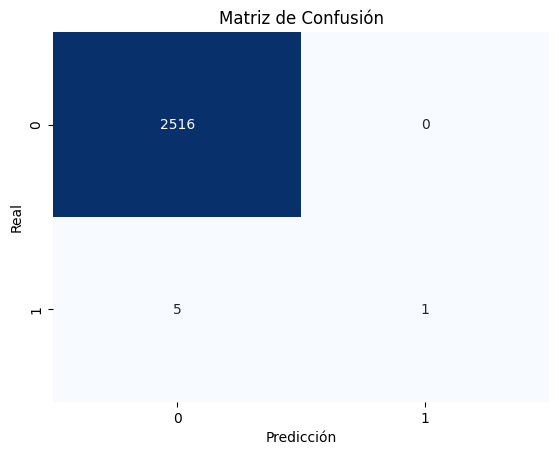

Vairbale:  Sin Pulir nt
Presicion:  1.0 Recall 1.0 f1 1.0
[2522]


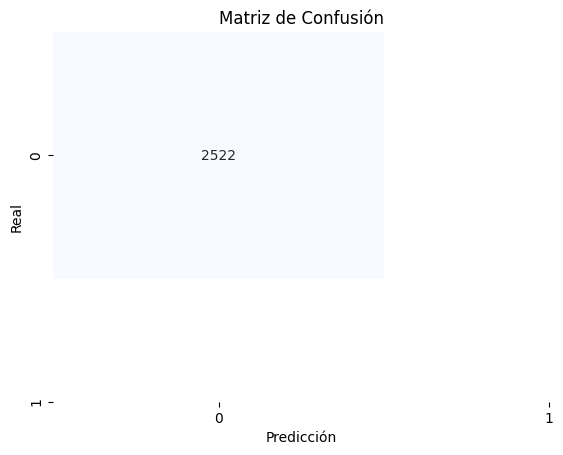

Vairbale:  Manipulación nt
Presicion:  0.941813664588413 Recall 0.937248044635955 f1 0.937248044635955
[475 139]


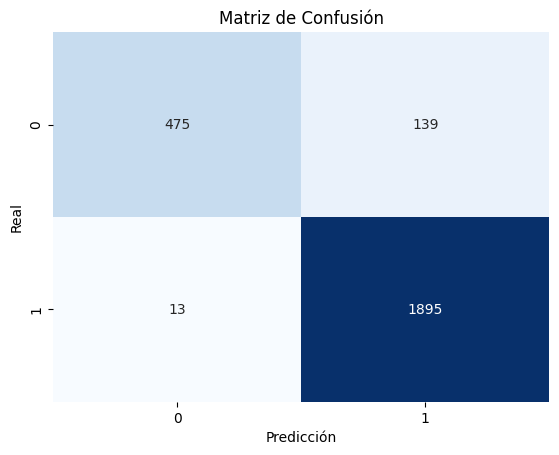

Vairbale:  Daño Tren nt
Presicion:  0.9980213847974929 Recall 0.9976880064434106 f1 0.9976880064434106
[2512    0]


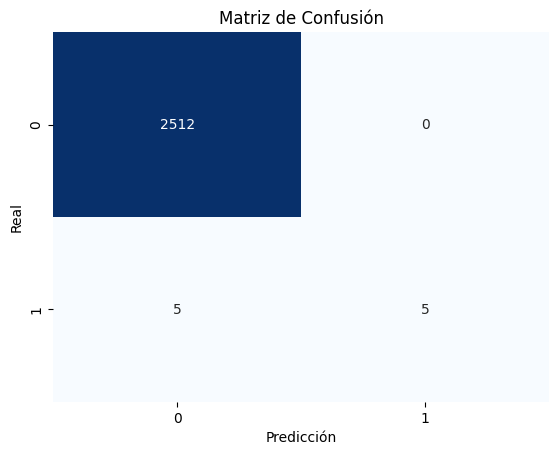

Vairbale:  Delaminada nt
Presicion:  0.9351269335999022 Recall 0.9349648821363212 f1 0.9349648821363212
[1194   70]


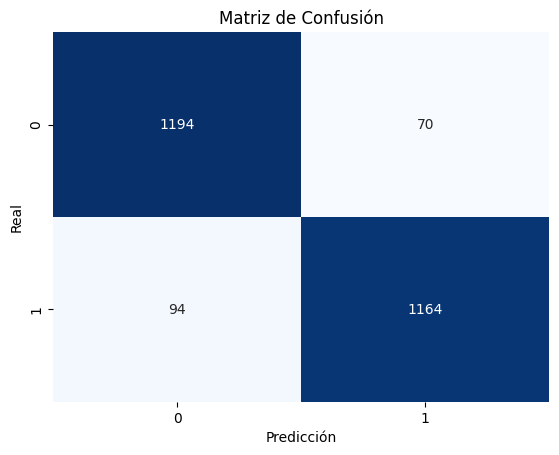

In [99]:
# Determinacion de matrices de confusion y métricas de los mejores modelos para las diferentes variables

split = BestModel(dfx_nt_nc_m2, dfy_nt_nc_m2)
split.split_data()
dict_choose_labels = {'column':[],'precision':[],
                      'recall':[],'FPR':[],'FNR':[],'f1':[],'TP':[],'TN':[],'FP':[],'FN':[]}

for file in os.listdir('best-nt-m2-without-variables'):
    if '.joblib' in file:
        print("Vairbale: ",' '.join(file.split("_")[:2]))
        try:

            idx = split.dfy.columns.get_loc(file.split("_")[0])
        
            y_test = split.y_test[:,idx]
            
            
            model = joblib.load('best-nt-m2-without-variables/'+file)
            y_pred = model.predict(split.X_test)
    
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            print("Presicion: ",precision,"Recall",f1,"f1",f1)
            
            cm = confusion_matrix(y_test, y_pred)
            print(cm[0,])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['0', '1'],
                        yticklabels=['0', '1'])
    
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.show()

            dict_choose_labels['column'].append(file.split("_")[0])
            dict_choose_labels['precision'].append(precision)
            dict_choose_labels['recall'].append(recall)
            dict_choose_labels['f1'].append(f1)

            try:
                fpr = cm[0,1]/(cm[0,1]+cm[0,0])
                fnr = cm[1,0]/(cm[1,1]+cm[1,0])
                dict_choose_labels['FPR'].append(fpr)
                dict_choose_labels['FNR'].append(fnr)
                dict_choose_labels['TP'].append(cm[1,1])
                dict_choose_labels['TN'].append(cm[0,0])
                dict_choose_labels['FP'].append(cm[0,1])
                dict_choose_labels['FN'].append(cm[1,0])

            except:
                dict_choose_labels['FPR'].append(1)
                dict_choose_labels['FNR'].append(1)
                dict_choose_labels['TP'].append(0)
                dict_choose_labels['TN'].append(0)
                dict_choose_labels['FP'].append(0)
                dict_choose_labels['FN'].append(0)
        
        except Exception as err:
            print("Fallo", err)

# Eleccion de mejores modelos y envios al github

## Aut m1 sin algunos predictores

In [118]:
models_aut_m1 = [
            'Separador','Tallon_aut','Nudo_aut',
            'Fisura_aut','Delaminada_aut','Desborde_aut',
            'Ondulación_aut','Burbuja_aut','Despunte_aut',
            'Basura_aut','Daño Estiba_aut','Manipulación_aut',
            'Mancha_aut'
]

In [115]:
# Se verifica que los archivos existan

for model_name in models_aut_m1:
    print("\n\nValidacion: ",model_name)
    %ls best-aut-m1-without-variables/'{model_name}'*



Validacion:  Separador
best-aut-m1-without-variables/Separador_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Tallon_aut
best-aut-m1-without-variables/Tallon_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Nudo_aut
best-aut-m1-without-variables/Nudo_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Fisura_aut
best-aut-m1-without-variables/Fisura_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Delaminada_aut
best-aut-m1-without-variables/Delaminada_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Desborde_aut
best-aut-m1-without-variables/Desborde_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Ondulación_aut
best-aut-m1-without-variables/Ondulación_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Burbuja_aut
best-aut-m1-without-variables/Burbuja_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Despunte_aut
best-aut-m1-without-variables/Despunte_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Basura_aut
best-aut-m1-wi

In [124]:
# Se mueven los archivos al repo del github

for model_name in models_aut_m1:
    %cp best-aut-m1-without-variables/'{model_name}'* models-tt-2/best-aut-m1-2

%cp scaler-aut-m1-without-variables/* models-tt-2/scaler-aut-m1

## Nt m1 sin algunos predictores

In [120]:
models_nt_m1 = [
            'Nudo','Material','Delaminada',
            'Desborde','Rajada','Despunte',
            'Basura','Desmoldeo','Tallon_aut',
            'Mancha'
]

In [121]:
# Se verifica que los archivos existan

for model_name in models_nt_m1:
    print("\n\nValidacion: ",model_name)
    %ls best-nt-m1-without-variables/'{model_name}'*



Validacion:  Nudo
best-nt-m1-without-variables/Nudo_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Material
best-nt-m1-without-variables/Material_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Delaminada
best-nt-m1-without-variables/Delaminada_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Desborde
best-nt-m1-without-variables/Desborde_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Rajada
best-nt-m1-without-variables/Rajada_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Despunte
best-nt-m1-without-variables/Despunte_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Basura
best-nt-m1-without-variables/Basura_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Desmoldeo
best-nt-m1-without-variables/Desmoldeo_aut_m1_best_extra_tree_classifier.joblib


Validacion:  Tallon
best-nt-m1-without-variables/Tallon_aut_m1_best_extra_tree_classifier.joblib
best-nt-m1-without-variables/Tallon_Montacargas_aut_m1_best_extra_tree_classifier.jobli

In [126]:
# Se mueven los archivos al repo del github

for model_name in models_nt_m1:
    %cp best-nt-m1-without-variables/'{model_name}'* models-tt-2/best-nt-m1
    
%cp scaler-nt-m1-without-variables/* models-tt-2/scaler-nt-m1

# Nt m2 sin algunos predictores

In [130]:
models_nt_m2 = [
                    'Desmoldeo','Mancha','Basura',
                    'Desmoldeadora','Tallon_nt','Rajada',
                    'Mal Corte','Despunte','Descolgada',
                    'Mal Ondulada','Desborde','Nudo',
                    'Manipulación','Delaminada',
]

In [131]:
# Se verifica que los archivos existan

for model_name in models_nt_m2:
    print("\n\nValidacion: ",model_name)
    %ls best-nt-m2-without-variables/'{model_name}'*



Validacion:  Desmoldeo
best-nt-m2-without-variables/Desmoldeo_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Mancha
best-nt-m2-without-variables/Mancha_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Basura
best-nt-m2-without-variables/Basura_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Desmoldeadora
best-nt-m2-without-variables/Desmoldeadora_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Tallon_nt
best-nt-m2-without-variables/Tallon_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Rajada
best-nt-m2-without-variables/Rajada_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Mal Corte
'best-nt-m2-without-variables/Mal Corte_nt_m2_best_extra_tree_classifier.joblib'


Validacion:  Despunte
best-nt-m2-without-variables/Despunte_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Descolgada
best-nt-m2-without-variables/Descolgada_nt_m2_best_extra_tree_classifier.joblib


Validacion:  Mal Ondulada
'best-nt-m2-without-variables/Mal Ondulada_nt_m

In [133]:
# Se mueven los archivos al repo del github

for model_name in models_nt_m2:
    %cp best-nt-m2-without-variables/'{model_name}'* models-tt-2/best-nt-m2
    
%cp scaler-nt-m2-without-variables/* models-tt-2/scaler-nt-m2